In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm
#import pytorch3d

/home/xingchenliu/anaconda3/envs/vae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset:

In [2]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [3]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [4]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

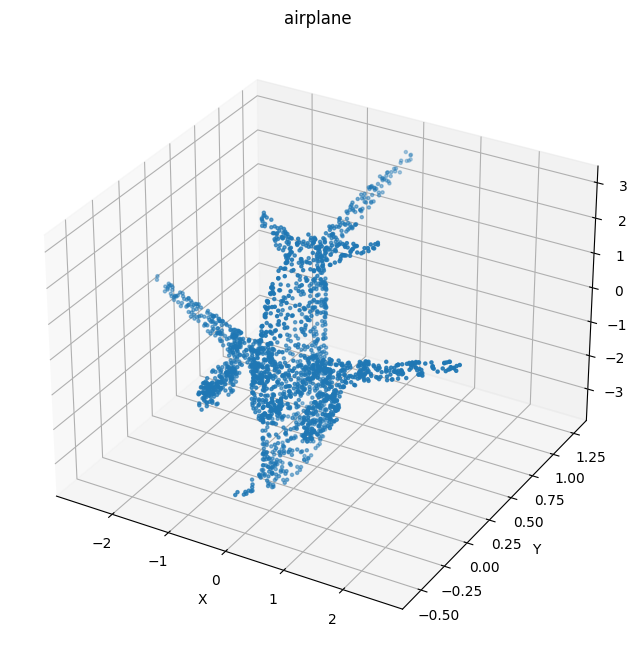

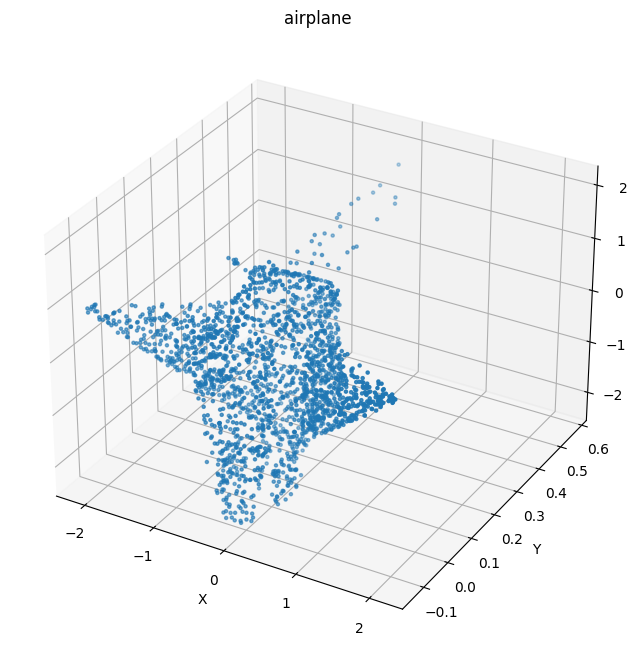

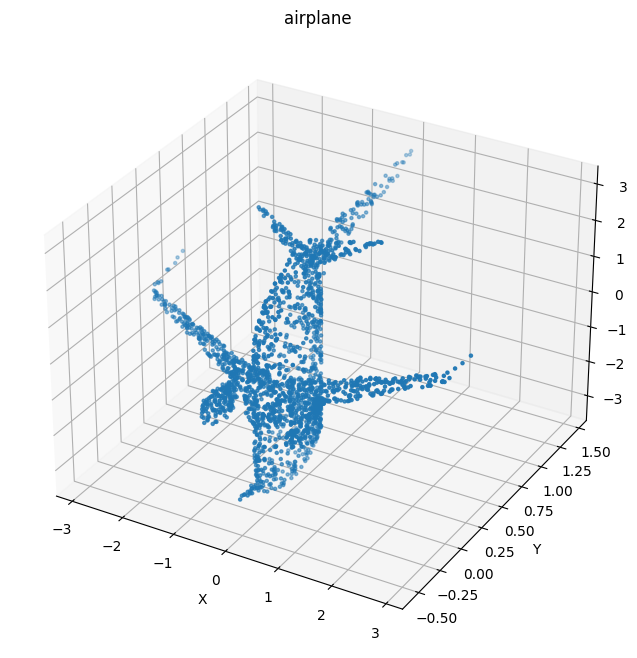

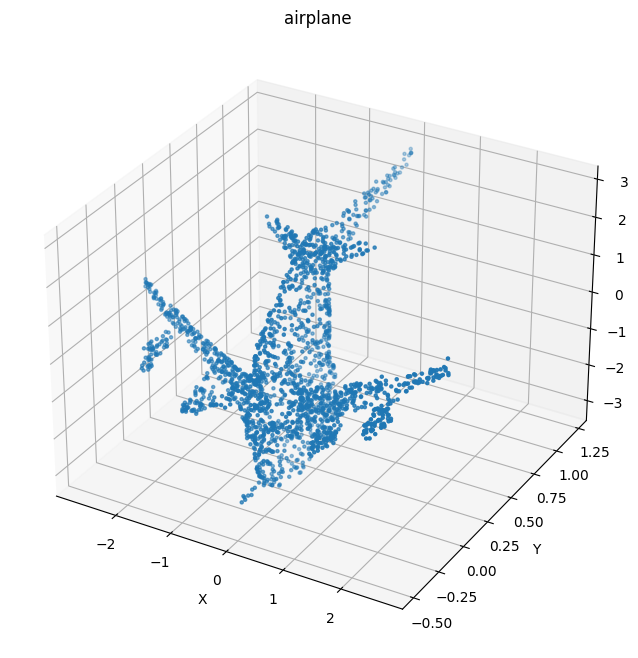

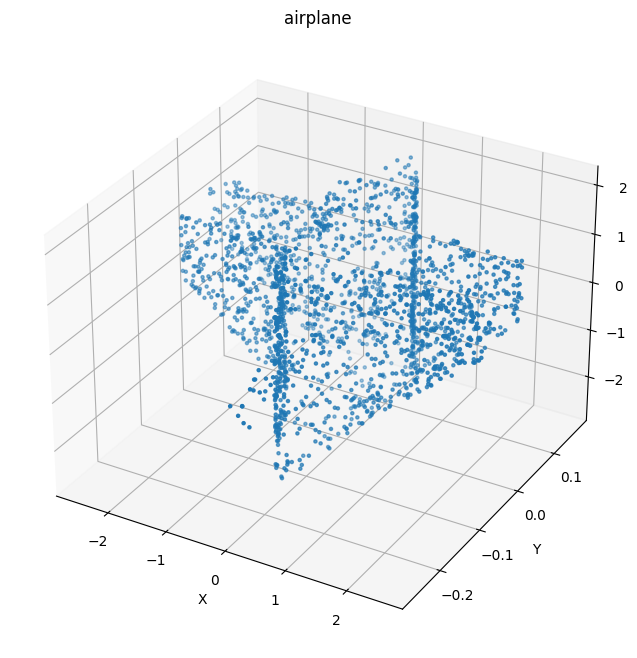

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [6]:
class TransformNet(nn.Module):
    def __init__(self, k=3):
        super(TransformNet, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)  # k*k for transformation matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Initialize the weights/bias with Identity transformation
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.copy_(torch.eye(k).view(-1))

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.gelu(self.bn4(self.fc1(x)))
        x = F.gelu(self.bn5(self.fc2(x)))
        
        x = self.fc3(x)
        
        # Reshape to the transformation matrix
        x = x.view(batch_size, -1)
        iden = torch.eye(self.fc3.out_features // x.size(-1)).view(-1).to(x.device)
        x = x + iden
        x = x.view(batch_size, x.size(1) // int(x.size(1)**0.5), int(x.size(1)**0.5))
        
        return x

In [7]:
class VariationalPointNetEncoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(VariationalPointNetEncoder, self).__init__()
        
        # Input transform
        self.input_transform = TransformNet(k=3)
        
        # Shared MLP
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # Feature transform
        self.feature_transform = TransformNet(k=64)
        
        # Batch Norm layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.transpose(2, 1)
        
        # Apply input transform
        input_transform = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), input_transform).transpose(1, 2)

        
        # Shared MLP layers
        x = F.gelu(self.bn1(self.conv1(x)))
        
        # Apply feature transform
        feature_transform = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), feature_transform).transpose(1, 2)

        
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        # Transition layers
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        
        # Get mu and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        # Reparametrization trick
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        # KL divergence
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z


Decoder:

In [8]:
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointNetDecoder, self).__init__()
        
        self.num_points = num_points
        
        # More expressive layers
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, num_points * 3)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x.view(-1, self.num_points, 3)


In [10]:
def chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two point clouds.
    
    Args:
    - p1 (torch.Tensor): A tensor of shape (B, N, D) representing a batch of point clouds, each of which has N points of dimension D.
    - p2 (torch.Tensor): A tensor of the same shape as p1.
    
    Returns:
    - distance (torch.Tensor): A tensor of shape (B,) representing the Chamfer Distance for each pair of point clouds in the batch.
    """
    
    # Compute the pairwise squared distances between points
    # p1 has shape (B, N, D) and p2 has shape (B, M, D)
    # The resulting dists will have shape (B, N, M)
    dists = torch.sum(p1**2, dim=2).unsqueeze(2) + torch.sum(p2**2, dim=2).unsqueeze(1) - 2 * torch.matmul(p1, p2.permute(0, 2, 1))
    
    # For each point in p1, find the closest distance in p2
    min_dists_p1 = torch.min(dists, dim=2)[0]  # Shape (B, N)
    
    # For each point in p2, find the closest distance in p1
    min_dists_p2 = torch.min(dists, dim=1)[0]  # Shape (B, M)
    
    # Combine the two distances by taking the average
    distance = (torch.sum(min_dists_p1, dim=1) + torch.sum(min_dists_p2, dim=1)) / 2
    
    return distance

# Test with the given point clouds
p1 = torch.tensor([[[8.8977, 4.1709, 1.2839],
                    [8.5640, 7.7767, 9.4214]],
                   [[0.5431, 6.4495, 11.4914],
                    [3.2126, 8.0865, 3.1018]]], dtype=torch.float)
p2 = torch.tensor([[[6.9340, 6.1152, 3.4435],
                    [0.1032, 9.8181, 11.3350]],
                   [[11.4006, 2.2154, 7.9589],
                    [4.2586, 1.4133, 7.2606]]], dtype=torch.float)

print(chamfer_distance(p1, p2))  # Expected output: tensor([ 72.5838, 151.0809])


tensor([ 72.5838, 151.0809])


VAE

In [11]:
class PointCloudVAE(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointCloudVAE, self).__init__()
        
        # Using the VariationalPointNetEncoder
        self.encoder = VariationalPointNetEncoder(num_points=num_points, latent_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        # Encode input point cloud and get latent variable z
        z = self.encoder(x)
        
        # Decode z to get the reconstructed point cloud
        reconstructed = self.decoder(z)
        
        return reconstructed, self.encoder.kl

# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=0.0):
    # Reconstruction loss
    recon_loss = chamfer_distance(reconstructed, original).mean()
    
    # Return combined loss
    return recon_loss + beta * kl_div

# Usage remains largely the same:

# Create a VAE
vae = PointCloudVAE(num_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)


Train

In [12]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_kl_div, total_recon_loss = 0, 0, 0
        
        # Training
        for i, batch in enumerate(tqdm(train_loader)):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
            combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
            
            combined_loss.backward()
            optimizer.step()
            
            total_train_loss += combined_loss.item()
            total_kl_div += kl_div.item()
            total_recon_loss += recon_loss.item()
            
            # Print batch-level losses
            print(f"Epoch {epoch+1}, Batch {i+1} - Combined Loss: {combined_loss.item():.4f}, KL Div: {kl_div.item():.4f}, Recon Loss: {recon_loss.item():.4f}")
            
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_kl_div = total_kl_div / len(train_loader)
        avg_train_recon_loss = total_recon_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss, total_val_kl_div, total_val_recon_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                
                recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
                combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
                
                total_val_loss += combined_loss.item()
                total_val_kl_div += kl_div.item()
                total_val_recon_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_kl_div = total_val_kl_div / len(val_loader)
        avg_val_recon_loss = total_val_recon_loss / len(val_loader)
        
        # Print epoch-level average losses
        print(f"\nEpoch: {epoch+1} Summary:")
        print(f"Train Avg Combined Loss: {avg_train_loss:.4f}, Train Avg KL Div: {avg_train_kl_div:.4f}, Train Avg Recon Loss: {avg_train_recon_loss:.4f}")
        print(f"Val Avg Combined Loss: {avg_val_loss:.4f}, Val Avg KL Div: {avg_val_kl_div:.4f}, Val Avg Recon Loss: {avg_val_recon_loss:.4f}\n")



In [13]:
vae = PointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [14]:
train_vae(vae, train_loader, val_loader, optimizer)

  7%|▋         | 2/27 [00:00<00:05,  4.59it/s]

Epoch 1, Batch 1 - Combined Loss: 3633.0911, KL Div: 1609.2852, Recon Loss: 2023.8059
Epoch 1, Batch 2 - Combined Loss: 2035.8975, KL Div: 900.9131, Recon Loss: 1134.9844


 15%|█▍        | 4/27 [00:00<00:04,  5.54it/s]

Epoch 1, Batch 3 - Combined Loss: 566.2582, KL Div: 219.7643, Recon Loss: 346.4939
Epoch 1, Batch 4 - Combined Loss: 399.4011, KL Div: 70.3350, Recon Loss: 329.0660


 22%|██▏       | 6/27 [00:01<00:03,  5.89it/s]

Epoch 1, Batch 5 - Combined Loss: 407.7680, KL Div: 37.3613, Recon Loss: 370.4067
Epoch 1, Batch 6 - Combined Loss: 284.9175, KL Div: 30.6929, Recon Loss: 254.2247


 30%|██▉       | 8/27 [00:01<00:03,  6.04it/s]

Epoch 1, Batch 7 - Combined Loss: 230.0367, KL Div: 29.1485, Recon Loss: 200.8882
Epoch 1, Batch 8 - Combined Loss: 183.9422, KL Div: 29.0049, Recon Loss: 154.9373


 37%|███▋      | 10/27 [00:01<00:02,  6.10it/s]

Epoch 1, Batch 9 - Combined Loss: 163.2153, KL Div: 28.0978, Recon Loss: 135.1175
Epoch 1, Batch 10 - Combined Loss: 149.8649, KL Div: 28.2133, Recon Loss: 121.6517


 44%|████▍     | 12/27 [00:02<00:02,  6.14it/s]

Epoch 1, Batch 11 - Combined Loss: 159.3704, KL Div: 26.8826, Recon Loss: 132.4879
Epoch 1, Batch 12 - Combined Loss: 169.4352, KL Div: 26.1852, Recon Loss: 143.2501


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 1, Batch 13 - Combined Loss: 166.7348, KL Div: 25.4399, Recon Loss: 141.2949
Epoch 1, Batch 14 - Combined Loss: 144.8525, KL Div: 24.7779, Recon Loss: 120.0746


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 1, Batch 15 - Combined Loss: 139.0710, KL Div: 24.0135, Recon Loss: 115.0576
Epoch 1, Batch 16 - Combined Loss: 130.4779, KL Div: 23.1599, Recon Loss: 107.3179


 67%|██████▋   | 18/27 [00:03<00:01,  6.17it/s]

Epoch 1, Batch 17 - Combined Loss: 122.6940, KL Div: 22.5647, Recon Loss: 100.1292
Epoch 1, Batch 18 - Combined Loss: 118.7728, KL Div: 21.5298, Recon Loss: 97.2431


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 1, Batch 19 - Combined Loss: 118.9386, KL Div: 20.7807, Recon Loss: 98.1578
Epoch 1, Batch 20 - Combined Loss: 110.1365, KL Div: 19.8123, Recon Loss: 90.3242


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 1, Batch 21 - Combined Loss: 102.4436, KL Div: 19.1670, Recon Loss: 83.2766
Epoch 1, Batch 22 - Combined Loss: 100.4643, KL Div: 18.5266, Recon Loss: 81.9376


 89%|████████▉ | 24/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 23 - Combined Loss: 101.7726, KL Div: 17.3856, Recon Loss: 84.3870
Epoch 1, Batch 24 - Combined Loss: 102.8126, KL Div: 16.7186, Recon Loss: 86.0939


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 25 - Combined Loss: 105.3696, KL Div: 15.6136, Recon Loss: 89.7561
Epoch 1, Batch 26 - Combined Loss: 97.0215, KL Div: 14.9962, Recon Loss: 82.0253


100%|██████████| 27/27 [00:04<00:00,  6.01it/s]


Epoch 1, Batch 27 - Combined Loss: 95.9705, KL Div: 11.9802, Recon Loss: 83.9902

Epoch: 1 Summary:
Train Avg Combined Loss: 375.5826, Train Avg KL Div: 123.4204, Train Avg Recon Loss: 252.1622
Val Avg Combined Loss: 110.4729, Val Avg KL Div: 16.3591, Val Avg Recon Loss: 94.1137



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 2, Batch 1 - Combined Loss: 91.0716, KL Div: 13.3970, Recon Loss: 77.6746


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 2, Batch 2 - Combined Loss: 95.5762, KL Div: 12.4929, Recon Loss: 83.0833


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 3 - Combined Loss: 83.8160, KL Div: 11.6832, Recon Loss: 72.1328


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 4 - Combined Loss: 93.1097, KL Div: 11.1254, Recon Loss: 81.9843


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 5 - Combined Loss: 85.4377, KL Div: 10.2666, Recon Loss: 75.1712


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 6 - Combined Loss: 86.7216, KL Div: 9.7983, Recon Loss: 76.9233


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 7 - Combined Loss: 85.7194, KL Div: 8.9918, Recon Loss: 76.7275


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 8 - Combined Loss: 89.3850, KL Div: 8.3940, Recon Loss: 80.9910


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 9 - Combined Loss: 88.5744, KL Div: 7.7499, Recon Loss: 80.8245


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 10 - Combined Loss: 77.9730, KL Div: 7.3268, Recon Loss: 70.6461


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 11 - Combined Loss: 75.9682, KL Div: 6.6631, Recon Loss: 69.3051


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 12 - Combined Loss: 84.7401, KL Div: 6.2552, Recon Loss: 78.4850


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 2, Batch 13 - Combined Loss: 81.2790, KL Div: 5.6807, Recon Loss: 75.5983


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 2, Batch 14 - Combined Loss: 79.1341, KL Div: 5.3318, Recon Loss: 73.8023


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 15 - Combined Loss: 80.9193, KL Div: 4.8800, Recon Loss: 76.0393


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 16 - Combined Loss: 77.9002, KL Div: 4.5020, Recon Loss: 73.3982


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 17 - Combined Loss: 73.7218, KL Div: 4.0555, Recon Loss: 69.6664


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 18 - Combined Loss: 72.6499, KL Div: 3.7672, Recon Loss: 68.8827


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 2, Batch 19 - Combined Loss: 81.5394, KL Div: 3.4813, Recon Loss: 78.0581


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 2, Batch 20 - Combined Loss: 74.0942, KL Div: 3.1385, Recon Loss: 70.9557


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 21 - Combined Loss: 71.7240, KL Div: 3.0144, Recon Loss: 68.7096


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 22 - Combined Loss: 73.5484, KL Div: 2.6878, Recon Loss: 70.8606


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 23 - Combined Loss: 74.3121, KL Div: 2.5216, Recon Loss: 71.7905


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 24 - Combined Loss: 74.6044, KL Div: 2.2897, Recon Loss: 72.3147


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 25 - Combined Loss: 78.8903, KL Div: 2.0974, Recon Loss: 76.7929


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 26 - Combined Loss: 73.1345, KL Div: 1.9637, Recon Loss: 71.1708


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 2, Batch 27 - Combined Loss: 76.5529, KL Div: 1.5437, Recon Loss: 75.0092



Epoch: 2 Summary:
Train Avg Combined Loss: 80.8184, Train Avg KL Div: 6.1148, Train Avg Recon Loss: 74.7036
Val Avg Combined Loss: 78.1718, Val Avg KL Div: 1.6134, Val Avg Recon Loss: 76.5583



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 3, Batch 1 - Combined Loss: 69.3255, KL Div: 1.6404, Recon Loss: 67.6851


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 3, Batch 2 - Combined Loss: 74.6720, KL Div: 1.3811, Recon Loss: 73.2909


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 3 - Combined Loss: 63.4069, KL Div: 1.4409, Recon Loss: 61.9660


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 3, Batch 4 - Combined Loss: 73.3495, KL Div: 1.1425, Recon Loss: 72.2070


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 5 - Combined Loss: 67.7903, KL Div: 1.4794, Recon Loss: 66.3109


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 6 - Combined Loss: 71.0677, KL Div: 1.0031, Recon Loss: 70.0646


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 3, Batch 7 - Combined Loss: 70.4620, KL Div: 1.1381, Recon Loss: 69.3239


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 3, Batch 8 - Combined Loss: 75.1999, KL Div: 0.8796, Recon Loss: 74.3203


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 9 - Combined Loss: 75.6014, KL Div: 1.0993, Recon Loss: 74.5021


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 10 - Combined Loss: 64.9680, KL Div: 0.8215, Recon Loss: 64.1465


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 11 - Combined Loss: 64.8751, KL Div: 0.7975, Recon Loss: 64.0777


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 12 - Combined Loss: 73.0418, KL Div: 0.7746, Recon Loss: 72.2673


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 3, Batch 13 - Combined Loss: 71.0691, KL Div: 0.7283, Recon Loss: 70.3408


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 3, Batch 14 - Combined Loss: 70.2012, KL Div: 0.8220, Recon Loss: 69.3792


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 15 - Combined Loss: 70.7380, KL Div: 0.5110, Recon Loss: 70.2270


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 16 - Combined Loss: 69.8956, KL Div: 0.5110, Recon Loss: 69.3847


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 17 - Combined Loss: 64.0961, KL Div: 0.5865, Recon Loss: 63.5096


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 18 - Combined Loss: 66.7766, KL Div: 0.3969, Recon Loss: 66.3797


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 3, Batch 19 - Combined Loss: 74.3438, KL Div: 0.5692, Recon Loss: 73.7746


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 3, Batch 20 - Combined Loss: 65.6161, KL Div: 0.3098, Recon Loss: 65.3063


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 3, Batch 21 - Combined Loss: 65.6631, KL Div: 0.7341, Recon Loss: 64.9290


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 3, Batch 22 - Combined Loss: 66.9140, KL Div: 0.2896, Recon Loss: 66.6243


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 3, Batch 23 - Combined Loss: 68.0915, KL Div: 0.7467, Recon Loss: 67.3448


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 3, Batch 24 - Combined Loss: 70.0677, KL Div: 0.2347, Recon Loss: 69.8330


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 3, Batch 25 - Combined Loss: 73.5288, KL Div: 0.9899, Recon Loss: 72.5388


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 3, Batch 26 - Combined Loss: 68.3275, KL Div: 0.3199, Recon Loss: 68.0076


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 3, Batch 27 - Combined Loss: 73.1389, KL Div: 0.7526, Recon Loss: 72.3863



Epoch: 3 Summary:
Train Avg Combined Loss: 69.7121, Train Avg KL Div: 0.8185, Train Avg Recon Loss: 68.8936
Val Avg Combined Loss: 74.2492, Val Avg KL Div: 0.6226, Val Avg Recon Loss: 73.6265



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 4, Batch 1 - Combined Loss: 66.7449, KL Div: 0.9795, Recon Loss: 65.7654


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 4, Batch 2 - Combined Loss: 70.2563, KL Div: 0.1589, Recon Loss: 70.0973


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 3 - Combined Loss: 61.8249, KL Div: 1.4333, Recon Loss: 60.3916


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 4 - Combined Loss: 69.9281, KL Div: 0.1963, Recon Loss: 69.7318


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 5 - Combined Loss: 66.7795, KL Div: 0.6579, Recon Loss: 66.1216


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 6 - Combined Loss: 66.0994, KL Div: 0.3255, Recon Loss: 65.7739


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 7 - Combined Loss: 67.6335, KL Div: 0.4093, Recon Loss: 67.2242


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 8 - Combined Loss: 70.6717, KL Div: 0.1829, Recon Loss: 70.4887


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 9 - Combined Loss: 71.8233, KL Div: 0.5470, Recon Loss: 71.2763


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 10 - Combined Loss: 62.3822, KL Div: 0.1453, Recon Loss: 62.2369


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 11 - Combined Loss: 64.3184, KL Div: 0.6074, Recon Loss: 63.7110


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 12 - Combined Loss: 71.8706, KL Div: 0.3996, Recon Loss: 71.4709


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 13 - Combined Loss: 70.3642, KL Div: 0.4758, Recon Loss: 69.8884


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 14 - Combined Loss: 67.0843, KL Div: 1.0701, Recon Loss: 66.0142


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 15 - Combined Loss: 68.5504, KL Div: 0.4330, Recon Loss: 68.1174


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 16 - Combined Loss: 67.8725, KL Div: 0.5075, Recon Loss: 67.3651


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 17 - Combined Loss: 62.9280, KL Div: 0.4726, Recon Loss: 62.4554


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 18 - Combined Loss: 64.3300, KL Div: 0.1634, Recon Loss: 64.1666


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 4, Batch 19 - Combined Loss: 70.2561, KL Div: 0.5367, Recon Loss: 69.7194


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 4, Batch 20 - Combined Loss: 66.2677, KL Div: 0.8142, Recon Loss: 65.4535


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 21 - Combined Loss: 62.6789, KL Div: 0.1450, Recon Loss: 62.5339


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 22 - Combined Loss: 64.9915, KL Div: 0.6101, Recon Loss: 64.3814


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 23 - Combined Loss: 64.5618, KL Div: 0.1993, Recon Loss: 64.3625


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 24 - Combined Loss: 69.7002, KL Div: 0.1099, Recon Loss: 69.5903


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 4, Batch 25 - Combined Loss: 71.8638, KL Div: 0.4523, Recon Loss: 71.4115


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 4, Batch 26 - Combined Loss: 67.6785, KL Div: 0.1223, Recon Loss: 67.5562


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 4, Batch 27 - Combined Loss: 71.0324, KL Div: 0.3013, Recon Loss: 70.7312



Epoch: 4 Summary:
Train Avg Combined Loss: 67.4257, Train Avg KL Div: 0.4613, Train Avg Recon Loss: 66.9643
Val Avg Combined Loss: 78.9206, Val Avg KL Div: 0.1864, Val Avg Recon Loss: 78.7342



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 5, Batch 1 - Combined Loss: 62.8501, KL Div: 0.4755, Recon Loss: 62.3746


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 5, Batch 2 - Combined Loss: 70.7417, KL Div: 0.2378, Recon Loss: 70.5040


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 3 - Combined Loss: 58.9702, KL Div: 0.5228, Recon Loss: 58.4474


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 4 - Combined Loss: 67.6395, KL Div: 0.1873, Recon Loss: 67.4522


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 5 - Combined Loss: 62.8792, KL Div: 0.4051, Recon Loss: 62.4741


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 6 - Combined Loss: 66.8834, KL Div: 0.5390, Recon Loss: 66.3444


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 5, Batch 7 - Combined Loss: 66.2927, KL Div: 0.2011, Recon Loss: 66.0916


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 5, Batch 8 - Combined Loss: 70.9049, KL Div: 0.4536, Recon Loss: 70.4512


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 9 - Combined Loss: 69.3643, KL Div: 0.5020, Recon Loss: 68.8624


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 10 - Combined Loss: 62.6168, KL Div: 0.3511, Recon Loss: 62.2657


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 11 - Combined Loss: 58.6860, KL Div: 0.2365, Recon Loss: 58.4495


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 12 - Combined Loss: 70.0687, KL Div: 0.1936, Recon Loss: 69.8752


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 5, Batch 13 - Combined Loss: 68.2646, KL Div: 0.2272, Recon Loss: 68.0374


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 5, Batch 14 - Combined Loss: 65.4948, KL Div: 0.1618, Recon Loss: 65.3329


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 15 - Combined Loss: 66.5739, KL Div: 0.1526, Recon Loss: 66.4212


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 16 - Combined Loss: 66.1135, KL Div: 0.1609, Recon Loss: 65.9525


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 17 - Combined Loss: 60.9738, KL Div: 0.2238, Recon Loss: 60.7500


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 18 - Combined Loss: 63.1256, KL Div: 0.0613, Recon Loss: 63.0643


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 5, Batch 19 - Combined Loss: 70.4854, KL Div: 0.0547, Recon Loss: 70.4307


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 5, Batch 20 - Combined Loss: 63.7636, KL Div: 0.0732, Recon Loss: 63.6904


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 21 - Combined Loss: 62.0831, KL Div: 0.3062, Recon Loss: 61.7769


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 22 - Combined Loss: 61.7291, KL Div: 0.0735, Recon Loss: 61.6556


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 23 - Combined Loss: 64.0394, KL Div: 0.1323, Recon Loss: 63.9071


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 24 - Combined Loss: 66.1377, KL Div: 0.1765, Recon Loss: 65.9612


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 5, Batch 25 - Combined Loss: 69.6580, KL Div: 0.0857, Recon Loss: 69.5723


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 5, Batch 26 - Combined Loss: 66.0941, KL Div: 0.1571, Recon Loss: 65.9370


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 5, Batch 27 - Combined Loss: 71.6137, KL Div: 0.1495, Recon Loss: 71.4642



Epoch: 5 Summary:
Train Avg Combined Loss: 65.7055, Train Avg KL Div: 0.2408, Train Avg Recon Loss: 65.4647
Val Avg Combined Loss: 88.6052, Val Avg KL Div: 0.1138, Val Avg Recon Loss: 88.4914



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 6, Batch 1 - Combined Loss: 61.7284, KL Div: 0.0890, Recon Loss: 61.6395


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 6, Batch 2 - Combined Loss: 67.7638, KL Div: 0.1263, Recon Loss: 67.6376


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 3 - Combined Loss: 57.7062, KL Div: 0.0391, Recon Loss: 57.6670


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 4 - Combined Loss: 65.9993, KL Div: 0.0491, Recon Loss: 65.9502


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 5 - Combined Loss: 62.6670, KL Div: 0.0516, Recon Loss: 62.6154


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 6 - Combined Loss: 63.5342, KL Div: 0.0335, Recon Loss: 63.5008


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 6, Batch 7 - Combined Loss: 66.6297, KL Div: 0.0392, Recon Loss: 66.5905


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 6, Batch 8 - Combined Loss: 69.1599, KL Div: 0.0350, Recon Loss: 69.1249


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 9 - Combined Loss: 69.9597, KL Div: 0.0383, Recon Loss: 69.9213


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 10 - Combined Loss: 59.9828, KL Div: 0.0218, Recon Loss: 59.9611


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 11 - Combined Loss: 59.4088, KL Div: 0.0231, Recon Loss: 59.3857


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 6, Batch 12 - Combined Loss: 68.4255, KL Div: 0.0170, Recon Loss: 68.4085


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 6, Batch 13 - Combined Loss: 65.8126, KL Div: 0.0259, Recon Loss: 65.7868


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 6, Batch 14 - Combined Loss: 62.5765, KL Div: 0.0200, Recon Loss: 62.5564


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 15 - Combined Loss: 64.6385, KL Div: 0.0270, Recon Loss: 64.6115


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 6, Batch 16 - Combined Loss: 66.0041, KL Div: 0.0182, Recon Loss: 65.9860


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 6, Batch 17 - Combined Loss: 61.2609, KL Div: 0.0294, Recon Loss: 61.2316


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 6, Batch 18 - Combined Loss: 64.4145, KL Div: 0.0342, Recon Loss: 64.3803


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 6, Batch 19 - Combined Loss: 66.8683, KL Div: 0.0218, Recon Loss: 66.8464


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 6, Batch 20 - Combined Loss: 65.3395, KL Div: 0.0346, Recon Loss: 65.3049


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 6, Batch 21 - Combined Loss: 62.3123, KL Div: 0.0231, Recon Loss: 62.2892


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 6, Batch 22 - Combined Loss: 61.8668, KL Div: 0.0509, Recon Loss: 61.8159


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 23 - Combined Loss: 66.0639, KL Div: 0.0506, Recon Loss: 66.0133


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 6, Batch 24 - Combined Loss: 67.2738, KL Div: 0.0460, Recon Loss: 67.2278


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 6, Batch 25 - Combined Loss: 69.9025, KL Div: 0.0616, Recon Loss: 69.8409


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 6, Batch 26 - Combined Loss: 65.6837, KL Div: 0.0229, Recon Loss: 65.6609


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 6, Batch 27 - Combined Loss: 70.5541, KL Div: 0.0486, Recon Loss: 70.5055



Epoch: 6 Summary:
Train Avg Combined Loss: 64.9458, Train Avg KL Div: 0.0399, Train Avg Recon Loss: 64.9059
Val Avg Combined Loss: 89.9459, Val Avg KL Div: 0.0402, Val Avg Recon Loss: 89.9057



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 7, Batch 1 - Combined Loss: 60.5092, KL Div: 0.0649, Recon Loss: 60.4442


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 7, Batch 2 - Combined Loss: 66.6825, KL Div: 0.0498, Recon Loss: 66.6326


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 3 - Combined Loss: 57.7734, KL Div: 0.0396, Recon Loss: 57.7338


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 4 - Combined Loss: 65.0965, KL Div: 0.0243, Recon Loss: 65.0722


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 5 - Combined Loss: 63.1021, KL Div: 0.0251, Recon Loss: 63.0770


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 6 - Combined Loss: 62.8002, KL Div: 0.0195, Recon Loss: 62.7808


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 7 - Combined Loss: 64.3610, KL Div: 0.0243, Recon Loss: 64.3367


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 8 - Combined Loss: 67.6505, KL Div: 0.0245, Recon Loss: 67.6260


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 9 - Combined Loss: 69.4928, KL Div: 0.0274, Recon Loss: 69.4654


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 10 - Combined Loss: 59.5433, KL Div: 0.0138, Recon Loss: 59.5296


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 11 - Combined Loss: 59.1474, KL Div: 0.0118, Recon Loss: 59.1356


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 12 - Combined Loss: 67.8292, KL Div: 0.0148, Recon Loss: 67.8144


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 7, Batch 13 - Combined Loss: 66.6032, KL Div: 0.0181, Recon Loss: 66.5851


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 7, Batch 14 - Combined Loss: 63.7223, KL Div: 0.0204, Recon Loss: 63.7018


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 7, Batch 15 - Combined Loss: 64.4400, KL Div: 0.0237, Recon Loss: 64.4163


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 7, Batch 16 - Combined Loss: 66.9087, KL Div: 0.0154, Recon Loss: 66.8933


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 7, Batch 17 - Combined Loss: 62.9110, KL Div: 0.0286, Recon Loss: 62.8823


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 18 - Combined Loss: 61.8594, KL Div: 0.0244, Recon Loss: 61.8350


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 19 - Combined Loss: 66.1320, KL Div: 0.0123, Recon Loss: 66.1197


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 20 - Combined Loss: 62.2706, KL Div: 0.0205, Recon Loss: 62.2502


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 7, Batch 21 - Combined Loss: 60.7695, KL Div: 0.0263, Recon Loss: 60.7432


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 7, Batch 22 - Combined Loss: 61.8262, KL Div: 0.0167, Recon Loss: 61.8095


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 23 - Combined Loss: 62.8837, KL Div: 0.0115, Recon Loss: 62.8722


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 24 - Combined Loss: 65.4097, KL Div: 0.0371, Recon Loss: 65.3726


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 7, Batch 25 - Combined Loss: 67.2904, KL Div: 0.0236, Recon Loss: 67.2668


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 7, Batch 26 - Combined Loss: 66.3647, KL Div: 0.0189, Recon Loss: 66.3458


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 7, Batch 27 - Combined Loss: 68.0595, KL Div: 0.0155, Recon Loss: 68.0439



Epoch: 7 Summary:
Train Avg Combined Loss: 64.1274, Train Avg KL Div: 0.0242, Train Avg Recon Loss: 64.1032
Val Avg Combined Loss: 101.9009, Val Avg KL Div: 0.0256, Val Avg Recon Loss: 101.8753



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 8, Batch 1 - Combined Loss: 62.1048, KL Div: 0.0242, Recon Loss: 62.0806


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 8, Batch 2 - Combined Loss: 64.0287, KL Div: 0.0224, Recon Loss: 64.0064


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 3 - Combined Loss: 57.3623, KL Div: 0.0180, Recon Loss: 57.3443


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 4 - Combined Loss: 66.2976, KL Div: 0.0210, Recon Loss: 66.2765


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 5 - Combined Loss: 62.0120, KL Div: 0.0239, Recon Loss: 61.9881


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 6 - Combined Loss: 62.7723, KL Div: 0.0111, Recon Loss: 62.7612


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 8, Batch 7 - Combined Loss: 63.4607, KL Div: 0.0089, Recon Loss: 63.4519


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 8, Batch 8 - Combined Loss: 67.1875, KL Div: 0.0134, Recon Loss: 67.1740


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 8, Batch 9 - Combined Loss: 68.9555, KL Div: 0.0247, Recon Loss: 68.9308


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 8, Batch 10 - Combined Loss: 58.9958, KL Div: 0.0175, Recon Loss: 58.9784


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 8, Batch 11 - Combined Loss: 58.8730, KL Div: 0.0095, Recon Loss: 58.8635


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 8, Batch 12 - Combined Loss: 66.6789, KL Div: 0.0079, Recon Loss: 66.6710


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 13 - Combined Loss: 64.6305, KL Div: 0.0202, Recon Loss: 64.6103


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 14 - Combined Loss: 62.6443, KL Div: 0.0122, Recon Loss: 62.6321


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 15 - Combined Loss: 64.1720, KL Div: 0.0160, Recon Loss: 64.1560


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 16 - Combined Loss: 64.2391, KL Div: 0.0179, Recon Loss: 64.2212


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 8, Batch 17 - Combined Loss: 59.6227, KL Div: 0.0318, Recon Loss: 59.5908


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 8, Batch 18 - Combined Loss: 62.1124, KL Div: 0.0138, Recon Loss: 62.0986


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 8, Batch 19 - Combined Loss: 67.6800, KL Div: 0.0114, Recon Loss: 67.6686


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 8, Batch 20 - Combined Loss: 61.4191, KL Div: 0.0090, Recon Loss: 61.4101


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 21 - Combined Loss: 59.9981, KL Div: 0.0256, Recon Loss: 59.9725


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 22 - Combined Loss: 59.7903, KL Div: 0.0246, Recon Loss: 59.7657


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 23 - Combined Loss: 65.2926, KL Div: 0.0193, Recon Loss: 65.2733


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 24 - Combined Loss: 67.0149, KL Div: 0.0195, Recon Loss: 66.9954


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 8, Batch 25 - Combined Loss: 68.5680, KL Div: 0.0318, Recon Loss: 68.5362


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 8, Batch 26 - Combined Loss: 64.5942, KL Div: 0.0142, Recon Loss: 64.5800


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 8, Batch 27 - Combined Loss: 70.9803, KL Div: 0.0190, Recon Loss: 70.9613



Epoch: 8 Summary:
Train Avg Combined Loss: 63.7588, Train Avg KL Div: 0.0181, Train Avg Recon Loss: 63.7407
Val Avg Combined Loss: 88.7823, Val Avg KL Div: 0.0325, Val Avg Recon Loss: 88.7498



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 9, Batch 1 - Combined Loss: 57.6000, KL Div: 0.0317, Recon Loss: 57.5682


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 9, Batch 2 - Combined Loss: 63.9058, KL Div: 0.0285, Recon Loss: 63.8772


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 3 - Combined Loss: 56.2539, KL Div: 0.0191, Recon Loss: 56.2348


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 4 - Combined Loss: 63.5576, KL Div: 0.0184, Recon Loss: 63.5392


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 5 - Combined Loss: 59.3829, KL Div: 0.0191, Recon Loss: 59.3638


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 6 - Combined Loss: 63.0849, KL Div: 0.0157, Recon Loss: 63.0692


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 9, Batch 7 - Combined Loss: 63.2868, KL Div: 0.0242, Recon Loss: 63.2626


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 9, Batch 8 - Combined Loss: 68.3777, KL Div: 0.0118, Recon Loss: 68.3658


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 9 - Combined Loss: 66.4450, KL Div: 0.0238, Recon Loss: 66.4212


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 10 - Combined Loss: 58.0921, KL Div: 0.0084, Recon Loss: 58.0837


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 11 - Combined Loss: 57.2659, KL Div: 0.0117, Recon Loss: 57.2542


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 9, Batch 12 - Combined Loss: 65.8376, KL Div: 0.0110, Recon Loss: 65.8266


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 9, Batch 13 - Combined Loss: 64.1086, KL Div: 0.0139, Recon Loss: 64.0948


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 9, Batch 14 - Combined Loss: 61.0373, KL Div: 0.0092, Recon Loss: 61.0282


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 9, Batch 15 - Combined Loss: 63.5372, KL Div: 0.0168, Recon Loss: 63.5204


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 9, Batch 16 - Combined Loss: 63.1579, KL Div: 0.0087, Recon Loss: 63.1492


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 9, Batch 17 - Combined Loss: 58.5662, KL Div: 0.0150, Recon Loss: 58.5512


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 9, Batch 18 - Combined Loss: 60.4905, KL Div: 0.0126, Recon Loss: 60.4780


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 9, Batch 19 - Combined Loss: 67.3068, KL Div: 0.0158, Recon Loss: 67.2910


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 9, Batch 20 - Combined Loss: 61.0921, KL Div: 0.0169, Recon Loss: 61.0752


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 21 - Combined Loss: 59.9831, KL Div: 0.0119, Recon Loss: 59.9712


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 22 - Combined Loss: 61.4025, KL Div: 0.0149, Recon Loss: 61.3876


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 23 - Combined Loss: 62.7755, KL Div: 0.0250, Recon Loss: 62.7506


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 24 - Combined Loss: 65.9222, KL Div: 0.0326, Recon Loss: 65.8897


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 9, Batch 25 - Combined Loss: 67.9101, KL Div: 0.0313, Recon Loss: 67.8787


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 9, Batch 26 - Combined Loss: 63.5910, KL Div: 0.0217, Recon Loss: 63.5693


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 9, Batch 27 - Combined Loss: 69.1535, KL Div: 0.0229, Recon Loss: 69.1307



Epoch: 9 Summary:
Train Avg Combined Loss: 62.7083, Train Avg KL Div: 0.0182, Train Avg Recon Loss: 62.6901
Val Avg Combined Loss: 90.1425, Val Avg KL Div: 0.0360, Val Avg Recon Loss: 90.1065



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 10, Batch 1 - Combined Loss: 58.0890, KL Div: 0.0246, Recon Loss: 58.0644


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 10, Batch 2 - Combined Loss: 64.6276, KL Div: 0.0380, Recon Loss: 64.5895


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 10, Batch 3 - Combined Loss: 55.6108, KL Div: 0.0185, Recon Loss: 55.5923


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 10, Batch 4 - Combined Loss: 63.2550, KL Div: 0.0235, Recon Loss: 63.2316


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 10, Batch 5 - Combined Loss: 58.8051, KL Div: 0.0171, Recon Loss: 58.7880


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 10, Batch 6 - Combined Loss: 61.6401, KL Div: 0.0106, Recon Loss: 61.6295


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 10, Batch 7 - Combined Loss: 62.5579, KL Div: 0.0127, Recon Loss: 62.5452


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 10, Batch 8 - Combined Loss: 67.8408, KL Div: 0.0148, Recon Loss: 67.8260


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 9 - Combined Loss: 68.0701, KL Div: 0.0397, Recon Loss: 68.0304


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 10 - Combined Loss: 58.1735, KL Div: 0.0133, Recon Loss: 58.1602


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 11 - Combined Loss: 56.3173, KL Div: 0.0101, Recon Loss: 56.3073


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 12 - Combined Loss: 65.8423, KL Div: 0.0110, Recon Loss: 65.8313


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 10, Batch 13 - Combined Loss: 65.7194, KL Div: 0.0092, Recon Loss: 65.7102


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 10, Batch 14 - Combined Loss: 62.6981, KL Div: 0.0141, Recon Loss: 62.6839


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 15 - Combined Loss: 64.6774, KL Div: 0.0263, Recon Loss: 64.6511


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 16 - Combined Loss: 63.7014, KL Div: 0.0075, Recon Loss: 63.6938


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 17 - Combined Loss: 57.8071, KL Div: 0.0230, Recon Loss: 57.7841


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 18 - Combined Loss: 59.9808, KL Div: 0.0120, Recon Loss: 59.9688


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 10, Batch 19 - Combined Loss: 63.6408, KL Div: 0.0084, Recon Loss: 63.6323


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 10, Batch 20 - Combined Loss: 61.0556, KL Div: 0.0124, Recon Loss: 61.0433


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 10, Batch 21 - Combined Loss: 60.0884, KL Div: 0.0079, Recon Loss: 60.0805


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 10, Batch 22 - Combined Loss: 60.0206, KL Div: 0.0102, Recon Loss: 60.0104


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 23 - Combined Loss: 62.1726, KL Div: 0.0105, Recon Loss: 62.1621


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 24 - Combined Loss: 63.3712, KL Div: 0.0125, Recon Loss: 63.3587


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 10, Batch 25 - Combined Loss: 67.2338, KL Div: 0.0178, Recon Loss: 67.2160


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 10, Batch 26 - Combined Loss: 62.7477, KL Div: 0.0269, Recon Loss: 62.7208


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 10, Batch 27 - Combined Loss: 68.1949, KL Div: 0.0165, Recon Loss: 68.1784



Epoch: 10 Summary:
Train Avg Combined Loss: 62.3681, Train Avg KL Div: 0.0166, Train Avg Recon Loss: 62.3515
Val Avg Combined Loss: 83.9067, Val Avg KL Div: 0.0208, Val Avg Recon Loss: 83.8860



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 11, Batch 1 - Combined Loss: 58.7992, KL Div: 0.0140, Recon Loss: 58.7852


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 11, Batch 2 - Combined Loss: 62.7280, KL Div: 0.0217, Recon Loss: 62.7063


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 3 - Combined Loss: 55.0738, KL Div: 0.0134, Recon Loss: 55.0605


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 4 - Combined Loss: 62.6168, KL Div: 0.0283, Recon Loss: 62.5884


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 5 - Combined Loss: 61.1877, KL Div: 0.0216, Recon Loss: 61.1661


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 11, Batch 6 - Combined Loss: 60.8446, KL Div: 0.0173, Recon Loss: 60.8273


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 11, Batch 7 - Combined Loss: 60.9116, KL Div: 0.0127, Recon Loss: 60.8990


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 11, Batch 8 - Combined Loss: 67.1634, KL Div: 0.0123, Recon Loss: 67.1511


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 9 - Combined Loss: 67.4727, KL Div: 0.0337, Recon Loss: 67.4390


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 11, Batch 10 - Combined Loss: 57.6838, KL Div: 0.0191, Recon Loss: 57.6648


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 11, Batch 11 - Combined Loss: 58.4555, KL Div: 0.0059, Recon Loss: 58.4496


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 11, Batch 12 - Combined Loss: 65.0227, KL Div: 0.0171, Recon Loss: 65.0056


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 11, Batch 13 - Combined Loss: 63.1196, KL Div: 0.0100, Recon Loss: 63.1095


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 11, Batch 14 - Combined Loss: 60.1050, KL Div: 0.0190, Recon Loss: 60.0860


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 15 - Combined Loss: 62.9365, KL Div: 0.0084, Recon Loss: 62.9281


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 16 - Combined Loss: 64.6505, KL Div: 0.0148, Recon Loss: 64.6357


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 17 - Combined Loss: 58.2025, KL Div: 0.0171, Recon Loss: 58.1853


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 18 - Combined Loss: 58.9074, KL Div: 0.0078, Recon Loss: 58.8997


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 19 - Combined Loss: 64.1014, KL Div: 0.0049, Recon Loss: 64.0965


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 20 - Combined Loss: 60.4591, KL Div: 0.0120, Recon Loss: 60.4470


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 21 - Combined Loss: 57.5023, KL Div: 0.0105, Recon Loss: 57.4918


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 22 - Combined Loss: 58.9023, KL Div: 0.0110, Recon Loss: 58.8914


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 23 - Combined Loss: 61.1907, KL Div: 0.0231, Recon Loss: 61.1676


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 24 - Combined Loss: 65.5707, KL Div: 0.0177, Recon Loss: 65.5530


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 25 - Combined Loss: 67.8629, KL Div: 0.0254, Recon Loss: 67.8375


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 26 - Combined Loss: 63.8330, KL Div: 0.0194, Recon Loss: 63.8136


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 11, Batch 27 - Combined Loss: 69.7321, KL Div: 0.0174, Recon Loss: 69.7147



Epoch: 11 Summary:
Train Avg Combined Loss: 62.0384, Train Avg KL Div: 0.0161, Train Avg Recon Loss: 62.0222
Val Avg Combined Loss: 79.9146, Val Avg KL Div: 0.0275, Val Avg Recon Loss: 79.8871



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 12, Batch 1 - Combined Loss: 58.3088, KL Div: 0.0192, Recon Loss: 58.2895


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 12, Batch 2 - Combined Loss: 64.0795, KL Div: 0.0319, Recon Loss: 64.0476


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 12, Batch 3 - Combined Loss: 57.4815, KL Div: 0.0207, Recon Loss: 57.4608


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 12, Batch 4 - Combined Loss: 61.2500, KL Div: 0.0285, Recon Loss: 61.2215


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 12, Batch 5 - Combined Loss: 59.6502, KL Div: 0.0178, Recon Loss: 59.6325


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 12, Batch 6 - Combined Loss: 61.2594, KL Div: 0.0112, Recon Loss: 61.2483


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 12, Batch 7 - Combined Loss: 60.6004, KL Div: 0.0099, Recon Loss: 60.5905


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 12, Batch 8 - Combined Loss: 66.3262, KL Div: 0.0076, Recon Loss: 66.3185


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 9 - Combined Loss: 65.9757, KL Div: 0.0262, Recon Loss: 65.9495


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 10 - Combined Loss: 57.1579, KL Div: 0.0121, Recon Loss: 57.1458


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 11 - Combined Loss: 55.7341, KL Div: 0.0056, Recon Loss: 55.7285


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 12, Batch 12 - Combined Loss: 63.3610, KL Div: 0.0057, Recon Loss: 63.3553


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 12, Batch 13 - Combined Loss: 63.0982, KL Div: 0.0060, Recon Loss: 63.0922


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 12, Batch 14 - Combined Loss: 60.2106, KL Div: 0.0101, Recon Loss: 60.2005


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 15 - Combined Loss: 62.6018, KL Div: 0.0054, Recon Loss: 62.5965


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 16 - Combined Loss: 61.4366, KL Div: 0.0099, Recon Loss: 61.4267


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 17 - Combined Loss: 55.5915, KL Div: 0.0164, Recon Loss: 55.5751


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 18 - Combined Loss: 57.0485, KL Div: 0.0058, Recon Loss: 57.0427


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 12, Batch 19 - Combined Loss: 64.1821, KL Div: 0.0145, Recon Loss: 64.1676


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 12, Batch 20 - Combined Loss: 59.8285, KL Div: 0.0073, Recon Loss: 59.8212


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 21 - Combined Loss: 57.7946, KL Div: 0.0225, Recon Loss: 57.7721


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 12, Batch 22 - Combined Loss: 58.5985, KL Div: 0.0109, Recon Loss: 58.5876


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 12, Batch 23 - Combined Loss: 60.6897, KL Div: 0.0392, Recon Loss: 60.6505


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 12, Batch 24 - Combined Loss: 62.3695, KL Div: 0.0104, Recon Loss: 62.3591


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 12, Batch 25 - Combined Loss: 65.1461, KL Div: 0.0565, Recon Loss: 65.0896


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 12, Batch 26 - Combined Loss: 62.0320, KL Div: 0.0216, Recon Loss: 62.0104


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 12, Batch 27 - Combined Loss: 68.0979, KL Div: 0.0452, Recon Loss: 68.0527



Epoch: 12 Summary:
Train Avg Combined Loss: 61.1078, Train Avg KL Div: 0.0177, Train Avg Recon Loss: 61.0901
Val Avg Combined Loss: 77.4874, Val Avg KL Div: 0.0365, Val Avg Recon Loss: 77.4509



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 13, Batch 1 - Combined Loss: 57.8940, KL Div: 0.0264, Recon Loss: 57.8676


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 13, Batch 2 - Combined Loss: 63.6965, KL Div: 0.0427, Recon Loss: 63.6538


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 3 - Combined Loss: 54.9783, KL Div: 0.0337, Recon Loss: 54.9445


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 13, Batch 4 - Combined Loss: 63.1312, KL Div: 0.0533, Recon Loss: 63.0779


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 13, Batch 5 - Combined Loss: 60.3893, KL Div: 0.0260, Recon Loss: 60.3633


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 13, Batch 6 - Combined Loss: 59.9125, KL Div: 0.0270, Recon Loss: 59.8854


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 13, Batch 7 - Combined Loss: 60.7971, KL Div: 0.0195, Recon Loss: 60.7776


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 13, Batch 8 - Combined Loss: 64.8319, KL Div: 0.0235, Recon Loss: 64.8084


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 9 - Combined Loss: 67.0497, KL Div: 0.0354, Recon Loss: 67.0143


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 10 - Combined Loss: 56.8980, KL Div: 0.0199, Recon Loss: 56.8781


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 11 - Combined Loss: 56.8591, KL Div: 0.0083, Recon Loss: 56.8508


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 12 - Combined Loss: 63.5708, KL Div: 0.0085, Recon Loss: 63.5623


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 13, Batch 13 - Combined Loss: 63.0167, KL Div: 0.0043, Recon Loss: 63.0123


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 13, Batch 14 - Combined Loss: 60.1584, KL Div: 0.0116, Recon Loss: 60.1468


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 15 - Combined Loss: 63.2596, KL Div: 0.0101, Recon Loss: 63.2495


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 16 - Combined Loss: 61.4747, KL Div: 0.0074, Recon Loss: 61.4672


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 17 - Combined Loss: 57.3809, KL Div: 0.0128, Recon Loss: 57.3681


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 18 - Combined Loss: 59.7067, KL Div: 0.0070, Recon Loss: 59.6997


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 13, Batch 19 - Combined Loss: 64.0112, KL Div: 0.0068, Recon Loss: 64.0044


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 13, Batch 20 - Combined Loss: 58.2607, KL Div: 0.0138, Recon Loss: 58.2469


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 21 - Combined Loss: 58.3750, KL Div: 0.0118, Recon Loss: 58.3633


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 22 - Combined Loss: 57.0705, KL Div: 0.0086, Recon Loss: 57.0618


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 23 - Combined Loss: 60.7331, KL Div: 0.0248, Recon Loss: 60.7083


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 24 - Combined Loss: 61.3746, KL Div: 0.0329, Recon Loss: 61.3417


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 13, Batch 25 - Combined Loss: 65.1887, KL Div: 0.0273, Recon Loss: 65.1614


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 13, Batch 26 - Combined Loss: 60.4719, KL Div: 0.0465, Recon Loss: 60.4254


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 13, Batch 27 - Combined Loss: 65.0409, KL Div: 0.0298, Recon Loss: 65.0111



Epoch: 13 Summary:
Train Avg Combined Loss: 60.9456, Train Avg KL Div: 0.0215, Train Avg Recon Loss: 60.9242
Val Avg Combined Loss: 71.6609, Val Avg KL Div: 0.0839, Val Avg Recon Loss: 71.5770



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 14, Batch 1 - Combined Loss: 57.5716, KL Div: 0.0511, Recon Loss: 57.5204


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 14, Batch 2 - Combined Loss: 63.6385, KL Div: 0.0450, Recon Loss: 63.5935


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 3 - Combined Loss: 53.2423, KL Div: 0.0709, Recon Loss: 53.1714


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 4 - Combined Loss: 62.9820, KL Div: 0.0379, Recon Loss: 62.9441


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 5 - Combined Loss: 58.6203, KL Div: 0.0921, Recon Loss: 58.5282


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 14, Batch 6 - Combined Loss: 60.7659, KL Div: 0.0199, Recon Loss: 60.7459


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 14, Batch 7 - Combined Loss: 61.6427, KL Div: 0.0482, Recon Loss: 61.5945


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 14, Batch 8 - Combined Loss: 67.8184, KL Div: 0.0135, Recon Loss: 67.8049


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 9 - Combined Loss: 66.0957, KL Div: 0.0633, Recon Loss: 66.0324


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 10 - Combined Loss: 56.0534, KL Div: 0.0189, Recon Loss: 56.0345


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 11 - Combined Loss: 56.4743, KL Div: 0.0162, Recon Loss: 56.4581


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 12 - Combined Loss: 64.9836, KL Div: 0.0067, Recon Loss: 64.9769


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 14, Batch 13 - Combined Loss: 62.2196, KL Div: 0.0171, Recon Loss: 62.2025


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 14, Batch 14 - Combined Loss: 59.2432, KL Div: 0.0080, Recon Loss: 59.2351


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 15 - Combined Loss: 63.1553, KL Div: 0.0204, Recon Loss: 63.1350


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 16 - Combined Loss: 62.0786, KL Div: 0.0075, Recon Loss: 62.0711


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 17 - Combined Loss: 56.7048, KL Div: 0.0154, Recon Loss: 56.6894


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 18 - Combined Loss: 59.3608, KL Div: 0.0046, Recon Loss: 59.3562


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 14, Batch 19 - Combined Loss: 62.5756, KL Div: 0.0048, Recon Loss: 62.5709


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 14, Batch 20 - Combined Loss: 59.6549, KL Div: 0.0064, Recon Loss: 59.6486


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 21 - Combined Loss: 57.9878, KL Div: 0.0132, Recon Loss: 57.9747


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 22 - Combined Loss: 59.3524, KL Div: 0.0102, Recon Loss: 59.3422


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 23 - Combined Loss: 59.2918, KL Div: 0.0154, Recon Loss: 59.2764


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 24 - Combined Loss: 62.7260, KL Div: 0.0206, Recon Loss: 62.7054


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 14, Batch 25 - Combined Loss: 64.5900, KL Div: 0.0209, Recon Loss: 64.5691


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 14, Batch 26 - Combined Loss: 61.1562, KL Div: 0.0382, Recon Loss: 61.1180


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 14, Batch 27 - Combined Loss: 67.0542, KL Div: 0.0250, Recon Loss: 67.0292



Epoch: 14 Summary:
Train Avg Combined Loss: 61.0015, Train Avg KL Div: 0.0264, Train Avg Recon Loss: 60.9751
Val Avg Combined Loss: 66.9651, Val Avg KL Div: 0.0619, Val Avg Recon Loss: 66.9032



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 15, Batch 1 - Combined Loss: 58.0169, KL Div: 0.0365, Recon Loss: 57.9804


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 15, Batch 2 - Combined Loss: 62.1629, KL Div: 0.0124, Recon Loss: 62.1504


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 3 - Combined Loss: 53.2010, KL Div: 0.0539, Recon Loss: 53.1471


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 4 - Combined Loss: 61.0854, KL Div: 0.0362, Recon Loss: 61.0492


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 5 - Combined Loss: 58.3067, KL Div: 0.0727, Recon Loss: 58.2340


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 15, Batch 6 - Combined Loss: 59.8080, KL Div: 0.0097, Recon Loss: 59.7983


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 15, Batch 7 - Combined Loss: 59.2974, KL Div: 0.0401, Recon Loss: 59.2572


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 15, Batch 8 - Combined Loss: 63.9577, KL Div: 0.0064, Recon Loss: 63.9513


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 9 - Combined Loss: 65.0203, KL Div: 0.0668, Recon Loss: 64.9535


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 15, Batch 10 - Combined Loss: 55.4502, KL Div: 0.0287, Recon Loss: 55.4216


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 11 - Combined Loss: 53.9976, KL Div: 0.0209, Recon Loss: 53.9767


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 12 - Combined Loss: 63.0422, KL Div: 0.0132, Recon Loss: 63.0290


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 15, Batch 13 - Combined Loss: 62.7398, KL Div: 0.0235, Recon Loss: 62.7163


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 15, Batch 14 - Combined Loss: 58.7237, KL Div: 0.0215, Recon Loss: 58.7022


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 15 - Combined Loss: 61.2173, KL Div: 0.0325, Recon Loss: 61.1848


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 16 - Combined Loss: 62.6907, KL Div: 0.0121, Recon Loss: 62.6785


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 15, Batch 17 - Combined Loss: 55.2989, KL Div: 0.0329, Recon Loss: 55.2660


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 18 - Combined Loss: 57.0086, KL Div: 0.0132, Recon Loss: 56.9955


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 15, Batch 19 - Combined Loss: 63.6500, KL Div: 0.0129, Recon Loss: 63.6371


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 15, Batch 20 - Combined Loss: 58.7122, KL Div: 0.0058, Recon Loss: 58.7064


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 21 - Combined Loss: 56.5866, KL Div: 0.0097, Recon Loss: 56.5769


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 22 - Combined Loss: 57.2880, KL Div: 0.0169, Recon Loss: 57.2711


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 23 - Combined Loss: 58.7995, KL Div: 0.0231, Recon Loss: 58.7764


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 24 - Combined Loss: 61.7965, KL Div: 0.0272, Recon Loss: 61.7693


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 25 - Combined Loss: 64.7501, KL Div: 0.0057, Recon Loss: 64.7444


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 26 - Combined Loss: 61.4488, KL Div: 0.0325, Recon Loss: 61.4163


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 15, Batch 27 - Combined Loss: 67.2151, KL Div: 0.0095, Recon Loss: 67.2056



Epoch: 15 Summary:
Train Avg Combined Loss: 60.0471, Train Avg KL Div: 0.0251, Train Avg Recon Loss: 60.0221
Val Avg Combined Loss: 76.2541, Val Avg KL Div: 0.0548, Val Avg Recon Loss: 76.1993



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 16, Batch 1 - Combined Loss: 57.1177, KL Div: 0.0474, Recon Loss: 57.0704


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 16, Batch 2 - Combined Loss: 61.6628, KL Div: 0.0176, Recon Loss: 61.6452


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 16, Batch 3 - Combined Loss: 53.9368, KL Div: 0.0688, Recon Loss: 53.8681


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 16, Batch 4 - Combined Loss: 60.7082, KL Div: 0.0313, Recon Loss: 60.6769


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 16, Batch 5 - Combined Loss: 58.9629, KL Div: 0.0657, Recon Loss: 58.8972


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 16, Batch 6 - Combined Loss: 59.5787, KL Div: 0.0157, Recon Loss: 59.5630


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 16, Batch 7 - Combined Loss: 59.5298, KL Div: 0.0301, Recon Loss: 59.4997


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 16, Batch 8 - Combined Loss: 63.6329, KL Div: 0.0124, Recon Loss: 63.6205


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 16, Batch 9 - Combined Loss: 64.2385, KL Div: 0.0760, Recon Loss: 64.1625


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 16, Batch 10 - Combined Loss: 54.5456, KL Div: 0.0189, Recon Loss: 54.5266


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 16, Batch 11 - Combined Loss: 54.0982, KL Div: 0.0278, Recon Loss: 54.0704


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 16, Batch 12 - Combined Loss: 62.3200, KL Div: 0.0445, Recon Loss: 62.2756


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 16, Batch 13 - Combined Loss: 60.2902, KL Div: 0.0317, Recon Loss: 60.2585


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 16, Batch 14 - Combined Loss: 58.6782, KL Div: 0.0736, Recon Loss: 58.6046


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 15 - Combined Loss: 61.4679, KL Div: 0.0471, Recon Loss: 61.4207


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 16 - Combined Loss: 60.1598, KL Div: 0.0525, Recon Loss: 60.1073


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 17 - Combined Loss: 53.8649, KL Div: 0.0428, Recon Loss: 53.8221


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 18 - Combined Loss: 57.0075, KL Div: 0.0467, Recon Loss: 56.9608


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 16, Batch 19 - Combined Loss: 61.9502, KL Div: 0.0235, Recon Loss: 61.9267


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 16, Batch 20 - Combined Loss: 57.5151, KL Div: 0.0291, Recon Loss: 57.4860


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 16, Batch 21 - Combined Loss: 57.7711, KL Div: 0.0088, Recon Loss: 57.7623


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 16, Batch 22 - Combined Loss: 56.4736, KL Div: 0.0422, Recon Loss: 56.4314


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 16, Batch 23 - Combined Loss: 58.9987, KL Div: 0.0209, Recon Loss: 58.9777


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 16, Batch 24 - Combined Loss: 61.4029, KL Div: 0.0387, Recon Loss: 61.3642


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 16, Batch 25 - Combined Loss: 63.8521, KL Div: 0.0104, Recon Loss: 63.8417


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 16, Batch 26 - Combined Loss: 59.5632, KL Div: 0.0261, Recon Loss: 59.5370


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 16, Batch 27 - Combined Loss: 64.7936, KL Div: 0.0209, Recon Loss: 64.7728



Epoch: 16 Summary:
Train Avg Combined Loss: 59.4119, Train Avg KL Div: 0.0360, Train Avg Recon Loss: 59.3759
Val Avg Combined Loss: 73.0278, Val Avg KL Div: 0.0102, Val Avg Recon Loss: 73.0176



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 17, Batch 1 - Combined Loss: 56.4914, KL Div: 0.0117, Recon Loss: 56.4797


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 17, Batch 2 - Combined Loss: 59.8559, KL Div: 0.0347, Recon Loss: 59.8212


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 3 - Combined Loss: 52.1275, KL Div: 0.0125, Recon Loss: 52.1149


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 4 - Combined Loss: 61.2927, KL Div: 0.0856, Recon Loss: 61.2071


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 5 - Combined Loss: 57.1737, KL Div: 0.0241, Recon Loss: 57.1496


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 6 - Combined Loss: 58.4664, KL Div: 0.0457, Recon Loss: 58.4207


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 17, Batch 7 - Combined Loss: 58.1101, KL Div: 0.0059, Recon Loss: 58.1042


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 17, Batch 8 - Combined Loss: 62.9881, KL Div: 0.0502, Recon Loss: 62.9379


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 9 - Combined Loss: 63.1154, KL Div: 0.0233, Recon Loss: 63.0922


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 10 - Combined Loss: 54.2002, KL Div: 0.0744, Recon Loss: 54.1258


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 11 - Combined Loss: 54.3680, KL Div: 0.0175, Recon Loss: 54.3505


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 12 - Combined Loss: 62.5880, KL Div: 0.1117, Recon Loss: 62.4763


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 13 - Combined Loss: 60.3804, KL Div: 0.0199, Recon Loss: 60.3605


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 14 - Combined Loss: 57.4331, KL Div: 0.1863, Recon Loss: 57.2468


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 15 - Combined Loss: 59.7327, KL Div: 0.0185, Recon Loss: 59.7142


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 16 - Combined Loss: 59.1317, KL Div: 0.1783, Recon Loss: 58.9534


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 17 - Combined Loss: 53.9145, KL Div: 0.0452, Recon Loss: 53.8693


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 17, Batch 18 - Combined Loss: 56.1895, KL Div: 0.1379, Recon Loss: 56.0516


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 17, Batch 19 - Combined Loss: 61.0728, KL Div: 0.0088, Recon Loss: 61.0640


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 17, Batch 20 - Combined Loss: 57.3141, KL Div: 0.1218, Recon Loss: 57.1922


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 17, Batch 21 - Combined Loss: 55.2663, KL Div: 0.0142, Recon Loss: 55.2521


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 17, Batch 22 - Combined Loss: 56.8944, KL Div: 0.1089, Recon Loss: 56.7854


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 17, Batch 23 - Combined Loss: 59.0378, KL Div: 0.0612, Recon Loss: 58.9766


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 17, Batch 24 - Combined Loss: 61.4107, KL Div: 0.0881, Recon Loss: 61.3227


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 17, Batch 25 - Combined Loss: 62.8468, KL Div: 0.1623, Recon Loss: 62.6845


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 17, Batch 26 - Combined Loss: 59.2433, KL Div: 0.2067, Recon Loss: 59.0366


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 17, Batch 27 - Combined Loss: 63.3569, KL Div: 0.2083, Recon Loss: 63.1486



Epoch: 17 Summary:
Train Avg Combined Loss: 58.6668, Train Avg KL Div: 0.0765, Train Avg Recon Loss: 58.5903
Val Avg Combined Loss: 65.0509, Val Avg KL Div: 0.1333, Val Avg Recon Loss: 64.9176



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 18, Batch 1 - Combined Loss: 56.1647, KL Div: 0.2012, Recon Loss: 55.9635


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 18, Batch 2 - Combined Loss: 60.8138, KL Div: 0.2714, Recon Loss: 60.5424


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 18, Batch 3 - Combined Loss: 52.1451, KL Div: 0.2050, Recon Loss: 51.9401


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 18, Batch 4 - Combined Loss: 60.2017, KL Div: 0.1684, Recon Loss: 60.0334


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 18, Batch 5 - Combined Loss: 55.7091, KL Div: 0.0932, Recon Loss: 55.6159


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 18, Batch 6 - Combined Loss: 57.7193, KL Div: 0.0533, Recon Loss: 57.6660


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 18, Batch 7 - Combined Loss: 58.8052, KL Div: 0.0479, Recon Loss: 58.7574


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 18, Batch 8 - Combined Loss: 63.5682, KL Div: 0.2155, Recon Loss: 63.3527


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 18, Batch 9 - Combined Loss: 64.0328, KL Div: 0.1705, Recon Loss: 63.8623


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 18, Batch 10 - Combined Loss: 53.3975, KL Div: 0.0591, Recon Loss: 53.3384


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 18, Batch 11 - Combined Loss: 53.9305, KL Div: 0.0754, Recon Loss: 53.8551


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 18, Batch 12 - Combined Loss: 62.5750, KL Div: 0.2119, Recon Loss: 62.3631


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 18, Batch 13 - Combined Loss: 59.9161, KL Div: 0.1148, Recon Loss: 59.8013


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 18, Batch 14 - Combined Loss: 57.4702, KL Div: 0.2514, Recon Loss: 57.2187


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 18, Batch 15 - Combined Loss: 59.8037, KL Div: 0.2765, Recon Loss: 59.5272


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 18, Batch 16 - Combined Loss: 61.3083, KL Div: 0.2354, Recon Loss: 61.0729


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 18, Batch 17 - Combined Loss: 54.1814, KL Div: 0.1799, Recon Loss: 54.0015


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 18, Batch 18 - Combined Loss: 57.6247, KL Div: 0.2818, Recon Loss: 57.3428


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 18, Batch 19 - Combined Loss: 61.1095, KL Div: 0.1046, Recon Loss: 61.0048


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 18, Batch 20 - Combined Loss: 57.9513, KL Div: 0.1610, Recon Loss: 57.7904


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 18, Batch 21 - Combined Loss: 54.6814, KL Div: 0.0341, Recon Loss: 54.6473


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 18, Batch 22 - Combined Loss: 56.6049, KL Div: 0.2787, Recon Loss: 56.3262


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 18, Batch 23 - Combined Loss: 58.5194, KL Div: 0.4436, Recon Loss: 58.0758


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 18, Batch 24 - Combined Loss: 61.0279, KL Div: 0.1208, Recon Loss: 60.9071


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 18, Batch 25 - Combined Loss: 62.1840, KL Div: 0.0468, Recon Loss: 62.1371


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 18, Batch 26 - Combined Loss: 58.5765, KL Div: 0.0172, Recon Loss: 58.5593


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 18, Batch 27 - Combined Loss: 63.1000, KL Div: 0.0545, Recon Loss: 63.0454



Epoch: 18 Summary:
Train Avg Combined Loss: 58.6342, Train Avg KL Div: 0.1620, Train Avg Recon Loss: 58.4722
Val Avg Combined Loss: 65.8970, Val Avg KL Div: 0.0092, Val Avg Recon Loss: 65.8878



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 19, Batch 1 - Combined Loss: 55.3342, KL Div: 0.1156, Recon Loss: 55.2187


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 19, Batch 2 - Combined Loss: 60.6917, KL Div: 0.0424, Recon Loss: 60.6494


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 19, Batch 3 - Combined Loss: 51.4516, KL Div: 0.0907, Recon Loss: 51.3609


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 19, Batch 4 - Combined Loss: 59.2116, KL Div: 0.0134, Recon Loss: 59.1982


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 19, Batch 5 - Combined Loss: 55.7229, KL Div: 0.0608, Recon Loss: 55.6621


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 19, Batch 6 - Combined Loss: 58.3509, KL Div: 0.0470, Recon Loss: 58.3040


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 19, Batch 7 - Combined Loss: 58.0340, KL Div: 0.0670, Recon Loss: 57.9669


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 19, Batch 8 - Combined Loss: 62.6118, KL Div: 0.0100, Recon Loss: 62.6018


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 19, Batch 9 - Combined Loss: 62.4400, KL Div: 0.0347, Recon Loss: 62.4053


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 19, Batch 10 - Combined Loss: 53.1511, KL Div: 0.0414, Recon Loss: 53.1097


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 19, Batch 11 - Combined Loss: 52.2094, KL Div: 0.0277, Recon Loss: 52.1816


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 19, Batch 12 - Combined Loss: 61.5013, KL Div: 0.0418, Recon Loss: 61.4595


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 19, Batch 13 - Combined Loss: 59.2100, KL Div: 0.0199, Recon Loss: 59.1901


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 19, Batch 14 - Combined Loss: 57.1204, KL Div: 0.0082, Recon Loss: 57.1122


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 19, Batch 15 - Combined Loss: 60.0537, KL Div: 0.0732, Recon Loss: 59.9805


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 19, Batch 16 - Combined Loss: 58.3732, KL Div: 0.1372, Recon Loss: 58.2361


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 19, Batch 17 - Combined Loss: 53.8373, KL Div: 0.0542, Recon Loss: 53.7831


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 19, Batch 18 - Combined Loss: 56.7951, KL Div: 0.3140, Recon Loss: 56.4811


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 19, Batch 19 - Combined Loss: 60.7952, KL Div: 0.0371, Recon Loss: 60.7581


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 19, Batch 20 - Combined Loss: 56.4624, KL Div: 0.2527, Recon Loss: 56.2097


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 21 - Combined Loss: 53.9045, KL Div: 0.1882, Recon Loss: 53.7163


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 22 - Combined Loss: 54.2416, KL Div: 0.0526, Recon Loss: 54.1890


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 23 - Combined Loss: 56.8507, KL Div: 0.2157, Recon Loss: 56.6350


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 24 - Combined Loss: 58.7174, KL Div: 0.0819, Recon Loss: 58.6354


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 19, Batch 25 - Combined Loss: 61.4522, KL Div: 0.0954, Recon Loss: 61.3569


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 19, Batch 26 - Combined Loss: 59.3345, KL Div: 0.1167, Recon Loss: 59.2177


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 19, Batch 27 - Combined Loss: 63.9218, KL Div: 0.0037, Recon Loss: 63.9181



Epoch: 19 Summary:
Train Avg Combined Loss: 57.8437, Train Avg KL Div: 0.0831, Train Avg Recon Loss: 57.7606
Val Avg Combined Loss: 62.9109, Val Avg KL Div: 0.1340, Val Avg Recon Loss: 62.7769



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 20, Batch 1 - Combined Loss: 53.2878, KL Div: 0.0587, Recon Loss: 53.2291


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 20, Batch 2 - Combined Loss: 58.1460, KL Div: 0.0533, Recon Loss: 58.0928


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 20, Batch 3 - Combined Loss: 50.6111, KL Div: 0.0582, Recon Loss: 50.5529


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 20, Batch 4 - Combined Loss: 58.1328, KL Div: 0.0256, Recon Loss: 58.1072


 19%|█▊        | 5/27 [00:00<00:03,  6.18it/s]

Epoch 20, Batch 5 - Combined Loss: 54.6746, KL Div: 0.0441, Recon Loss: 54.6306


 22%|██▏       | 6/27 [00:00<00:03,  6.18it/s]

Epoch 20, Batch 6 - Combined Loss: 56.8375, KL Div: 0.0206, Recon Loss: 56.8169


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 20, Batch 7 - Combined Loss: 56.4641, KL Div: 0.0149, Recon Loss: 56.4492


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 20, Batch 8 - Combined Loss: 62.7121, KL Div: 0.0446, Recon Loss: 62.6675


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 9 - Combined Loss: 61.0969, KL Div: 0.0550, Recon Loss: 61.0419


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 10 - Combined Loss: 52.8350, KL Div: 0.0145, Recon Loss: 52.8205


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 11 - Combined Loss: 52.7564, KL Div: 0.0406, Recon Loss: 52.7158


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 12 - Combined Loss: 60.6777, KL Div: 0.0199, Recon Loss: 60.6578


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 20, Batch 13 - Combined Loss: 58.8729, KL Div: 0.0101, Recon Loss: 58.8629


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 20, Batch 14 - Combined Loss: 56.8846, KL Div: 0.0278, Recon Loss: 56.8568


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 20, Batch 15 - Combined Loss: 58.2938, KL Div: 0.0037, Recon Loss: 58.2901


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 20, Batch 16 - Combined Loss: 58.0357, KL Div: 0.0196, Recon Loss: 58.0160


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 20, Batch 17 - Combined Loss: 53.3397, KL Div: 0.0054, Recon Loss: 53.3343


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 20, Batch 18 - Combined Loss: 54.5147, KL Div: 0.0106, Recon Loss: 54.5041


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 20, Batch 19 - Combined Loss: 58.8397, KL Div: 0.0195, Recon Loss: 58.8202


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 20, Batch 20 - Combined Loss: 55.4507, KL Div: 0.0070, Recon Loss: 55.4437


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 21 - Combined Loss: 54.5407, KL Div: 0.0318, Recon Loss: 54.5089


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 22 - Combined Loss: 54.4883, KL Div: 0.0052, Recon Loss: 54.4831


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 20, Batch 23 - Combined Loss: 56.4097, KL Div: 0.0445, Recon Loss: 56.3652


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 20, Batch 24 - Combined Loss: 59.6076, KL Div: 0.0090, Recon Loss: 59.5986


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 20, Batch 25 - Combined Loss: 62.1495, KL Div: 0.0516, Recon Loss: 62.0980


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 20, Batch 26 - Combined Loss: 57.3346, KL Div: 0.0079, Recon Loss: 57.3268


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 20, Batch 27 - Combined Loss: 63.0801, KL Div: 0.0179, Recon Loss: 63.0622



Epoch: 20 Summary:
Train Avg Combined Loss: 57.0398, Train Avg KL Div: 0.0267, Train Avg Recon Loss: 57.0131
Val Avg Combined Loss: 60.8534, Val Avg KL Div: 0.0615, Val Avg Recon Loss: 60.7919



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 21, Batch 1 - Combined Loss: 53.7825, KL Div: 0.0217, Recon Loss: 53.7608


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 21, Batch 2 - Combined Loss: 59.1552, KL Div: 0.0356, Recon Loss: 59.1196


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 21, Batch 3 - Combined Loss: 48.9780, KL Div: 0.0376, Recon Loss: 48.9404


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 21, Batch 4 - Combined Loss: 58.2297, KL Div: 0.0446, Recon Loss: 58.1851


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 5 - Combined Loss: 55.1571, KL Div: 0.0068, Recon Loss: 55.1503


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 6 - Combined Loss: 56.2114, KL Div: 0.0295, Recon Loss: 56.1820


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 7 - Combined Loss: 56.8086, KL Div: 0.0074, Recon Loss: 56.8013


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 8 - Combined Loss: 60.8276, KL Div: 0.0135, Recon Loss: 60.8141


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 9 - Combined Loss: 61.5964, KL Div: 0.0225, Recon Loss: 61.5739


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 21, Batch 10 - Combined Loss: 51.8634, KL Div: 0.0157, Recon Loss: 51.8476


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 21, Batch 11 - Combined Loss: 51.1841, KL Div: 0.0102, Recon Loss: 51.1739


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 21, Batch 12 - Combined Loss: 59.7453, KL Div: 0.0101, Recon Loss: 59.7351


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 13 - Combined Loss: 59.0840, KL Div: 0.0050, Recon Loss: 59.0790


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 14 - Combined Loss: 55.4989, KL Div: 0.0036, Recon Loss: 55.4953


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 15 - Combined Loss: 58.1225, KL Div: 0.0104, Recon Loss: 58.1121


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 16 - Combined Loss: 57.4900, KL Div: 0.0027, Recon Loss: 57.4873


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 21, Batch 17 - Combined Loss: 52.4011, KL Div: 0.0021, Recon Loss: 52.3990


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 21, Batch 18 - Combined Loss: 54.8850, KL Div: 0.0035, Recon Loss: 54.8815


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 21, Batch 19 - Combined Loss: 58.3829, KL Div: 0.0038, Recon Loss: 58.3791


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 21, Batch 20 - Combined Loss: 54.9483, KL Div: 0.0047, Recon Loss: 54.9436


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 21, Batch 21 - Combined Loss: 53.2529, KL Div: 0.0081, Recon Loss: 53.2447


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 22 - Combined Loss: 54.2324, KL Div: 0.0032, Recon Loss: 54.2292


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 23 - Combined Loss: 56.3822, KL Div: 0.0061, Recon Loss: 56.3761


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 24 - Combined Loss: 58.8048, KL Div: 0.0038, Recon Loss: 58.8010


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 25 - Combined Loss: 61.1304, KL Div: 0.0105, Recon Loss: 61.1199


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 26 - Combined Loss: 56.7909, KL Div: 0.0064, Recon Loss: 56.7845


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 21, Batch 27 - Combined Loss: 61.9713, KL Div: 0.0052, Recon Loss: 61.9660



Epoch: 21 Summary:
Train Avg Combined Loss: 56.5525, Train Avg KL Div: 0.0124, Train Avg Recon Loss: 56.5401
Val Avg Combined Loss: 59.7742, Val Avg KL Div: 0.0181, Val Avg Recon Loss: 59.7561



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 22, Batch 1 - Combined Loss: 54.3873, KL Div: 0.0092, Recon Loss: 54.3781


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 22, Batch 2 - Combined Loss: 59.1388, KL Div: 0.0072, Recon Loss: 59.1316


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 22, Batch 3 - Combined Loss: 48.1216, KL Div: 0.0113, Recon Loss: 48.1103


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 22, Batch 4 - Combined Loss: 57.8814, KL Div: 0.0049, Recon Loss: 57.8765


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 5 - Combined Loss: 54.3967, KL Div: 0.0028, Recon Loss: 54.3939


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 22, Batch 6 - Combined Loss: 55.9845, KL Div: 0.0029, Recon Loss: 55.9815


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 7 - Combined Loss: 56.5903, KL Div: 0.0020, Recon Loss: 56.5883


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 8 - Combined Loss: 60.5572, KL Div: 0.0020, Recon Loss: 60.5552


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 22, Batch 9 - Combined Loss: 61.6251, KL Div: 0.0092, Recon Loss: 61.6159


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 10 - Combined Loss: 51.7353, KL Div: 0.0046, Recon Loss: 51.7308


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 11 - Combined Loss: 50.8559, KL Div: 0.0024, Recon Loss: 50.8535


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 12 - Combined Loss: 59.1669, KL Div: 0.0023, Recon Loss: 59.1647


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 22, Batch 13 - Combined Loss: 57.3690, KL Div: 0.0017, Recon Loss: 57.3673


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 22, Batch 14 - Combined Loss: 55.0375, KL Div: 0.0031, Recon Loss: 55.0344


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 15 - Combined Loss: 57.4421, KL Div: 0.0061, Recon Loss: 57.4360


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 16 - Combined Loss: 56.5142, KL Div: 0.0021, Recon Loss: 56.5121


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 17 - Combined Loss: 52.4603, KL Div: 0.0032, Recon Loss: 52.4571


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 18 - Combined Loss: 54.1061, KL Div: 0.0022, Recon Loss: 54.1039


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 19 - Combined Loss: 58.7355, KL Div: 0.0048, Recon Loss: 58.7308


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 20 - Combined Loss: 55.4631, KL Div: 0.0069, Recon Loss: 55.4562


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 21 - Combined Loss: 52.6444, KL Div: 0.0082, Recon Loss: 52.6361


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 22 - Combined Loss: 53.8457, KL Div: 0.0037, Recon Loss: 53.8420


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 22, Batch 23 - Combined Loss: 55.2633, KL Div: 0.0059, Recon Loss: 55.2574


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 24 - Combined Loss: 58.8051, KL Div: 0.0051, Recon Loss: 58.8001


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 22, Batch 25 - Combined Loss: 59.6526, KL Div: 0.0072, Recon Loss: 59.6454


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 22, Batch 26 - Combined Loss: 56.8448, KL Div: 0.0060, Recon Loss: 56.8389


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 22, Batch 27 - Combined Loss: 61.1774, KL Div: 0.0031, Recon Loss: 61.1743



Epoch: 22 Summary:
Train Avg Combined Loss: 56.1408, Train Avg KL Div: 0.0048, Train Avg Recon Loss: 56.1360
Val Avg Combined Loss: 56.8659, Val Avg KL Div: 0.0172, Val Avg Recon Loss: 56.8487



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 23, Batch 1 - Combined Loss: 53.2887, KL Div: 0.0093, Recon Loss: 53.2794


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 23, Batch 2 - Combined Loss: 58.7716, KL Div: 0.0056, Recon Loss: 58.7660


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 23, Batch 3 - Combined Loss: 48.8636, KL Div: 0.0093, Recon Loss: 48.8544


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 23, Batch 4 - Combined Loss: 57.1912, KL Div: 0.0022, Recon Loss: 57.1890


 19%|█▊        | 5/27 [00:00<00:03,  6.18it/s]

Epoch 23, Batch 5 - Combined Loss: 54.6280, KL Div: 0.0025, Recon Loss: 54.6255


 22%|██▏       | 6/27 [00:00<00:03,  6.18it/s]

Epoch 23, Batch 6 - Combined Loss: 56.9536, KL Div: 0.0021, Recon Loss: 56.9515


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 23, Batch 7 - Combined Loss: 56.6600, KL Div: 0.0018, Recon Loss: 56.6582


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 23, Batch 8 - Combined Loss: 60.5502, KL Div: 0.0024, Recon Loss: 60.5478


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 9 - Combined Loss: 60.0614, KL Div: 0.0048, Recon Loss: 60.0566


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 10 - Combined Loss: 51.6039, KL Div: 0.0030, Recon Loss: 51.6009


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 11 - Combined Loss: 50.6689, KL Div: 0.0023, Recon Loss: 50.6666


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 12 - Combined Loss: 59.6663, KL Div: 0.0020, Recon Loss: 59.6643


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 23, Batch 13 - Combined Loss: 56.6139, KL Div: 0.0018, Recon Loss: 56.6121


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 23, Batch 14 - Combined Loss: 54.9889, KL Div: 0.0032, Recon Loss: 54.9856


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 15 - Combined Loss: 57.5210, KL Div: 0.0040, Recon Loss: 57.5170


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 16 - Combined Loss: 56.3720, KL Div: 0.0013, Recon Loss: 56.3707


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 17 - Combined Loss: 51.6457, KL Div: 0.0030, Recon Loss: 51.6427


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 18 - Combined Loss: 53.5781, KL Div: 0.0020, Recon Loss: 53.5761


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 23, Batch 19 - Combined Loss: 58.4683, KL Div: 0.0035, Recon Loss: 58.4648


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 23, Batch 20 - Combined Loss: 55.0630, KL Div: 0.0038, Recon Loss: 55.0592


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 21 - Combined Loss: 52.0574, KL Div: 0.0073, Recon Loss: 52.0502


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 22 - Combined Loss: 52.8052, KL Div: 0.0032, Recon Loss: 52.8020


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 23 - Combined Loss: 54.8976, KL Div: 0.0071, Recon Loss: 54.8905


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 24 - Combined Loss: 58.0076, KL Div: 0.0042, Recon Loss: 58.0035


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 23, Batch 25 - Combined Loss: 59.9007, KL Div: 0.0073, Recon Loss: 59.8935


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 23, Batch 26 - Combined Loss: 56.4327, KL Div: 0.0042, Recon Loss: 56.4285


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 23, Batch 27 - Combined Loss: 61.4566, KL Div: 0.0028, Recon Loss: 61.4538



Epoch: 23 Summary:
Train Avg Combined Loss: 55.8784, Train Avg KL Div: 0.0039, Train Avg Recon Loss: 55.8744
Val Avg Combined Loss: 56.2301, Val Avg KL Div: 0.0135, Val Avg Recon Loss: 56.2166



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 24, Batch 1 - Combined Loss: 52.4155, KL Div: 0.0075, Recon Loss: 52.4080


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 24, Batch 2 - Combined Loss: 57.5275, KL Div: 0.0063, Recon Loss: 57.5212


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 24, Batch 3 - Combined Loss: 48.8693, KL Div: 0.0057, Recon Loss: 48.8635


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 24, Batch 4 - Combined Loss: 56.2765, KL Div: 0.0021, Recon Loss: 56.2745


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 5 - Combined Loss: 53.1708, KL Div: 0.0019, Recon Loss: 53.1689


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 6 - Combined Loss: 55.3140, KL Div: 0.0022, Recon Loss: 55.3118


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 7 - Combined Loss: 55.5270, KL Div: 0.0020, Recon Loss: 55.5250


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 8 - Combined Loss: 60.6284, KL Div: 0.0027, Recon Loss: 60.6257


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 9 - Combined Loss: 60.8223, KL Div: 0.0045, Recon Loss: 60.8178


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 24, Batch 10 - Combined Loss: 51.1018, KL Div: 0.0036, Recon Loss: 51.0982


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 11 - Combined Loss: 50.9776, KL Div: 0.0019, Recon Loss: 50.9757


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 12 - Combined Loss: 59.2122, KL Div: 0.0016, Recon Loss: 59.2106


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 24, Batch 13 - Combined Loss: 57.1959, KL Div: 0.0018, Recon Loss: 57.1942


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 24, Batch 14 - Combined Loss: 54.9523, KL Div: 0.0021, Recon Loss: 54.9502


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 15 - Combined Loss: 57.6455, KL Div: 0.0035, Recon Loss: 57.6421


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 24, Batch 16 - Combined Loss: 56.1629, KL Div: 0.0016, Recon Loss: 56.1613


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 24, Batch 17 - Combined Loss: 51.3741, KL Div: 0.0036, Recon Loss: 51.3705


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 18 - Combined Loss: 52.4200, KL Div: 0.0023, Recon Loss: 52.4177


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 19 - Combined Loss: 58.2910, KL Div: 0.0039, Recon Loss: 58.2871


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 20 - Combined Loss: 53.9648, KL Div: 0.0064, Recon Loss: 53.9585


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 21 - Combined Loss: 52.6907, KL Div: 0.0083, Recon Loss: 52.6824


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 24, Batch 22 - Combined Loss: 51.9113, KL Div: 0.0044, Recon Loss: 51.9069


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 24, Batch 23 - Combined Loss: 54.7279, KL Div: 0.0066, Recon Loss: 54.7213


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 24 - Combined Loss: 57.5015, KL Div: 0.0061, Recon Loss: 57.4954


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 24, Batch 25 - Combined Loss: 60.1843, KL Div: 0.0066, Recon Loss: 60.1778


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 24, Batch 26 - Combined Loss: 56.6152, KL Div: 0.0081, Recon Loss: 56.6071


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 24, Batch 27 - Combined Loss: 60.2764, KL Div: 0.0034, Recon Loss: 60.2731



Epoch: 24 Summary:
Train Avg Combined Loss: 55.4725, Train Avg KL Div: 0.0041, Train Avg Recon Loss: 55.4684
Val Avg Combined Loss: 55.4328, Val Avg KL Div: 0.0174, Val Avg Recon Loss: 55.4153



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 25, Batch 1 - Combined Loss: 52.4840, KL Div: 0.0086, Recon Loss: 52.4754


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 25, Batch 2 - Combined Loss: 57.2867, KL Div: 0.0057, Recon Loss: 57.2810


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 3 - Combined Loss: 48.4699, KL Div: 0.0054, Recon Loss: 48.4645


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 4 - Combined Loss: 56.0236, KL Div: 0.0027, Recon Loss: 56.0209


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 5 - Combined Loss: 53.5746, KL Div: 0.0020, Recon Loss: 53.5726


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 6 - Combined Loss: 54.9752, KL Div: 0.0023, Recon Loss: 54.9729


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 25, Batch 7 - Combined Loss: 55.0019, KL Div: 0.0018, Recon Loss: 55.0001


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 25, Batch 8 - Combined Loss: 60.3174, KL Div: 0.0033, Recon Loss: 60.3141


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 25, Batch 9 - Combined Loss: 59.8761, KL Div: 0.0041, Recon Loss: 59.8721


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 25, Batch 10 - Combined Loss: 50.2523, KL Div: 0.0033, Recon Loss: 50.2490


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 11 - Combined Loss: 50.0948, KL Div: 0.0025, Recon Loss: 50.0923


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 12 - Combined Loss: 58.7668, KL Div: 0.0017, Recon Loss: 58.7652


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 25, Batch 13 - Combined Loss: 56.7210, KL Div: 0.0013, Recon Loss: 56.7197


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 25, Batch 14 - Combined Loss: 54.2613, KL Div: 0.0019, Recon Loss: 54.2594


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 15 - Combined Loss: 56.8932, KL Div: 0.0034, Recon Loss: 56.8898


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 16 - Combined Loss: 56.1960, KL Div: 0.0015, Recon Loss: 56.1944


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 17 - Combined Loss: 51.1336, KL Div: 0.0030, Recon Loss: 51.1307


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 25, Batch 18 - Combined Loss: 52.1871, KL Div: 0.0023, Recon Loss: 52.1848


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 19 - Combined Loss: 57.6211, KL Div: 0.0030, Recon Loss: 57.6181


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 20 - Combined Loss: 53.6445, KL Div: 0.0056, Recon Loss: 53.6389


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 21 - Combined Loss: 51.7839, KL Div: 0.0062, Recon Loss: 51.7777


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 22 - Combined Loss: 52.3372, KL Div: 0.0041, Recon Loss: 52.3331


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 23 - Combined Loss: 54.4175, KL Div: 0.0056, Recon Loss: 54.4119


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 25, Batch 24 - Combined Loss: 57.3294, KL Div: 0.0052, Recon Loss: 57.3242


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 25, Batch 25 - Combined Loss: 59.0983, KL Div: 0.0050, Recon Loss: 59.0933


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 25, Batch 26 - Combined Loss: 56.3775, KL Div: 0.0062, Recon Loss: 56.3713


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 25, Batch 27 - Combined Loss: 60.8079, KL Div: 0.0023, Recon Loss: 60.8056



Epoch: 25 Summary:
Train Avg Combined Loss: 55.1086, Train Avg KL Div: 0.0037, Train Avg Recon Loss: 55.1049
Val Avg Combined Loss: 55.1258, Val Avg KL Div: 0.0135, Val Avg Recon Loss: 55.1123



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 26, Batch 1 - Combined Loss: 52.8636, KL Div: 0.0060, Recon Loss: 52.8576


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 26, Batch 2 - Combined Loss: 57.1141, KL Div: 0.0058, Recon Loss: 57.1084


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 26, Batch 3 - Combined Loss: 48.5773, KL Div: 0.0035, Recon Loss: 48.5738


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 4 - Combined Loss: 55.9956, KL Div: 0.0036, Recon Loss: 55.9921


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 5 - Combined Loss: 52.5706, KL Div: 0.0015, Recon Loss: 52.5691


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 6 - Combined Loss: 54.7024, KL Div: 0.0037, Recon Loss: 54.6986


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 26, Batch 7 - Combined Loss: 54.7353, KL Div: 0.0024, Recon Loss: 54.7329


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 26, Batch 8 - Combined Loss: 60.0438, KL Div: 0.0044, Recon Loss: 60.0394


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 9 - Combined Loss: 60.0342, KL Div: 0.0035, Recon Loss: 60.0307


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 10 - Combined Loss: 50.6299, KL Div: 0.0039, Recon Loss: 50.6259


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 26, Batch 11 - Combined Loss: 49.5229, KL Div: 0.0017, Recon Loss: 49.5212


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 12 - Combined Loss: 58.0467, KL Div: 0.0020, Recon Loss: 58.0447


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 13 - Combined Loss: 56.6066, KL Div: 0.0015, Recon Loss: 56.6051


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 14 - Combined Loss: 54.0756, KL Div: 0.0022, Recon Loss: 54.0734


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 15 - Combined Loss: 56.7913, KL Div: 0.0026, Recon Loss: 56.7887


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 16 - Combined Loss: 56.1772, KL Div: 0.0013, Recon Loss: 56.1759


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 17 - Combined Loss: 50.7485, KL Div: 0.0039, Recon Loss: 50.7446


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 26, Batch 18 - Combined Loss: 52.8066, KL Div: 0.0019, Recon Loss: 52.8047


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 26, Batch 19 - Combined Loss: 57.1669, KL Div: 0.0042, Recon Loss: 57.1627


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 26, Batch 20 - Combined Loss: 54.1847, KL Div: 0.0047, Recon Loss: 54.1801


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 21 - Combined Loss: 51.7886, KL Div: 0.0089, Recon Loss: 51.7796


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 22 - Combined Loss: 51.5840, KL Div: 0.0032, Recon Loss: 51.5808


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 23 - Combined Loss: 53.9215, KL Div: 0.0074, Recon Loss: 53.9141


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 26, Batch 24 - Combined Loss: 57.1552, KL Div: 0.0048, Recon Loss: 57.1504


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 25 - Combined Loss: 59.1365, KL Div: 0.0062, Recon Loss: 59.1303


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 26 - Combined Loss: 55.9324, KL Div: 0.0068, Recon Loss: 55.9255


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 26, Batch 27 - Combined Loss: 60.4131, KL Div: 0.0033, Recon Loss: 60.4098



Epoch: 26 Summary:
Train Avg Combined Loss: 54.9380, Train Avg KL Div: 0.0039, Train Avg Recon Loss: 54.9341
Val Avg Combined Loss: 54.8963, Val Avg KL Div: 0.0140, Val Avg Recon Loss: 54.8823



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 27, Batch 1 - Combined Loss: 51.7826, KL Div: 0.0060, Recon Loss: 51.7766


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 27, Batch 2 - Combined Loss: 56.9149, KL Div: 0.0053, Recon Loss: 56.9095


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 27, Batch 3 - Combined Loss: 48.4604, KL Div: 0.0031, Recon Loss: 48.4572


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 27, Batch 4 - Combined Loss: 55.8785, KL Div: 0.0030, Recon Loss: 55.8755


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 5 - Combined Loss: 53.0950, KL Div: 0.0014, Recon Loss: 53.0936


 22%|██▏       | 6/27 [00:00<00:03,  6.18it/s]

Epoch 27, Batch 6 - Combined Loss: 54.6086, KL Div: 0.0025, Recon Loss: 54.6061


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 27, Batch 7 - Combined Loss: 54.8612, KL Div: 0.0020, Recon Loss: 54.8592


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 27, Batch 8 - Combined Loss: 59.7128, KL Div: 0.0030, Recon Loss: 59.7097


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 9 - Combined Loss: 59.2112, KL Div: 0.0032, Recon Loss: 59.2080


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 27, Batch 10 - Combined Loss: 50.2822, KL Div: 0.0031, Recon Loss: 50.2791


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 27, Batch 11 - Combined Loss: 50.0926, KL Div: 0.0019, Recon Loss: 50.0907


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 27, Batch 12 - Combined Loss: 58.0076, KL Div: 0.0015, Recon Loss: 58.0061


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 27, Batch 13 - Combined Loss: 56.8669, KL Div: 0.0011, Recon Loss: 56.8658


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 27, Batch 14 - Combined Loss: 53.9106, KL Div: 0.0013, Recon Loss: 53.9094


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 27, Batch 15 - Combined Loss: 57.2444, KL Div: 0.0026, Recon Loss: 57.2418


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 27, Batch 16 - Combined Loss: 55.7834, KL Div: 0.0024, Recon Loss: 55.7810


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 17 - Combined Loss: 50.8067, KL Div: 0.0034, Recon Loss: 50.8033


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 18 - Combined Loss: 52.4224, KL Div: 0.0030, Recon Loss: 52.4193


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 27, Batch 19 - Combined Loss: 57.7178, KL Div: 0.0035, Recon Loss: 57.7144


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 27, Batch 20 - Combined Loss: 53.1696, KL Div: 0.0074, Recon Loss: 53.1622


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 27, Batch 21 - Combined Loss: 51.5533, KL Div: 0.0074, Recon Loss: 51.5459


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 27, Batch 22 - Combined Loss: 52.0907, KL Div: 0.0052, Recon Loss: 52.0855


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 23 - Combined Loss: 54.2442, KL Div: 0.0061, Recon Loss: 54.2381


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 24 - Combined Loss: 57.5422, KL Div: 0.0064, Recon Loss: 57.5358


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 27, Batch 25 - Combined Loss: 59.4264, KL Div: 0.0043, Recon Loss: 59.4221


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 27, Batch 26 - Combined Loss: 55.8603, KL Div: 0.0080, Recon Loss: 55.8524


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 27, Batch 27 - Combined Loss: 60.7158, KL Div: 0.0024, Recon Loss: 60.7134



Epoch: 27 Summary:
Train Avg Combined Loss: 54.8986, Train Avg KL Div: 0.0037, Train Avg Recon Loss: 54.8949
Val Avg Combined Loss: 54.9253, Val Avg KL Div: 0.0136, Val Avg Recon Loss: 54.9117



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 28, Batch 1 - Combined Loss: 52.2188, KL Div: 0.0053, Recon Loss: 52.2135


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 28, Batch 2 - Combined Loss: 56.9599, KL Div: 0.0056, Recon Loss: 56.9544


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 28, Batch 3 - Combined Loss: 47.9065, KL Div: 0.0028, Recon Loss: 47.9037


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 28, Batch 4 - Combined Loss: 55.7250, KL Div: 0.0061, Recon Loss: 55.7189


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 28, Batch 5 - Combined Loss: 52.6424, KL Div: 0.0015, Recon Loss: 52.6409


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 28, Batch 6 - Combined Loss: 54.5052, KL Div: 0.0046, Recon Loss: 54.5006


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 28, Batch 7 - Combined Loss: 54.8107, KL Div: 0.0016, Recon Loss: 54.8091


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 28, Batch 8 - Combined Loss: 60.5174, KL Div: 0.0059, Recon Loss: 60.5115


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 9 - Combined Loss: 59.7024, KL Div: 0.0031, Recon Loss: 59.6993


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 10 - Combined Loss: 50.0822, KL Div: 0.0045, Recon Loss: 50.0777


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 28, Batch 11 - Combined Loss: 49.8643, KL Div: 0.0024, Recon Loss: 49.8619


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 28, Batch 12 - Combined Loss: 58.1207, KL Div: 0.0022, Recon Loss: 58.1185


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 28, Batch 13 - Combined Loss: 56.3839, KL Div: 0.0010, Recon Loss: 56.3829


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 28, Batch 14 - Combined Loss: 54.3155, KL Div: 0.0024, Recon Loss: 54.3131


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 28, Batch 15 - Combined Loss: 56.8145, KL Div: 0.0031, Recon Loss: 56.8113


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 28, Batch 16 - Combined Loss: 56.1552, KL Div: 0.0011, Recon Loss: 56.1541


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 28, Batch 17 - Combined Loss: 50.5462, KL Div: 0.0023, Recon Loss: 50.5439


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 28, Batch 18 - Combined Loss: 52.2891, KL Div: 0.0019, Recon Loss: 52.2872


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 28, Batch 19 - Combined Loss: 57.6345, KL Div: 0.0022, Recon Loss: 57.6323


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 28, Batch 20 - Combined Loss: 53.9291, KL Div: 0.0046, Recon Loss: 53.9245


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 21 - Combined Loss: 51.8867, KL Div: 0.0058, Recon Loss: 51.8809


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 22 - Combined Loss: 51.8876, KL Div: 0.0038, Recon Loss: 51.8838


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 23 - Combined Loss: 54.2729, KL Div: 0.0049, Recon Loss: 54.2680


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 24 - Combined Loss: 57.3497, KL Div: 0.0049, Recon Loss: 57.3448


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 28, Batch 25 - Combined Loss: 59.6870, KL Div: 0.0037, Recon Loss: 59.6832


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 28, Batch 26 - Combined Loss: 54.9767, KL Div: 0.0067, Recon Loss: 54.9700


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 28, Batch 27 - Combined Loss: 59.6934, KL Div: 0.0019, Recon Loss: 59.6915



Epoch: 28 Summary:
Train Avg Combined Loss: 54.8473, Train Avg KL Div: 0.0036, Train Avg Recon Loss: 54.8438
Val Avg Combined Loss: 54.8695, Val Avg KL Div: 0.0130, Val Avg Recon Loss: 54.8565



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 29, Batch 1 - Combined Loss: 51.7792, KL Div: 0.0049, Recon Loss: 51.7743


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 29, Batch 2 - Combined Loss: 56.9831, KL Div: 0.0057, Recon Loss: 56.9774


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 3 - Combined Loss: 48.1445, KL Div: 0.0025, Recon Loss: 48.1421


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 4 - Combined Loss: 55.8320, KL Div: 0.0059, Recon Loss: 55.8261


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 5 - Combined Loss: 52.5073, KL Div: 0.0014, Recon Loss: 52.5060


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 6 - Combined Loss: 54.4950, KL Div: 0.0055, Recon Loss: 54.4895


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 29, Batch 7 - Combined Loss: 54.4389, KL Div: 0.0022, Recon Loss: 54.4366


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 29, Batch 8 - Combined Loss: 59.4852, KL Div: 0.0059, Recon Loss: 59.4793


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 9 - Combined Loss: 59.5300, KL Div: 0.0026, Recon Loss: 59.5273


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 10 - Combined Loss: 50.2564, KL Div: 0.0052, Recon Loss: 50.2512


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 29, Batch 11 - Combined Loss: 49.1984, KL Div: 0.0017, Recon Loss: 49.1967


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 12 - Combined Loss: 58.0145, KL Div: 0.0026, Recon Loss: 58.0119


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 13 - Combined Loss: 56.0460, KL Div: 0.0010, Recon Loss: 56.0451


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 14 - Combined Loss: 53.5670, KL Div: 0.0029, Recon Loss: 53.5641


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 15 - Combined Loss: 56.8877, KL Div: 0.0024, Recon Loss: 56.8852


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 29, Batch 16 - Combined Loss: 56.1372, KL Div: 0.0008, Recon Loss: 56.1364


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 17 - Combined Loss: 50.4005, KL Div: 0.0027, Recon Loss: 50.3977


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 18 - Combined Loss: 52.5429, KL Div: 0.0012, Recon Loss: 52.5417


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 29, Batch 19 - Combined Loss: 57.4992, KL Div: 0.0033, Recon Loss: 57.4958


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 29, Batch 20 - Combined Loss: 53.5740, KL Div: 0.0031, Recon Loss: 53.5709


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 29, Batch 21 - Combined Loss: 51.5372, KL Div: 0.0083, Recon Loss: 51.5289


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 22 - Combined Loss: 51.6184, KL Div: 0.0023, Recon Loss: 51.6161


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 29, Batch 23 - Combined Loss: 54.3994, KL Div: 0.0064, Recon Loss: 54.3931


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 29, Batch 24 - Combined Loss: 56.7919, KL Div: 0.0034, Recon Loss: 56.7885


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 29, Batch 25 - Combined Loss: 59.5250, KL Div: 0.0046, Recon Loss: 59.5204


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 29, Batch 26 - Combined Loss: 55.4574, KL Div: 0.0047, Recon Loss: 55.4526


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 29, Batch 27 - Combined Loss: 60.1778, KL Div: 0.0020, Recon Loss: 60.1757



Epoch: 29 Summary:
Train Avg Combined Loss: 54.6973, Train Avg KL Div: 0.0035, Train Avg Recon Loss: 54.6937
Val Avg Combined Loss: 54.8291, Val Avg KL Div: 0.0109, Val Avg Recon Loss: 54.8182



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 30, Batch 1 - Combined Loss: 51.8600, KL Div: 0.0037, Recon Loss: 51.8563


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 30, Batch 2 - Combined Loss: 56.7580, KL Div: 0.0053, Recon Loss: 56.7527


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 30, Batch 3 - Combined Loss: 47.9085, KL Div: 0.0017, Recon Loss: 47.9068


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 30, Batch 4 - Combined Loss: 55.9408, KL Div: 0.0069, Recon Loss: 55.9339


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 5 - Combined Loss: 52.8835, KL Div: 0.0016, Recon Loss: 52.8818


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 6 - Combined Loss: 54.1313, KL Div: 0.0074, Recon Loss: 54.1239


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 30, Batch 7 - Combined Loss: 54.7705, KL Div: 0.0029, Recon Loss: 54.7676


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 30, Batch 8 - Combined Loss: 59.4546, KL Div: 0.0075, Recon Loss: 59.4472


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 30, Batch 9 - Combined Loss: 59.3951, KL Div: 0.0028, Recon Loss: 59.3923


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 10 - Combined Loss: 50.1356, KL Div: 0.0069, Recon Loss: 50.1286


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 11 - Combined Loss: 49.8128, KL Div: 0.0015, Recon Loss: 49.8113


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 12 - Combined Loss: 58.2660, KL Div: 0.0032, Recon Loss: 58.2628


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 30, Batch 13 - Combined Loss: 55.8219, KL Div: 0.0012, Recon Loss: 55.8208


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 30, Batch 14 - Combined Loss: 53.3196, KL Div: 0.0041, Recon Loss: 53.3155


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 30, Batch 15 - Combined Loss: 56.7181, KL Div: 0.0022, Recon Loss: 56.7159


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 30, Batch 16 - Combined Loss: 55.3088, KL Div: 0.0008, Recon Loss: 55.3080


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 30, Batch 17 - Combined Loss: 51.1534, KL Div: 0.0032, Recon Loss: 51.1502


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 30, Batch 18 - Combined Loss: 52.5442, KL Div: 0.0010, Recon Loss: 52.5432


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 19 - Combined Loss: 57.0713, KL Div: 0.0042, Recon Loss: 57.0671


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 20 - Combined Loss: 53.0834, KL Div: 0.0027, Recon Loss: 53.0807


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 21 - Combined Loss: 51.5355, KL Div: 0.0104, Recon Loss: 51.5252


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 30, Batch 22 - Combined Loss: 51.6676, KL Div: 0.0022, Recon Loss: 51.6654


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 30, Batch 23 - Combined Loss: 54.3179, KL Div: 0.0079, Recon Loss: 54.3100


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 24 - Combined Loss: 56.8237, KL Div: 0.0034, Recon Loss: 56.8203


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 25 - Combined Loss: 59.1458, KL Div: 0.0062, Recon Loss: 59.1397


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 26 - Combined Loss: 55.4770, KL Div: 0.0052, Recon Loss: 55.4718


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 30, Batch 27 - Combined Loss: 59.5351, KL Div: 0.0030, Recon Loss: 59.5321



Epoch: 30 Summary:
Train Avg Combined Loss: 54.6237, Train Avg KL Div: 0.0040, Train Avg Recon Loss: 54.6197
Val Avg Combined Loss: 54.7992, Val Avg KL Div: 0.0126, Val Avg Recon Loss: 54.7866



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 31, Batch 1 - Combined Loss: 51.5915, KL Div: 0.0041, Recon Loss: 51.5874


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 31, Batch 2 - Combined Loss: 56.7619, KL Div: 0.0046, Recon Loss: 56.7573


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 3 - Combined Loss: 47.6564, KL Div: 0.0018, Recon Loss: 47.6547


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 4 - Combined Loss: 56.0364, KL Div: 0.0037, Recon Loss: 56.0328


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 5 - Combined Loss: 52.3273, KL Div: 0.0015, Recon Loss: 52.3258


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 31, Batch 6 - Combined Loss: 54.2241, KL Div: 0.0034, Recon Loss: 54.2207


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 7 - Combined Loss: 54.4166, KL Div: 0.0039, Recon Loss: 54.4127


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 8 - Combined Loss: 58.8696, KL Div: 0.0035, Recon Loss: 58.8661


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 9 - Combined Loss: 58.9676, KL Div: 0.0037, Recon Loss: 58.9638


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 31, Batch 10 - Combined Loss: 49.7280, KL Div: 0.0045, Recon Loss: 49.7235


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 31, Batch 11 - Combined Loss: 49.8990, KL Div: 0.0015, Recon Loss: 49.8975


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 12 - Combined Loss: 57.6701, KL Div: 0.0018, Recon Loss: 57.6683


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 31, Batch 13 - Combined Loss: 55.6452, KL Div: 0.0027, Recon Loss: 55.6425


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 31, Batch 14 - Combined Loss: 53.5041, KL Div: 0.0022, Recon Loss: 53.5018


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 31, Batch 15 - Combined Loss: 56.2715, KL Div: 0.0020, Recon Loss: 56.2695


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 31, Batch 16 - Combined Loss: 55.4612, KL Div: 0.0013, Recon Loss: 55.4599


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 17 - Combined Loss: 50.1462, KL Div: 0.0068, Recon Loss: 50.1395


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 18 - Combined Loss: 51.8730, KL Div: 0.0013, Recon Loss: 51.8717


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 31, Batch 19 - Combined Loss: 57.1735, KL Div: 0.0089, Recon Loss: 57.1646


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 31, Batch 20 - Combined Loss: 52.8305, KL Div: 0.0037, Recon Loss: 52.8268


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 31, Batch 21 - Combined Loss: 51.6208, KL Div: 0.0166, Recon Loss: 51.6042


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 22 - Combined Loss: 51.9379, KL Div: 0.0022, Recon Loss: 51.9357


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 31, Batch 23 - Combined Loss: 54.3104, KL Div: 0.0120, Recon Loss: 54.2984


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 31, Batch 24 - Combined Loss: 56.6637, KL Div: 0.0034, Recon Loss: 56.6602


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 31, Batch 25 - Combined Loss: 58.9431, KL Div: 0.0087, Recon Loss: 58.9344


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 31, Batch 26 - Combined Loss: 55.2883, KL Div: 0.0054, Recon Loss: 55.2829


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 31, Batch 27 - Combined Loss: 60.6932, KL Div: 0.0042, Recon Loss: 60.6890



Epoch: 31 Summary:
Train Avg Combined Loss: 54.4634, Train Avg KL Div: 0.0044, Train Avg Recon Loss: 54.4589
Val Avg Combined Loss: 54.7620, Val Avg KL Div: 0.0143, Val Avg Recon Loss: 54.7477



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 32, Batch 1 - Combined Loss: 51.6381, KL Div: 0.0046, Recon Loss: 51.6335


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 32, Batch 2 - Combined Loss: 56.9036, KL Div: 0.0045, Recon Loss: 56.8991


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 32, Batch 3 - Combined Loss: 47.2372, KL Div: 0.0016, Recon Loss: 47.2356


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 32, Batch 4 - Combined Loss: 55.2784, KL Div: 0.0042, Recon Loss: 55.2743


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 32, Batch 5 - Combined Loss: 52.2071, KL Div: 0.0014, Recon Loss: 52.2057


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 6 - Combined Loss: 54.4897, KL Div: 0.0042, Recon Loss: 54.4854


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 32, Batch 7 - Combined Loss: 54.4607, KL Div: 0.0029, Recon Loss: 54.4578


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 32, Batch 8 - Combined Loss: 59.2104, KL Div: 0.0036, Recon Loss: 59.2068


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 32, Batch 9 - Combined Loss: 59.1254, KL Div: 0.0029, Recon Loss: 59.1226


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 32, Batch 10 - Combined Loss: 50.0163, KL Div: 0.0041, Recon Loss: 50.0122


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 11 - Combined Loss: 49.9930, KL Div: 0.0012, Recon Loss: 49.9918


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 12 - Combined Loss: 57.7450, KL Div: 0.0015, Recon Loss: 57.7435


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 32, Batch 13 - Combined Loss: 56.4558, KL Div: 0.0018, Recon Loss: 56.4540


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 32, Batch 14 - Combined Loss: 53.6324, KL Div: 0.0010, Recon Loss: 53.6314


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 15 - Combined Loss: 56.1761, KL Div: 0.0019, Recon Loss: 56.1742


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 16 - Combined Loss: 55.6393, KL Div: 0.0043, Recon Loss: 55.6350


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 32, Batch 17 - Combined Loss: 50.6564, KL Div: 0.0074, Recon Loss: 50.6490


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 32, Batch 18 - Combined Loss: 52.0718, KL Div: 0.0040, Recon Loss: 52.0678


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 32, Batch 19 - Combined Loss: 57.1709, KL Div: 0.0111, Recon Loss: 57.1598


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 32, Batch 20 - Combined Loss: 53.3047, KL Div: 0.0081, Recon Loss: 53.2966


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 21 - Combined Loss: 51.4037, KL Div: 0.0205, Recon Loss: 51.3831


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 22 - Combined Loss: 52.0489, KL Div: 0.0045, Recon Loss: 52.0444


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 23 - Combined Loss: 54.3196, KL Div: 0.0151, Recon Loss: 54.3045


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 24 - Combined Loss: 56.9110, KL Div: 0.0062, Recon Loss: 56.9048


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 32, Batch 25 - Combined Loss: 58.3988, KL Div: 0.0113, Recon Loss: 58.3875


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 32, Batch 26 - Combined Loss: 55.1312, KL Div: 0.0093, Recon Loss: 55.1218


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 32, Batch 27 - Combined Loss: 59.8506, KL Div: 0.0074, Recon Loss: 59.8432



Epoch: 32 Summary:
Train Avg Combined Loss: 54.4991, Train Avg KL Div: 0.0056, Train Avg Recon Loss: 54.4935
Val Avg Combined Loss: 54.7186, Val Avg KL Div: 0.0182, Val Avg Recon Loss: 54.7003



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 33, Batch 1 - Combined Loss: 51.5510, KL Div: 0.0068, Recon Loss: 51.5442


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 33, Batch 2 - Combined Loss: 56.0937, KL Div: 0.0047, Recon Loss: 56.0890


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 3 - Combined Loss: 47.6280, KL Div: 0.0019, Recon Loss: 47.6260


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 4 - Combined Loss: 55.5988, KL Div: 0.0029, Recon Loss: 55.5958


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 5 - Combined Loss: 53.1891, KL Div: 0.0012, Recon Loss: 53.1879


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 6 - Combined Loss: 54.5424, KL Div: 0.0022, Recon Loss: 54.5403


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 33, Batch 7 - Combined Loss: 54.5067, KL Div: 0.0023, Recon Loss: 54.5044


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 33, Batch 8 - Combined Loss: 59.2680, KL Div: 0.0021, Recon Loss: 59.2659


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 33, Batch 9 - Combined Loss: 59.2425, KL Div: 0.0028, Recon Loss: 59.2397


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 10 - Combined Loss: 50.1162, KL Div: 0.0027, Recon Loss: 50.1135


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 11 - Combined Loss: 49.3064, KL Div: 0.0015, Recon Loss: 49.3050


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 33, Batch 12 - Combined Loss: 57.7477, KL Div: 0.0034, Recon Loss: 57.7443


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 33, Batch 13 - Combined Loss: 55.8362, KL Div: 0.0017, Recon Loss: 55.8345


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 33, Batch 14 - Combined Loss: 53.5995, KL Div: 0.0018, Recon Loss: 53.5977


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 33, Batch 15 - Combined Loss: 56.1095, KL Div: 0.0016, Recon Loss: 56.1079


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 33, Batch 16 - Combined Loss: 55.3671, KL Div: 0.0118, Recon Loss: 55.3553


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 33, Batch 17 - Combined Loss: 50.4738, KL Div: 0.0117, Recon Loss: 50.4621


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 33, Batch 18 - Combined Loss: 52.3685, KL Div: 0.0075, Recon Loss: 52.3610


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 33, Batch 19 - Combined Loss: 57.2689, KL Div: 0.0151, Recon Loss: 57.2538


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 33, Batch 20 - Combined Loss: 52.7956, KL Div: 0.0112, Recon Loss: 52.7844


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 21 - Combined Loss: 51.5846, KL Div: 0.0223, Recon Loss: 51.5623


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 22 - Combined Loss: 51.9409, KL Div: 0.0069, Recon Loss: 51.9340


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 23 - Combined Loss: 54.0436, KL Div: 0.0149, Recon Loss: 54.0287


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 33, Batch 24 - Combined Loss: 57.4035, KL Div: 0.0091, Recon Loss: 57.3944


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 33, Batch 25 - Combined Loss: 59.7913, KL Div: 0.0100, Recon Loss: 59.7813


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 33, Batch 26 - Combined Loss: 54.2530, KL Div: 0.0138, Recon Loss: 54.2393


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 33, Batch 27 - Combined Loss: 59.9065, KL Div: 0.0065, Recon Loss: 59.9000



Epoch: 33 Summary:
Train Avg Combined Loss: 54.5012, Train Avg KL Div: 0.0067, Train Avg Recon Loss: 54.4945
Val Avg Combined Loss: 54.7398, Val Avg KL Div: 0.0242, Val Avg Recon Loss: 54.7156



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 34, Batch 1 - Combined Loss: 51.4608, KL Div: 0.0086, Recon Loss: 51.4522


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 34, Batch 2 - Combined Loss: 56.2926, KL Div: 0.0041, Recon Loss: 56.2885


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 3 - Combined Loss: 47.6579, KL Div: 0.0022, Recon Loss: 47.6557


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 4 - Combined Loss: 55.6628, KL Div: 0.0066, Recon Loss: 55.6562


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 5 - Combined Loss: 52.9179, KL Div: 0.0024, Recon Loss: 52.9155


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 6 - Combined Loss: 54.2604, KL Div: 0.0033, Recon Loss: 54.2571


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 34, Batch 7 - Combined Loss: 53.8712, KL Div: 0.0012, Recon Loss: 53.8700


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 34, Batch 8 - Combined Loss: 60.0454, KL Div: 0.0030, Recon Loss: 60.0424


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 34, Batch 9 - Combined Loss: 58.8110, KL Div: 0.0030, Recon Loss: 58.8080


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 34, Batch 10 - Combined Loss: 49.6729, KL Div: 0.0020, Recon Loss: 49.6708


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 11 - Combined Loss: 49.0236, KL Div: 0.0063, Recon Loss: 49.0173


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 12 - Combined Loss: 57.8500, KL Div: 0.0077, Recon Loss: 57.8423


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 34, Batch 13 - Combined Loss: 55.9387, KL Div: 0.0008, Recon Loss: 55.9379


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 34, Batch 14 - Combined Loss: 53.3591, KL Div: 0.0062, Recon Loss: 53.3529


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 15 - Combined Loss: 56.5096, KL Div: 0.0020, Recon Loss: 56.5076


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 16 - Combined Loss: 55.0522, KL Div: 0.0269, Recon Loss: 55.0253


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 34, Batch 17 - Combined Loss: 50.4897, KL Div: 0.0095, Recon Loss: 50.4803


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 18 - Combined Loss: 52.2569, KL Div: 0.0205, Recon Loss: 52.2364


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 34, Batch 19 - Combined Loss: 57.2013, KL Div: 0.0151, Recon Loss: 57.1862


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 34, Batch 20 - Combined Loss: 53.1920, KL Div: 0.0236, Recon Loss: 53.1684


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 34, Batch 21 - Combined Loss: 51.5027, KL Div: 0.0231, Recon Loss: 51.4795


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 34, Batch 22 - Combined Loss: 51.5728, KL Div: 0.0166, Recon Loss: 51.5562


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 34, Batch 23 - Combined Loss: 53.9761, KL Div: 0.0173, Recon Loss: 53.9588


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 34, Batch 24 - Combined Loss: 56.5194, KL Div: 0.0169, Recon Loss: 56.5025


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 34, Batch 25 - Combined Loss: 59.2349, KL Div: 0.0111, Recon Loss: 59.2238


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 34, Batch 26 - Combined Loss: 55.3157, KL Div: 0.0225, Recon Loss: 55.2932


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 34, Batch 27 - Combined Loss: 60.3884, KL Div: 0.0081, Recon Loss: 60.3803



Epoch: 34 Summary:
Train Avg Combined Loss: 54.4458, Train Avg KL Div: 0.0100, Train Avg Recon Loss: 54.4358
Val Avg Combined Loss: 54.7247, Val Avg KL Div: 0.0333, Val Avg Recon Loss: 54.6914



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 35, Batch 1 - Combined Loss: 51.6594, KL Div: 0.0110, Recon Loss: 51.6484


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 35, Batch 2 - Combined Loss: 56.9586, KL Div: 0.0046, Recon Loss: 56.9540


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 3 - Combined Loss: 47.7187, KL Div: 0.0040, Recon Loss: 47.7147


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 35, Batch 4 - Combined Loss: 55.9435, KL Div: 0.0100, Recon Loss: 55.9335


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 5 - Combined Loss: 52.3743, KL Div: 0.0057, Recon Loss: 52.3686


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 6 - Combined Loss: 54.0437, KL Div: 0.0037, Recon Loss: 54.0400


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 35, Batch 7 - Combined Loss: 54.0529, KL Div: 0.0017, Recon Loss: 54.0512


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 35, Batch 8 - Combined Loss: 59.6318, KL Div: 0.0037, Recon Loss: 59.6280


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 35, Batch 9 - Combined Loss: 58.8894, KL Div: 0.0050, Recon Loss: 58.8844


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 35, Batch 10 - Combined Loss: 49.6008, KL Div: 0.0017, Recon Loss: 49.5990


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 35, Batch 11 - Combined Loss: 49.0836, KL Div: 0.0118, Recon Loss: 49.0718


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 35, Batch 12 - Combined Loss: 57.6249, KL Div: 0.0082, Recon Loss: 57.6167


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 35, Batch 13 - Combined Loss: 55.4430, KL Div: 0.0026, Recon Loss: 55.4403


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 35, Batch 14 - Combined Loss: 52.9529, KL Div: 0.0094, Recon Loss: 52.9435


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 15 - Combined Loss: 56.0983, KL Div: 0.0059, Recon Loss: 56.0925


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 16 - Combined Loss: 55.4840, KL Div: 0.0384, Recon Loss: 55.4457


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 17 - Combined Loss: 50.3857, KL Div: 0.0037, Recon Loss: 50.3821


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 18 - Combined Loss: 52.1867, KL Div: 0.0336, Recon Loss: 52.1531


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 35, Batch 19 - Combined Loss: 57.3051, KL Div: 0.0062, Recon Loss: 57.2989


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 35, Batch 20 - Combined Loss: 53.0487, KL Div: 0.0398, Recon Loss: 53.0089


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 35, Batch 21 - Combined Loss: 51.4209, KL Div: 0.0104, Recon Loss: 51.4106


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 35, Batch 22 - Combined Loss: 51.7240, KL Div: 0.0334, Recon Loss: 51.6906


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 35, Batch 23 - Combined Loss: 54.1478, KL Div: 0.0083, Recon Loss: 54.1395


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 35, Batch 24 - Combined Loss: 57.0882, KL Div: 0.0300, Recon Loss: 57.0582


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 35, Batch 25 - Combined Loss: 58.6293, KL Div: 0.0049, Recon Loss: 58.6244


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 35, Batch 26 - Combined Loss: 55.2221, KL Div: 0.0324, Recon Loss: 55.1896


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 35, Batch 27 - Combined Loss: 59.4470, KL Div: 0.0034, Recon Loss: 59.4436



Epoch: 35 Summary:
Train Avg Combined Loss: 54.3765, Train Avg KL Div: 0.0124, Train Avg Recon Loss: 54.3641
Val Avg Combined Loss: 54.7264, Val Avg KL Div: 0.0330, Val Avg Recon Loss: 54.6934



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 36, Batch 1 - Combined Loss: 51.7630, KL Div: 0.0094, Recon Loss: 51.7536


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 36, Batch 2 - Combined Loss: 56.0078, KL Div: 0.0164, Recon Loss: 55.9914


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 36, Batch 3 - Combined Loss: 47.8200, KL Div: 0.0054, Recon Loss: 47.8146


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 36, Batch 4 - Combined Loss: 55.2869, KL Div: 0.0522, Recon Loss: 55.2347


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 5 - Combined Loss: 52.0107, KL Div: 0.0202, Recon Loss: 51.9905


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 36, Batch 6 - Combined Loss: 54.1894, KL Div: 0.0265, Recon Loss: 54.1629


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 36, Batch 7 - Combined Loss: 54.3898, KL Div: 0.0147, Recon Loss: 54.3751


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 36, Batch 8 - Combined Loss: 59.3990, KL Div: 0.0216, Recon Loss: 59.3774


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 9 - Combined Loss: 59.9305, KL Div: 0.0316, Recon Loss: 59.8988


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 10 - Combined Loss: 49.5567, KL Div: 0.0056, Recon Loss: 49.5511


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 36, Batch 11 - Combined Loss: 49.7166, KL Div: 0.0500, Recon Loss: 49.6666


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 36, Batch 12 - Combined Loss: 57.3302, KL Div: 0.0036, Recon Loss: 57.3266


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 36, Batch 13 - Combined Loss: 55.7727, KL Div: 0.0303, Recon Loss: 55.7424


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 36, Batch 14 - Combined Loss: 53.5120, KL Div: 0.0052, Recon Loss: 53.5068


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 15 - Combined Loss: 56.4644, KL Div: 0.0452, Recon Loss: 56.4192


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 16 - Combined Loss: 55.3223, KL Div: 0.0337, Recon Loss: 55.2886


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 17 - Combined Loss: 50.6538, KL Div: 0.0139, Recon Loss: 50.6400


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 18 - Combined Loss: 51.8572, KL Div: 0.0426, Recon Loss: 51.8146


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 19 - Combined Loss: 57.0947, KL Div: 0.0034, Recon Loss: 57.0913


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 20 - Combined Loss: 52.9174, KL Div: 0.0390, Recon Loss: 52.8785


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 21 - Combined Loss: 50.7756, KL Div: 0.0043, Recon Loss: 50.7713


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 22 - Combined Loss: 50.7748, KL Div: 0.0567, Recon Loss: 50.7181


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 23 - Combined Loss: 53.8412, KL Div: 0.0038, Recon Loss: 53.8374


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 24 - Combined Loss: 56.6459, KL Div: 0.0311, Recon Loss: 56.6148


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 36, Batch 25 - Combined Loss: 58.5691, KL Div: 0.0034, Recon Loss: 58.5657


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 36, Batch 26 - Combined Loss: 55.3934, KL Div: 0.0332, Recon Loss: 55.3602


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 36, Batch 27 - Combined Loss: 60.1945, KL Div: 0.0058, Recon Loss: 60.1887



Epoch: 36 Summary:
Train Avg Combined Loss: 54.3404, Train Avg KL Div: 0.0225, Train Avg Recon Loss: 54.3178
Val Avg Combined Loss: 54.6836, Val Avg KL Div: 0.0495, Val Avg Recon Loss: 54.6341



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 37, Batch 1 - Combined Loss: 52.2018, KL Div: 0.0220, Recon Loss: 52.1798


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 37, Batch 2 - Combined Loss: 56.5266, KL Div: 0.0116, Recon Loss: 56.5150


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 3 - Combined Loss: 47.1427, KL Div: 0.0136, Recon Loss: 47.1291


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 4 - Combined Loss: 55.4346, KL Div: 0.0237, Recon Loss: 55.4109


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 5 - Combined Loss: 52.0130, KL Div: 0.0235, Recon Loss: 51.9895


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 6 - Combined Loss: 53.7614, KL Div: 0.0128, Recon Loss: 53.7486


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 7 - Combined Loss: 54.5930, KL Div: 0.0178, Recon Loss: 54.5753


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 8 - Combined Loss: 59.4182, KL Div: 0.0078, Recon Loss: 59.4103


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 37, Batch 9 - Combined Loss: 59.6828, KL Div: 0.0180, Recon Loss: 59.6648


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 10 - Combined Loss: 49.4961, KL Div: 0.0047, Recon Loss: 49.4915


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 11 - Combined Loss: 48.9603, KL Div: 0.0098, Recon Loss: 48.9505


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 37, Batch 12 - Combined Loss: 57.2123, KL Div: 0.0057, Recon Loss: 57.2066


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 37, Batch 13 - Combined Loss: 56.0222, KL Div: 0.0210, Recon Loss: 56.0012


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 37, Batch 14 - Combined Loss: 53.7750, KL Div: 0.0062, Recon Loss: 53.7688


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 15 - Combined Loss: 55.9373, KL Div: 0.0334, Recon Loss: 55.9039


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 16 - Combined Loss: 55.3058, KL Div: 0.0038, Recon Loss: 55.3020


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 17 - Combined Loss: 50.4279, KL Div: 0.0518, Recon Loss: 50.3760


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 18 - Combined Loss: 51.9762, KL Div: 0.0023, Recon Loss: 51.9739


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 19 - Combined Loss: 56.6161, KL Div: 0.0428, Recon Loss: 56.5734


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 20 - Combined Loss: 53.4172, KL Div: 0.0063, Recon Loss: 53.4109


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 37, Batch 21 - Combined Loss: 51.3071, KL Div: 0.0798, Recon Loss: 51.2273


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 22 - Combined Loss: 51.3169, KL Div: 0.0024, Recon Loss: 51.3145


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 23 - Combined Loss: 53.7738, KL Div: 0.0746, Recon Loss: 53.6992


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 24 - Combined Loss: 56.3443, KL Div: 0.0051, Recon Loss: 56.3392


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 37, Batch 25 - Combined Loss: 58.8970, KL Div: 0.1180, Recon Loss: 58.7790


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 37, Batch 26 - Combined Loss: 54.4839, KL Div: 0.0035, Recon Loss: 54.4804


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 37, Batch 27 - Combined Loss: 59.7420, KL Div: 0.0947, Recon Loss: 59.6473



Epoch: 37 Summary:
Train Avg Combined Loss: 54.2883, Train Avg KL Div: 0.0265, Train Avg Recon Loss: 54.2618
Val Avg Combined Loss: 54.6741, Val Avg KL Div: 0.0227, Val Avg Recon Loss: 54.6514



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 38, Batch 1 - Combined Loss: 51.3185, KL Div: 0.0551, Recon Loss: 51.2634


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 38, Batch 2 - Combined Loss: 56.9634, KL Div: 0.2226, Recon Loss: 56.7408


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 3 - Combined Loss: 47.2817, KL Div: 0.0344, Recon Loss: 47.2473


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 4 - Combined Loss: 55.5327, KL Div: 0.2441, Recon Loss: 55.2886


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 5 - Combined Loss: 52.8150, KL Div: 0.3061, Recon Loss: 52.5090


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 6 - Combined Loss: 53.9772, KL Div: 0.1516, Recon Loss: 53.8256


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 38, Batch 7 - Combined Loss: 54.3606, KL Div: 0.2240, Recon Loss: 54.1366


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 38, Batch 8 - Combined Loss: 59.2218, KL Div: 0.3774, Recon Loss: 58.8444


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 9 - Combined Loss: 58.4704, KL Div: 0.0536, Recon Loss: 58.4167


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 38, Batch 10 - Combined Loss: 50.1783, KL Div: 0.1641, Recon Loss: 50.0142


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 11 - Combined Loss: 49.8034, KL Div: 0.1520, Recon Loss: 49.6514


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 12 - Combined Loss: 57.7868, KL Div: 0.2545, Recon Loss: 57.5323


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 38, Batch 13 - Combined Loss: 55.9081, KL Div: 0.1331, Recon Loss: 55.7750


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 38, Batch 14 - Combined Loss: 53.2441, KL Div: 0.0837, Recon Loss: 53.1604


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 15 - Combined Loss: 55.9481, KL Div: 0.0277, Recon Loss: 55.9203


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 16 - Combined Loss: 55.1930, KL Div: 0.1925, Recon Loss: 55.0005


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 17 - Combined Loss: 50.4759, KL Div: 0.0878, Recon Loss: 50.3881


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 18 - Combined Loss: 51.8534, KL Div: 0.0673, Recon Loss: 51.7860


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 38, Batch 19 - Combined Loss: 56.5549, KL Div: 0.1336, Recon Loss: 56.4213


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 38, Batch 20 - Combined Loss: 53.8043, KL Div: 0.0391, Recon Loss: 53.7652


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 21 - Combined Loss: 50.6080, KL Div: 0.1608, Recon Loss: 50.4472


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 22 - Combined Loss: 51.2915, KL Div: 0.0528, Recon Loss: 51.2387


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 23 - Combined Loss: 53.6425, KL Div: 0.0726, Recon Loss: 53.5699


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 24 - Combined Loss: 56.5559, KL Div: 0.1217, Recon Loss: 56.4342


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 38, Batch 25 - Combined Loss: 58.9464, KL Div: 0.0451, Recon Loss: 58.9012


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 38, Batch 26 - Combined Loss: 55.2997, KL Div: 0.1533, Recon Loss: 55.1463


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 38, Batch 27 - Combined Loss: 60.0095, KL Div: 0.0077, Recon Loss: 60.0018



Epoch: 38 Summary:
Train Avg Combined Loss: 54.3350, Train Avg KL Div: 0.1340, Train Avg Recon Loss: 54.2010
Val Avg Combined Loss: 54.7810, Val Avg KL Div: 0.1609, Val Avg Recon Loss: 54.6201



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 39, Batch 1 - Combined Loss: 51.1963, KL Div: 0.1573, Recon Loss: 51.0390


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 39, Batch 2 - Combined Loss: 56.3608, KL Div: 0.1453, Recon Loss: 56.2155


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 39, Batch 3 - Combined Loss: 48.0304, KL Div: 0.0718, Recon Loss: 47.9585


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 39, Batch 4 - Combined Loss: 55.8661, KL Div: 0.1389, Recon Loss: 55.7272


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 39, Batch 5 - Combined Loss: 52.5421, KL Div: 0.1071, Recon Loss: 52.4350


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 39, Batch 6 - Combined Loss: 53.9898, KL Div: 0.0388, Recon Loss: 53.9510


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 39, Batch 7 - Combined Loss: 54.0318, KL Div: 0.0691, Recon Loss: 53.9627


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 39, Batch 8 - Combined Loss: 59.2217, KL Div: 0.0277, Recon Loss: 59.1940


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 39, Batch 9 - Combined Loss: 59.2104, KL Div: 0.0772, Recon Loss: 59.1332


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 39, Batch 10 - Combined Loss: 49.8138, KL Div: 0.0293, Recon Loss: 49.7845


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 39, Batch 11 - Combined Loss: 49.0309, KL Div: 0.0761, Recon Loss: 48.9549


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 39, Batch 12 - Combined Loss: 57.0485, KL Div: 0.0321, Recon Loss: 57.0164


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 39, Batch 13 - Combined Loss: 55.9797, KL Div: 0.0242, Recon Loss: 55.9555


 52%|█████▏    | 14/27 [00:02<00:02,  6.13it/s]

Epoch 39, Batch 14 - Combined Loss: 53.5099, KL Div: 0.0252, Recon Loss: 53.4847


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 39, Batch 15 - Combined Loss: 55.9449, KL Div: 0.0053, Recon Loss: 55.9395


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 39, Batch 16 - Combined Loss: 55.4912, KL Div: 0.0074, Recon Loss: 55.4838


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 39, Batch 17 - Combined Loss: 50.4883, KL Div: 0.0038, Recon Loss: 50.4845


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 39, Batch 18 - Combined Loss: 51.8981, KL Div: 0.0230, Recon Loss: 51.8751


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 39, Batch 19 - Combined Loss: 56.3717, KL Div: 0.0071, Recon Loss: 56.3646


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 39, Batch 20 - Combined Loss: 52.3521, KL Div: 0.0604, Recon Loss: 52.2917


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 39, Batch 21 - Combined Loss: 50.7510, KL Div: 0.0085, Recon Loss: 50.7426


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 39, Batch 22 - Combined Loss: 51.0117, KL Div: 0.0303, Recon Loss: 50.9815


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 39, Batch 23 - Combined Loss: 53.3756, KL Div: 0.0050, Recon Loss: 53.3706


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 39, Batch 24 - Combined Loss: 56.5810, KL Div: 0.0831, Recon Loss: 56.4978


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 39, Batch 25 - Combined Loss: 58.6146, KL Div: 0.0318, Recon Loss: 58.5828


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 39, Batch 26 - Combined Loss: 55.1200, KL Div: 0.0339, Recon Loss: 55.0861


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 39, Batch 27 - Combined Loss: 59.4835, KL Div: 0.0039, Recon Loss: 59.4797



Epoch: 39 Summary:
Train Avg Combined Loss: 54.1969, Train Avg KL Div: 0.0490, Train Avg Recon Loss: 54.1479
Val Avg Combined Loss: 54.6125, Val Avg KL Div: 0.0072, Val Avg Recon Loss: 54.6053



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 40, Batch 1 - Combined Loss: 51.3981, KL Div: 0.0404, Recon Loss: 51.3578


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 40, Batch 2 - Combined Loss: 56.1421, KL Div: 0.0090, Recon Loss: 56.1331


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 3 - Combined Loss: 47.7177, KL Div: 0.0500, Recon Loss: 47.6678


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 4 - Combined Loss: 55.0968, KL Div: 0.0063, Recon Loss: 55.0905


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 40, Batch 5 - Combined Loss: 52.6710, KL Div: 0.0086, Recon Loss: 52.6624


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 40, Batch 6 - Combined Loss: 54.0078, KL Div: 0.0067, Recon Loss: 54.0011


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 40, Batch 7 - Combined Loss: 54.3276, KL Div: 0.0055, Recon Loss: 54.3221


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 40, Batch 8 - Combined Loss: 58.8904, KL Div: 0.0104, Recon Loss: 58.8800


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 40, Batch 9 - Combined Loss: 58.9869, KL Div: 0.0099, Recon Loss: 58.9770


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 40, Batch 10 - Combined Loss: 49.5423, KL Div: 0.0015, Recon Loss: 49.5408


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 40, Batch 11 - Combined Loss: 49.1561, KL Div: 0.0018, Recon Loss: 49.1543


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 40, Batch 12 - Combined Loss: 57.2137, KL Div: 0.0263, Recon Loss: 57.1874


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 40, Batch 13 - Combined Loss: 55.1406, KL Div: 0.0193, Recon Loss: 55.1213


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 40, Batch 14 - Combined Loss: 53.4176, KL Div: 0.0117, Recon Loss: 53.4059


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 40, Batch 15 - Combined Loss: 56.9564, KL Div: 0.0141, Recon Loss: 56.9423


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 40, Batch 16 - Combined Loss: 55.4237, KL Div: 0.0059, Recon Loss: 55.4178


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 40, Batch 17 - Combined Loss: 50.5030, KL Div: 0.0131, Recon Loss: 50.4899


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 40, Batch 18 - Combined Loss: 52.1114, KL Div: 0.0171, Recon Loss: 52.0943


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 40, Batch 19 - Combined Loss: 57.1729, KL Div: 0.0163, Recon Loss: 57.1566


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 40, Batch 20 - Combined Loss: 52.9006, KL Div: 0.0087, Recon Loss: 52.8919


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 40, Batch 21 - Combined Loss: 51.1038, KL Div: 0.0328, Recon Loss: 51.0710


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 40, Batch 22 - Combined Loss: 51.0357, KL Div: 0.0291, Recon Loss: 51.0066


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 40, Batch 23 - Combined Loss: 54.1447, KL Div: 0.0666, Recon Loss: 54.0781


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 40, Batch 24 - Combined Loss: 56.2589, KL Div: 0.0113, Recon Loss: 56.2476


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 40, Batch 25 - Combined Loss: 58.7997, KL Div: 0.0536, Recon Loss: 58.7462


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 40, Batch 26 - Combined Loss: 54.8388, KL Div: 0.0248, Recon Loss: 54.8140


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 40, Batch 27 - Combined Loss: 59.5419, KL Div: 0.0049, Recon Loss: 59.5370



Epoch: 40 Summary:
Train Avg Combined Loss: 54.2408, Train Avg KL Div: 0.0187, Train Avg Recon Loss: 54.2220
Val Avg Combined Loss: 54.6160, Val Avg KL Div: 0.0188, Val Avg Recon Loss: 54.5972



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 41, Batch 1 - Combined Loss: 51.3539, KL Div: 0.0148, Recon Loss: 51.3391


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 41, Batch 2 - Combined Loss: 55.5903, KL Div: 0.0046, Recon Loss: 55.5856


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 3 - Combined Loss: 47.5172, KL Div: 0.0273, Recon Loss: 47.4900


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 4 - Combined Loss: 55.6506, KL Div: 0.0138, Recon Loss: 55.6368


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 5 - Combined Loss: 52.1845, KL Div: 0.0117, Recon Loss: 52.1728


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 6 - Combined Loss: 53.6706, KL Div: 0.0025, Recon Loss: 53.6680


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 41, Batch 7 - Combined Loss: 53.9666, KL Div: 0.0040, Recon Loss: 53.9626


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 41, Batch 8 - Combined Loss: 59.0714, KL Div: 0.0071, Recon Loss: 59.0644


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 41, Batch 9 - Combined Loss: 58.8775, KL Div: 0.0080, Recon Loss: 58.8695


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 41, Batch 10 - Combined Loss: 49.7191, KL Div: 0.0067, Recon Loss: 49.7124


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 41, Batch 11 - Combined Loss: 49.2428, KL Div: 0.0081, Recon Loss: 49.2347


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 41, Batch 12 - Combined Loss: 57.0826, KL Div: 0.0026, Recon Loss: 57.0800


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 41, Batch 13 - Combined Loss: 55.0603, KL Div: 0.0035, Recon Loss: 55.0568


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 41, Batch 14 - Combined Loss: 53.2506, KL Div: 0.0024, Recon Loss: 53.2483


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 41, Batch 15 - Combined Loss: 56.2078, KL Div: 0.0054, Recon Loss: 56.2025


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 41, Batch 16 - Combined Loss: 55.2405, KL Div: 0.0179, Recon Loss: 55.2226


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 41, Batch 17 - Combined Loss: 50.2973, KL Div: 0.0035, Recon Loss: 50.2938


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 41, Batch 18 - Combined Loss: 51.6589, KL Div: 0.0099, Recon Loss: 51.6491


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 41, Batch 19 - Combined Loss: 56.7484, KL Div: 0.0037, Recon Loss: 56.7447


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 41, Batch 20 - Combined Loss: 52.8100, KL Div: 0.0239, Recon Loss: 52.7862


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 21 - Combined Loss: 51.4676, KL Div: 0.0070, Recon Loss: 51.4606


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 22 - Combined Loss: 51.2603, KL Div: 0.0514, Recon Loss: 51.2089


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 41, Batch 23 - Combined Loss: 53.7129, KL Div: 0.0054, Recon Loss: 53.7075


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 41, Batch 24 - Combined Loss: 56.4446, KL Div: 0.1057, Recon Loss: 56.3389


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 41, Batch 25 - Combined Loss: 58.7676, KL Div: 0.0078, Recon Loss: 58.7598


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 41, Batch 26 - Combined Loss: 54.7016, KL Div: 0.0699, Recon Loss: 54.6317


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 41, Batch 27 - Combined Loss: 59.4376, KL Div: 0.0393, Recon Loss: 59.3983



Epoch: 41 Summary:
Train Avg Combined Loss: 54.1109, Train Avg KL Div: 0.0173, Train Avg Recon Loss: 54.0935
Val Avg Combined Loss: 54.6105, Val Avg KL Div: 0.0312, Val Avg Recon Loss: 54.5793



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 42, Batch 1 - Combined Loss: 51.6031, KL Div: 0.0326, Recon Loss: 51.5705


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 42, Batch 2 - Combined Loss: 55.9105, KL Div: 0.0548, Recon Loss: 55.8557


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 42, Batch 3 - Combined Loss: 47.6303, KL Div: 0.0052, Recon Loss: 47.6251


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 42, Batch 4 - Combined Loss: 55.3218, KL Div: 0.0479, Recon Loss: 55.2739


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 5 - Combined Loss: 52.3206, KL Div: 0.0224, Recon Loss: 52.2982


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 6 - Combined Loss: 53.7911, KL Div: 0.0342, Recon Loss: 53.7569


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 42, Batch 7 - Combined Loss: 54.1622, KL Div: 0.0299, Recon Loss: 54.1323


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 42, Batch 8 - Combined Loss: 58.9714, KL Div: 0.0032, Recon Loss: 58.9682


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 9 - Combined Loss: 58.5507, KL Div: 0.0319, Recon Loss: 58.5187


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 10 - Combined Loss: 49.5381, KL Div: 0.0129, Recon Loss: 49.5252


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 42, Batch 11 - Combined Loss: 48.7779, KL Div: 0.0224, Recon Loss: 48.7555


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 12 - Combined Loss: 57.7068, KL Div: 0.0220, Recon Loss: 57.6848


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 42, Batch 13 - Combined Loss: 55.2926, KL Div: 0.0024, Recon Loss: 55.2902


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 42, Batch 14 - Combined Loss: 52.4754, KL Div: 0.0234, Recon Loss: 52.4520


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 42, Batch 15 - Combined Loss: 56.1663, KL Div: 0.0032, Recon Loss: 56.1630


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 42, Batch 16 - Combined Loss: 54.7359, KL Div: 0.0185, Recon Loss: 54.7173


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 42, Batch 17 - Combined Loss: 49.6995, KL Div: 0.0066, Recon Loss: 49.6929


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 18 - Combined Loss: 52.2331, KL Div: 0.0077, Recon Loss: 52.2254


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 42, Batch 19 - Combined Loss: 56.9067, KL Div: 0.0035, Recon Loss: 56.9033


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 42, Batch 20 - Combined Loss: 52.9132, KL Div: 0.0018, Recon Loss: 52.9113


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 42, Batch 21 - Combined Loss: 50.9943, KL Div: 0.0026, Recon Loss: 50.9916


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 42, Batch 22 - Combined Loss: 51.1950, KL Div: 0.0050, Recon Loss: 51.1900


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 42, Batch 23 - Combined Loss: 53.7817, KL Div: 0.0022, Recon Loss: 53.7795


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 24 - Combined Loss: 55.9144, KL Div: 0.0089, Recon Loss: 55.9054


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 42, Batch 25 - Combined Loss: 59.0902, KL Div: 0.0077, Recon Loss: 59.0824


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 42, Batch 26 - Combined Loss: 54.8202, KL Div: 0.0030, Recon Loss: 54.8172


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 42, Batch 27 - Combined Loss: 59.4682, KL Div: 0.0225, Recon Loss: 59.4457



Epoch: 42 Summary:
Train Avg Combined Loss: 54.0730, Train Avg KL Div: 0.0162, Train Avg Recon Loss: 54.0567
Val Avg Combined Loss: 54.5747, Val Avg KL Div: 0.0080, Val Avg Recon Loss: 54.5667



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 43, Batch 1 - Combined Loss: 51.6829, KL Div: 0.0046, Recon Loss: 51.6783


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 43, Batch 2 - Combined Loss: 56.0267, KL Div: 0.0204, Recon Loss: 56.0063


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 43, Batch 3 - Combined Loss: 47.4033, KL Div: 0.0148, Recon Loss: 47.3886


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 4 - Combined Loss: 54.7440, KL Div: 0.0049, Recon Loss: 54.7391


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 5 - Combined Loss: 52.0891, KL Div: 0.0269, Recon Loss: 52.0622


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 6 - Combined Loss: 53.5160, KL Div: 0.0104, Recon Loss: 53.5056


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 43, Batch 7 - Combined Loss: 53.9268, KL Div: 0.0296, Recon Loss: 53.8972


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 43, Batch 8 - Combined Loss: 58.8338, KL Div: 0.0341, Recon Loss: 58.7996


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 9 - Combined Loss: 59.3494, KL Div: 0.0053, Recon Loss: 59.3441


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 10 - Combined Loss: 49.5021, KL Div: 0.0543, Recon Loss: 49.4478


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 43, Batch 11 - Combined Loss: 49.3330, KL Div: 0.0049, Recon Loss: 49.3281


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 12 - Combined Loss: 57.5967, KL Div: 0.0224, Recon Loss: 57.5743


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 43, Batch 13 - Combined Loss: 55.2897, KL Div: 0.0256, Recon Loss: 55.2641


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 43, Batch 14 - Combined Loss: 53.1597, KL Div: 0.0059, Recon Loss: 53.1539


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 43, Batch 15 - Combined Loss: 55.7709, KL Div: 0.0251, Recon Loss: 55.7458


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 43, Batch 16 - Combined Loss: 55.1979, KL Div: 0.0058, Recon Loss: 55.1920


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 43, Batch 17 - Combined Loss: 50.5038, KL Div: 0.0099, Recon Loss: 50.4939


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 43, Batch 18 - Combined Loss: 51.7997, KL Div: 0.0117, Recon Loss: 51.7880


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 43, Batch 19 - Combined Loss: 56.4333, KL Div: 0.0024, Recon Loss: 56.4308


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 43, Batch 20 - Combined Loss: 52.7344, KL Div: 0.0139, Recon Loss: 52.7204


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 43, Batch 21 - Combined Loss: 50.9470, KL Div: 0.0069, Recon Loss: 50.9400


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 43, Batch 22 - Combined Loss: 51.1778, KL Div: 0.0077, Recon Loss: 51.1701


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 43, Batch 23 - Combined Loss: 53.3733, KL Div: 0.0115, Recon Loss: 53.3617


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 43, Batch 24 - Combined Loss: 56.0746, KL Div: 0.0063, Recon Loss: 56.0683


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 43, Batch 25 - Combined Loss: 58.5490, KL Div: 0.0054, Recon Loss: 58.5436


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 43, Batch 26 - Combined Loss: 54.8990, KL Div: 0.0100, Recon Loss: 54.8890


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 43, Batch 27 - Combined Loss: 59.2565, KL Div: 0.0137, Recon Loss: 59.2428



Epoch: 43 Summary:
Train Avg Combined Loss: 54.0433, Train Avg KL Div: 0.0146, Train Avg Recon Loss: 54.0287
Val Avg Combined Loss: 54.5791, Val Avg KL Div: 0.0029, Val Avg Recon Loss: 54.5762



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 44, Batch 1 - Combined Loss: 51.3081, KL Div: 0.0022, Recon Loss: 51.3059


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 44, Batch 2 - Combined Loss: 56.9914, KL Div: 0.0213, Recon Loss: 56.9701


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 3 - Combined Loss: 47.1423, KL Div: 0.0093, Recon Loss: 47.1329


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 44, Batch 4 - Combined Loss: 55.4996, KL Div: 0.0050, Recon Loss: 55.4946


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 44, Batch 5 - Combined Loss: 52.3264, KL Div: 0.0292, Recon Loss: 52.2972


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 44, Batch 6 - Combined Loss: 53.9429, KL Div: 0.0088, Recon Loss: 53.9340


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 44, Batch 7 - Combined Loss: 54.3601, KL Div: 0.0262, Recon Loss: 54.3339


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 44, Batch 8 - Combined Loss: 59.0357, KL Div: 0.0342, Recon Loss: 59.0015


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 44, Batch 9 - Combined Loss: 59.1958, KL Div: 0.0041, Recon Loss: 59.1916


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 44, Batch 10 - Combined Loss: 49.3064, KL Div: 0.0490, Recon Loss: 49.2574


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 44, Batch 11 - Combined Loss: 49.1526, KL Div: 0.0096, Recon Loss: 49.1431


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 44, Batch 12 - Combined Loss: 57.2362, KL Div: 0.0093, Recon Loss: 57.2268


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 44, Batch 13 - Combined Loss: 55.9330, KL Div: 0.0532, Recon Loss: 55.8798


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 44, Batch 14 - Combined Loss: 53.4191, KL Div: 0.0016, Recon Loss: 53.4175


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 44, Batch 15 - Combined Loss: 56.1195, KL Div: 0.0341, Recon Loss: 56.0854


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 44, Batch 16 - Combined Loss: 55.1769, KL Div: 0.0234, Recon Loss: 55.1535


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 44, Batch 17 - Combined Loss: 49.9742, KL Div: 0.0019, Recon Loss: 49.9723


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 44, Batch 18 - Combined Loss: 52.1316, KL Div: 0.0367, Recon Loss: 52.0949


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 44, Batch 19 - Combined Loss: 56.5999, KL Div: 0.0233, Recon Loss: 56.5767


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 44, Batch 20 - Combined Loss: 52.8938, KL Div: 0.0135, Recon Loss: 52.8803


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 44, Batch 21 - Combined Loss: 50.5380, KL Div: 0.0430, Recon Loss: 50.4950


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 44, Batch 22 - Combined Loss: 50.8891, KL Div: 0.0113, Recon Loss: 50.8778


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 44, Batch 23 - Combined Loss: 53.7511, KL Div: 0.0648, Recon Loss: 53.6863


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 44, Batch 24 - Combined Loss: 56.1575, KL Div: 0.0255, Recon Loss: 56.1320


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 44, Batch 25 - Combined Loss: 58.8900, KL Div: 0.0028, Recon Loss: 58.8872


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 44, Batch 26 - Combined Loss: 54.3630, KL Div: 0.0539, Recon Loss: 54.3091


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 44, Batch 27 - Combined Loss: 59.4988, KL Div: 0.0379, Recon Loss: 59.4609



Epoch: 44 Summary:
Train Avg Combined Loss: 54.1420, Train Avg KL Div: 0.0235, Train Avg Recon Loss: 54.1184
Val Avg Combined Loss: 54.5432, Val Avg KL Div: 0.0103, Val Avg Recon Loss: 54.5330



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 45, Batch 1 - Combined Loss: 52.1547, KL Div: 0.0091, Recon Loss: 52.1456


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 45, Batch 2 - Combined Loss: 56.8508, KL Div: 0.0616, Recon Loss: 56.7892


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 45, Batch 3 - Combined Loss: 47.1923, KL Div: 0.0110, Recon Loss: 47.1813


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 45, Batch 4 - Combined Loss: 55.3477, KL Div: 0.0121, Recon Loss: 55.3357


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 45, Batch 5 - Combined Loss: 52.3992, KL Div: 0.0752, Recon Loss: 52.3240


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 45, Batch 6 - Combined Loss: 54.1258, KL Div: 0.0045, Recon Loss: 54.1213


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 45, Batch 7 - Combined Loss: 54.3929, KL Div: 0.0493, Recon Loss: 54.3436


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 45, Batch 8 - Combined Loss: 59.2130, KL Div: 0.0439, Recon Loss: 59.1691


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 45, Batch 9 - Combined Loss: 58.6077, KL Div: 0.0064, Recon Loss: 58.6012


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 45, Batch 10 - Combined Loss: 49.7832, KL Div: 0.0748, Recon Loss: 49.7084


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 45, Batch 11 - Combined Loss: 48.9097, KL Div: 0.0173, Recon Loss: 48.8923


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 45, Batch 12 - Combined Loss: 57.1374, KL Div: 0.0088, Recon Loss: 57.1286


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 45, Batch 13 - Combined Loss: 55.7615, KL Div: 0.0889, Recon Loss: 55.6726


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 45, Batch 14 - Combined Loss: 52.5732, KL Div: 0.0049, Recon Loss: 52.5682


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 45, Batch 15 - Combined Loss: 56.3030, KL Div: 0.0341, Recon Loss: 56.2688


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 45, Batch 16 - Combined Loss: 54.8002, KL Div: 0.0486, Recon Loss: 54.7516


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 45, Batch 17 - Combined Loss: 50.5204, KL Div: 0.0136, Recon Loss: 50.5069


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 45, Batch 18 - Combined Loss: 52.0184, KL Div: 0.0482, Recon Loss: 51.9702


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 45, Batch 19 - Combined Loss: 56.3581, KL Div: 0.0782, Recon Loss: 56.2799


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 45, Batch 20 - Combined Loss: 52.5921, KL Div: 0.0026, Recon Loss: 52.5895


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 45, Batch 21 - Combined Loss: 51.0537, KL Div: 0.0933, Recon Loss: 50.9604


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 45, Batch 22 - Combined Loss: 50.7167, KL Div: 0.0913, Recon Loss: 50.6255


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 45, Batch 23 - Combined Loss: 53.4672, KL Div: 0.0434, Recon Loss: 53.4238


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 45, Batch 24 - Combined Loss: 56.7096, KL Div: 0.1447, Recon Loss: 56.5649


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 45, Batch 25 - Combined Loss: 58.5994, KL Div: 0.0180, Recon Loss: 58.5813


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 45, Batch 26 - Combined Loss: 54.7768, KL Div: 0.0688, Recon Loss: 54.7080


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 45, Batch 27 - Combined Loss: 59.5034, KL Div: 0.1330, Recon Loss: 59.3704



Epoch: 45 Summary:
Train Avg Combined Loss: 54.1433, Train Avg KL Div: 0.0476, Train Avg Recon Loss: 54.0957
Val Avg Combined Loss: 54.6562, Val Avg KL Div: 0.1275, Val Avg Recon Loss: 54.5287



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 46, Batch 1 - Combined Loss: 51.2837, KL Div: 0.0975, Recon Loss: 51.1862


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 46, Batch 2 - Combined Loss: 56.5886, KL Div: 0.0487, Recon Loss: 56.5399


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 3 - Combined Loss: 47.5633, KL Div: 0.2336, Recon Loss: 47.3297


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 4 - Combined Loss: 54.6958, KL Div: 0.0149, Recon Loss: 54.6809


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 46, Batch 5 - Combined Loss: 51.7636, KL Div: 0.1440, Recon Loss: 51.6196


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 46, Batch 6 - Combined Loss: 54.2787, KL Div: 0.1549, Recon Loss: 54.1238


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 46, Batch 7 - Combined Loss: 54.1615, KL Div: 0.0448, Recon Loss: 54.1167


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 46, Batch 8 - Combined Loss: 58.6514, KL Div: 0.0538, Recon Loss: 58.5977


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 9 - Combined Loss: 58.8997, KL Div: 0.1204, Recon Loss: 58.7792


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 10 - Combined Loss: 49.5145, KL Div: 0.0182, Recon Loss: 49.4964


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 46, Batch 11 - Combined Loss: 49.2202, KL Div: 0.0656, Recon Loss: 49.1546


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 12 - Combined Loss: 56.9896, KL Div: 0.1081, Recon Loss: 56.8815


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 46, Batch 13 - Combined Loss: 55.4549, KL Div: 0.0426, Recon Loss: 55.4123


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 46, Batch 14 - Combined Loss: 53.2832, KL Div: 0.0226, Recon Loss: 53.2605


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 46, Batch 15 - Combined Loss: 55.8647, KL Div: 0.0964, Recon Loss: 55.7683


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 46, Batch 16 - Combined Loss: 54.7998, KL Div: 0.0359, Recon Loss: 54.7639


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 46, Batch 17 - Combined Loss: 49.7677, KL Div: 0.0804, Recon Loss: 49.6872


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 46, Batch 18 - Combined Loss: 51.1897, KL Div: 0.0947, Recon Loss: 51.0950


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 46, Batch 19 - Combined Loss: 56.6642, KL Div: 0.0333, Recon Loss: 56.6309


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 46, Batch 20 - Combined Loss: 53.2700, KL Div: 0.1045, Recon Loss: 53.1655


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 46, Batch 21 - Combined Loss: 50.7672, KL Div: 0.0227, Recon Loss: 50.7446


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 46, Batch 22 - Combined Loss: 50.9502, KL Div: 0.0350, Recon Loss: 50.9152


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 46, Batch 23 - Combined Loss: 54.0300, KL Div: 0.0444, Recon Loss: 53.9856


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 46, Batch 24 - Combined Loss: 56.2101, KL Div: 0.0437, Recon Loss: 56.1663


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 46, Batch 25 - Combined Loss: 58.8264, KL Div: 0.0317, Recon Loss: 58.7947


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 46, Batch 26 - Combined Loss: 54.3091, KL Div: 0.0886, Recon Loss: 54.2205


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 46, Batch 27 - Combined Loss: 59.0264, KL Div: 0.0105, Recon Loss: 59.0159



Epoch: 46 Summary:
Train Avg Combined Loss: 54.0009, Train Avg KL Div: 0.0701, Train Avg Recon Loss: 53.9308
Val Avg Combined Loss: 54.7822, Val Avg KL Div: 0.2372, Val Avg Recon Loss: 54.5449



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 47, Batch 1 - Combined Loss: 51.1439, KL Div: 0.0338, Recon Loss: 51.1101


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 47, Batch 2 - Combined Loss: 56.2281, KL Div: 0.0802, Recon Loss: 56.1479


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 47, Batch 3 - Combined Loss: 46.8521, KL Div: 0.0057, Recon Loss: 46.8464


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 47, Batch 4 - Combined Loss: 54.6976, KL Div: 0.0131, Recon Loss: 54.6846


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 47, Batch 5 - Combined Loss: 52.0140, KL Div: 0.0285, Recon Loss: 51.9855


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 47, Batch 6 - Combined Loss: 53.7764, KL Div: 0.0081, Recon Loss: 53.7684


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 47, Batch 7 - Combined Loss: 53.5288, KL Div: 0.0065, Recon Loss: 53.5223


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 47, Batch 8 - Combined Loss: 58.4601, KL Div: 0.0216, Recon Loss: 58.4385


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 9 - Combined Loss: 58.7122, KL Div: 0.0058, Recon Loss: 58.7064


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 10 - Combined Loss: 49.4807, KL Div: 0.0156, Recon Loss: 49.4651


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 47, Batch 11 - Combined Loss: 49.3108, KL Div: 0.0117, Recon Loss: 49.2991


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 47, Batch 12 - Combined Loss: 57.0981, KL Div: 0.0089, Recon Loss: 57.0891


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 47, Batch 13 - Combined Loss: 55.6435, KL Div: 0.0036, Recon Loss: 55.6399


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 47, Batch 14 - Combined Loss: 52.9003, KL Div: 0.0143, Recon Loss: 52.8860


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 15 - Combined Loss: 55.8921, KL Div: 0.0230, Recon Loss: 55.8692


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 47, Batch 16 - Combined Loss: 55.2977, KL Div: 0.0119, Recon Loss: 55.2858


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 17 - Combined Loss: 49.9177, KL Div: 0.0292, Recon Loss: 49.8885


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 18 - Combined Loss: 51.8203, KL Div: 0.0080, Recon Loss: 51.8123


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 47, Batch 19 - Combined Loss: 56.4837, KL Div: 0.0175, Recon Loss: 56.4662


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 47, Batch 20 - Combined Loss: 52.9320, KL Div: 0.0194, Recon Loss: 52.9126


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 47, Batch 21 - Combined Loss: 50.4565, KL Div: 0.0064, Recon Loss: 50.4501


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 47, Batch 22 - Combined Loss: 51.1948, KL Div: 0.0226, Recon Loss: 51.1722


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 47, Batch 23 - Combined Loss: 53.4267, KL Div: 0.0251, Recon Loss: 53.4015


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 47, Batch 24 - Combined Loss: 55.9082, KL Div: 0.0096, Recon Loss: 55.8986


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 47, Batch 25 - Combined Loss: 58.2701, KL Div: 0.0089, Recon Loss: 58.2612


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 47, Batch 26 - Combined Loss: 54.6603, KL Div: 0.0134, Recon Loss: 54.6469


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 47, Batch 27 - Combined Loss: 58.9040, KL Div: 0.0028, Recon Loss: 58.9011



Epoch: 47 Summary:
Train Avg Combined Loss: 53.8893, Train Avg KL Div: 0.0169, Train Avg Recon Loss: 53.8724
Val Avg Combined Loss: 54.5987, Val Avg KL Div: 0.0546, Val Avg Recon Loss: 54.5441



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 48, Batch 1 - Combined Loss: 51.1812, KL Div: 0.0118, Recon Loss: 51.1694


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 48, Batch 2 - Combined Loss: 55.6783, KL Div: 0.0147, Recon Loss: 55.6636


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 3 - Combined Loss: 47.6506, KL Div: 0.0190, Recon Loss: 47.6316


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 48, Batch 4 - Combined Loss: 55.4890, KL Div: 0.0014, Recon Loss: 55.4876


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 48, Batch 5 - Combined Loss: 51.9614, KL Div: 0.0146, Recon Loss: 51.9468


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 48, Batch 6 - Combined Loss: 53.6523, KL Div: 0.0124, Recon Loss: 53.6398


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 48, Batch 7 - Combined Loss: 53.9049, KL Div: 0.0020, Recon Loss: 53.9028


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 48, Batch 8 - Combined Loss: 59.1435, KL Div: 0.0345, Recon Loss: 59.1090


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 48, Batch 9 - Combined Loss: 58.7641, KL Div: 0.0137, Recon Loss: 58.7505


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 48, Batch 10 - Combined Loss: 49.6256, KL Div: 0.0042, Recon Loss: 49.6214


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 48, Batch 11 - Combined Loss: 49.4647, KL Div: 0.0084, Recon Loss: 49.4563


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 48, Batch 12 - Combined Loss: 56.9164, KL Div: 0.0093, Recon Loss: 56.9072


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 48, Batch 13 - Combined Loss: 55.5846, KL Div: 0.0020, Recon Loss: 55.5826


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 48, Batch 14 - Combined Loss: 52.8315, KL Div: 0.0101, Recon Loss: 52.8214


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 48, Batch 15 - Combined Loss: 55.5074, KL Div: 0.0059, Recon Loss: 55.5015


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 48, Batch 16 - Combined Loss: 54.8390, KL Div: 0.0028, Recon Loss: 54.8361


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 48, Batch 17 - Combined Loss: 49.7663, KL Div: 0.0084, Recon Loss: 49.7579


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 48, Batch 18 - Combined Loss: 51.9623, KL Div: 0.0040, Recon Loss: 51.9583


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 48, Batch 19 - Combined Loss: 56.4025, KL Div: 0.0046, Recon Loss: 56.3980


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 48, Batch 20 - Combined Loss: 52.9153, KL Div: 0.0061, Recon Loss: 52.9092


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 48, Batch 21 - Combined Loss: 50.6691, KL Div: 0.0013, Recon Loss: 50.6678


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 48, Batch 22 - Combined Loss: 51.2814, KL Div: 0.0046, Recon Loss: 51.2768


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 48, Batch 23 - Combined Loss: 53.8578, KL Div: 0.0043, Recon Loss: 53.8534


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 48, Batch 24 - Combined Loss: 56.1853, KL Div: 0.0101, Recon Loss: 56.1752


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 48, Batch 25 - Combined Loss: 58.4417, KL Div: 0.0082, Recon Loss: 58.4335


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 48, Batch 26 - Combined Loss: 54.7063, KL Div: 0.0046, Recon Loss: 54.7017


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 48, Batch 27 - Combined Loss: 59.5987, KL Div: 0.0016, Recon Loss: 59.5971



Epoch: 48 Summary:
Train Avg Combined Loss: 53.9993, Train Avg KL Div: 0.0083, Train Avg Recon Loss: 53.9910
Val Avg Combined Loss: 54.5360, Val Avg KL Div: 0.0045, Val Avg Recon Loss: 54.5316



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 49, Batch 1 - Combined Loss: 51.0189, KL Div: 0.0055, Recon Loss: 51.0135


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 49, Batch 2 - Combined Loss: 56.0030, KL Div: 0.0114, Recon Loss: 55.9916


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 49, Batch 3 - Combined Loss: 47.3713, KL Div: 0.0036, Recon Loss: 47.3678


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 49, Batch 4 - Combined Loss: 54.9677, KL Div: 0.0038, Recon Loss: 54.9638


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 49, Batch 5 - Combined Loss: 52.1647, KL Div: 0.0055, Recon Loss: 52.1592


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 49, Batch 6 - Combined Loss: 53.8850, KL Div: 0.0033, Recon Loss: 53.8817


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 49, Batch 7 - Combined Loss: 53.8436, KL Div: 0.0035, Recon Loss: 53.8401


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 49, Batch 8 - Combined Loss: 58.7918, KL Div: 0.0066, Recon Loss: 58.7852


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 49, Batch 9 - Combined Loss: 58.5750, KL Div: 0.0050, Recon Loss: 58.5700


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 49, Batch 10 - Combined Loss: 49.4474, KL Div: 0.0059, Recon Loss: 49.4415


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 49, Batch 11 - Combined Loss: 49.0919, KL Div: 0.0049, Recon Loss: 49.0870


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 49, Batch 12 - Combined Loss: 56.6755, KL Div: 0.0037, Recon Loss: 56.6718


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 49, Batch 13 - Combined Loss: 55.5421, KL Div: 0.0024, Recon Loss: 55.5397


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 49, Batch 14 - Combined Loss: 52.7585, KL Div: 0.0021, Recon Loss: 52.7564


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 49, Batch 15 - Combined Loss: 55.6693, KL Div: 0.0072, Recon Loss: 55.6621


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 49, Batch 16 - Combined Loss: 54.9538, KL Div: 0.0054, Recon Loss: 54.9484


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 49, Batch 17 - Combined Loss: 50.2234, KL Div: 0.0086, Recon Loss: 50.2148


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 49, Batch 18 - Combined Loss: 52.2116, KL Div: 0.0048, Recon Loss: 52.2069


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 49, Batch 19 - Combined Loss: 56.1021, KL Div: 0.0060, Recon Loss: 56.0962


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 49, Batch 20 - Combined Loss: 52.3592, KL Div: 0.0034, Recon Loss: 52.3559


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 49, Batch 21 - Combined Loss: 50.9446, KL Div: 0.0033, Recon Loss: 50.9413


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 49, Batch 22 - Combined Loss: 50.8125, KL Div: 0.0039, Recon Loss: 50.8086


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 49, Batch 23 - Combined Loss: 53.2174, KL Div: 0.0075, Recon Loss: 53.2099


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 49, Batch 24 - Combined Loss: 56.1422, KL Div: 0.0077, Recon Loss: 56.1345


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 49, Batch 25 - Combined Loss: 57.9181, KL Div: 0.0049, Recon Loss: 57.9132


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 49, Batch 26 - Combined Loss: 54.7101, KL Div: 0.0055, Recon Loss: 54.7046


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 49, Batch 27 - Combined Loss: 58.9619, KL Div: 0.0032, Recon Loss: 58.9587



Epoch: 49 Summary:
Train Avg Combined Loss: 53.8653, Train Avg KL Div: 0.0051, Train Avg Recon Loss: 53.8602
Val Avg Combined Loss: 54.5691, Val Avg KL Div: 0.0036, Val Avg Recon Loss: 54.5655



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 50, Batch 1 - Combined Loss: 50.8886, KL Div: 0.0038, Recon Loss: 50.8848


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 50, Batch 2 - Combined Loss: 56.0105, KL Div: 0.0062, Recon Loss: 56.0043


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 3 - Combined Loss: 47.7335, KL Div: 0.0062, Recon Loss: 47.7273


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 50, Batch 4 - Combined Loss: 55.3014, KL Div: 0.0053, Recon Loss: 55.2961


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 50, Batch 5 - Combined Loss: 51.7643, KL Div: 0.0055, Recon Loss: 51.7588


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 50, Batch 6 - Combined Loss: 53.4865, KL Div: 0.0062, Recon Loss: 53.4803


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 50, Batch 7 - Combined Loss: 53.9555, KL Div: 0.0074, Recon Loss: 53.9481


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 50, Batch 8 - Combined Loss: 58.8688, KL Div: 0.0044, Recon Loss: 58.8644


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 50, Batch 9 - Combined Loss: 58.8463, KL Div: 0.0037, Recon Loss: 58.8425


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 50, Batch 10 - Combined Loss: 49.6634, KL Div: 0.0046, Recon Loss: 49.6588


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 50, Batch 11 - Combined Loss: 48.7733, KL Div: 0.0044, Recon Loss: 48.7689


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 50, Batch 12 - Combined Loss: 56.8645, KL Div: 0.0067, Recon Loss: 56.8578


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 50, Batch 13 - Combined Loss: 55.5407, KL Div: 0.0048, Recon Loss: 55.5359


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 50, Batch 14 - Combined Loss: 52.5805, KL Div: 0.0027, Recon Loss: 52.5778


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 50, Batch 15 - Combined Loss: 56.0928, KL Div: 0.0033, Recon Loss: 56.0896


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 50, Batch 16 - Combined Loss: 55.0216, KL Div: 0.0045, Recon Loss: 55.0170


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 50, Batch 17 - Combined Loss: 50.0139, KL Div: 0.0067, Recon Loss: 50.0072


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 50, Batch 18 - Combined Loss: 51.4628, KL Div: 0.0052, Recon Loss: 51.4577


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 50, Batch 19 - Combined Loss: 56.5293, KL Div: 0.0065, Recon Loss: 56.5229


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 50, Batch 20 - Combined Loss: 52.5886, KL Div: 0.0055, Recon Loss: 52.5831


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 50, Batch 21 - Combined Loss: 50.9670, KL Div: 0.0034, Recon Loss: 50.9636


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 50, Batch 22 - Combined Loss: 51.0628, KL Div: 0.0023, Recon Loss: 51.0605


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 50, Batch 23 - Combined Loss: 53.6220, KL Div: 0.0044, Recon Loss: 53.6176


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 50, Batch 24 - Combined Loss: 55.9005, KL Div: 0.0081, Recon Loss: 55.8924


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 50, Batch 25 - Combined Loss: 58.2481, KL Div: 0.0060, Recon Loss: 58.2421


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 50, Batch 26 - Combined Loss: 54.7784, KL Div: 0.0074, Recon Loss: 54.7710


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 50, Batch 27 - Combined Loss: 59.0389, KL Div: 0.0047, Recon Loss: 59.0343



Epoch: 50 Summary:
Train Avg Combined Loss: 53.9113, Train Avg KL Div: 0.0052, Train Avg Recon Loss: 53.9061
Val Avg Combined Loss: 54.5815, Val Avg KL Div: 0.0052, Val Avg Recon Loss: 54.5763



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 51, Batch 1 - Combined Loss: 51.2625, KL Div: 0.0024, Recon Loss: 51.2601


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 51, Batch 2 - Combined Loss: 55.6460, KL Div: 0.0052, Recon Loss: 55.6408


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 51, Batch 3 - Combined Loss: 48.0977, KL Div: 0.0053, Recon Loss: 48.0924


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 51, Batch 4 - Combined Loss: 54.8809, KL Div: 0.0060, Recon Loss: 54.8749


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 51, Batch 5 - Combined Loss: 51.9118, KL Div: 0.0069, Recon Loss: 51.9049


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 51, Batch 6 - Combined Loss: 53.8106, KL Div: 0.0060, Recon Loss: 53.8045


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 51, Batch 7 - Combined Loss: 53.9485, KL Div: 0.0091, Recon Loss: 53.9393


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 51, Batch 8 - Combined Loss: 59.1768, KL Div: 0.0026, Recon Loss: 59.1742


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 51, Batch 9 - Combined Loss: 59.0829, KL Div: 0.0025, Recon Loss: 59.0804


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 51, Batch 10 - Combined Loss: 49.2604, KL Div: 0.0040, Recon Loss: 49.2563


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 51, Batch 11 - Combined Loss: 48.9792, KL Div: 0.0055, Recon Loss: 48.9738


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 51, Batch 12 - Combined Loss: 57.1698, KL Div: 0.0080, Recon Loss: 57.1618


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 51, Batch 13 - Combined Loss: 55.4219, KL Div: 0.0055, Recon Loss: 55.4164


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 51, Batch 14 - Combined Loss: 52.6204, KL Div: 0.0033, Recon Loss: 52.6171


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 51, Batch 15 - Combined Loss: 55.7486, KL Div: 0.0032, Recon Loss: 55.7455


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 51, Batch 16 - Combined Loss: 54.7891, KL Div: 0.0038, Recon Loss: 54.7854


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 51, Batch 17 - Combined Loss: 49.7882, KL Div: 0.0057, Recon Loss: 49.7825


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 51, Batch 18 - Combined Loss: 51.7757, KL Div: 0.0059, Recon Loss: 51.7698


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 51, Batch 19 - Combined Loss: 56.5727, KL Div: 0.0063, Recon Loss: 56.5664


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 51, Batch 20 - Combined Loss: 52.2420, KL Div: 0.0071, Recon Loss: 52.2348


 78%|███████▊  | 21/27 [00:03<00:00,  6.13it/s]

Epoch 51, Batch 21 - Combined Loss: 50.6272, KL Div: 0.0046, Recon Loss: 50.6227


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 51, Batch 22 - Combined Loss: 51.3985, KL Div: 0.0016, Recon Loss: 51.3969


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 51, Batch 23 - Combined Loss: 53.5238, KL Div: 0.0032, Recon Loss: 53.5206


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 51, Batch 24 - Combined Loss: 55.9816, KL Div: 0.0061, Recon Loss: 55.9755


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 51, Batch 25 - Combined Loss: 58.3907, KL Div: 0.0056, Recon Loss: 58.3851


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 51, Batch 26 - Combined Loss: 54.3600, KL Div: 0.0083, Recon Loss: 54.3517


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 51, Batch 27 - Combined Loss: 59.2173, KL Div: 0.0064, Recon Loss: 59.2109



Epoch: 51 Summary:
Train Avg Combined Loss: 53.9143, Train Avg KL Div: 0.0052, Train Avg Recon Loss: 53.9091
Val Avg Combined Loss: 54.5503, Val Avg KL Div: 0.0096, Val Avg Recon Loss: 54.5408



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 52, Batch 1 - Combined Loss: 50.6626, KL Div: 0.0030, Recon Loss: 50.6596


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 52, Batch 2 - Combined Loss: 56.0530, KL Div: 0.0041, Recon Loss: 56.0488


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 52, Batch 3 - Combined Loss: 47.2161, KL Div: 0.0043, Recon Loss: 47.2118


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 52, Batch 4 - Combined Loss: 55.2299, KL Div: 0.0060, Recon Loss: 55.2239


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 52, Batch 5 - Combined Loss: 51.6364, KL Div: 0.0071, Recon Loss: 51.6293


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 52, Batch 6 - Combined Loss: 53.5149, KL Div: 0.0066, Recon Loss: 53.5083


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 52, Batch 7 - Combined Loss: 53.7797, KL Div: 0.0114, Recon Loss: 53.7683


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 52, Batch 8 - Combined Loss: 58.7158, KL Div: 0.0017, Recon Loss: 58.7141


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 52, Batch 9 - Combined Loss: 58.5200, KL Div: 0.0017, Recon Loss: 58.5183


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 52, Batch 10 - Combined Loss: 49.4269, KL Div: 0.0027, Recon Loss: 49.4242


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 52, Batch 11 - Combined Loss: 48.7812, KL Div: 0.0050, Recon Loss: 48.7762


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 52, Batch 12 - Combined Loss: 56.9365, KL Div: 0.0092, Recon Loss: 56.9273


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 52, Batch 13 - Combined Loss: 55.4843, KL Div: 0.0062, Recon Loss: 55.4781


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 52, Batch 14 - Combined Loss: 53.2174, KL Div: 0.0044, Recon Loss: 53.2130


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 52, Batch 15 - Combined Loss: 56.3828, KL Div: 0.0036, Recon Loss: 56.3792


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 52, Batch 16 - Combined Loss: 54.7528, KL Div: 0.0023, Recon Loss: 54.7505


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 52, Batch 17 - Combined Loss: 49.9560, KL Div: 0.0041, Recon Loss: 49.9519


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 52, Batch 18 - Combined Loss: 51.6713, KL Div: 0.0070, Recon Loss: 51.6643


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 52, Batch 19 - Combined Loss: 56.6225, KL Div: 0.0064, Recon Loss: 56.6161


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 52, Batch 20 - Combined Loss: 52.3643, KL Div: 0.0086, Recon Loss: 52.3557


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 52, Batch 21 - Combined Loss: 50.7361, KL Div: 0.0062, Recon Loss: 50.7299


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 52, Batch 22 - Combined Loss: 50.8910, KL Div: 0.0016, Recon Loss: 50.8894


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 52, Batch 23 - Combined Loss: 53.4582, KL Div: 0.0027, Recon Loss: 53.4556


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 52, Batch 24 - Combined Loss: 56.3641, KL Div: 0.0045, Recon Loss: 56.3596


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 52, Batch 25 - Combined Loss: 58.2322, KL Div: 0.0065, Recon Loss: 58.2257


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 52, Batch 26 - Combined Loss: 54.2846, KL Div: 0.0074, Recon Loss: 54.2772


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 52, Batch 27 - Combined Loss: 58.4537, KL Div: 0.0076, Recon Loss: 58.4460



Epoch: 52 Summary:
Train Avg Combined Loss: 53.8276, Train Avg KL Div: 0.0053, Train Avg Recon Loss: 53.8223
Val Avg Combined Loss: 54.5683, Val Avg KL Div: 0.0159, Val Avg Recon Loss: 54.5524



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 53, Batch 1 - Combined Loss: 51.1524, KL Div: 0.0041, Recon Loss: 51.1483


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 53, Batch 2 - Combined Loss: 55.9484, KL Div: 0.0038, Recon Loss: 55.9446


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 53, Batch 3 - Combined Loss: 47.1701, KL Div: 0.0039, Recon Loss: 47.1662


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 53, Batch 4 - Combined Loss: 54.9533, KL Div: 0.0058, Recon Loss: 54.9475


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 53, Batch 5 - Combined Loss: 51.9730, KL Div: 0.0057, Recon Loss: 51.9673


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 53, Batch 6 - Combined Loss: 54.1475, KL Div: 0.0064, Recon Loss: 54.1411


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 53, Batch 7 - Combined Loss: 53.7554, KL Div: 0.0110, Recon Loss: 53.7444


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 53, Batch 8 - Combined Loss: 59.1964, KL Div: 0.0014, Recon Loss: 59.1949


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 53, Batch 9 - Combined Loss: 58.7580, KL Div: 0.0020, Recon Loss: 58.7560


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 53, Batch 10 - Combined Loss: 49.4758, KL Div: 0.0015, Recon Loss: 49.4742


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 53, Batch 11 - Combined Loss: 48.9012, KL Div: 0.0037, Recon Loss: 48.8975


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 53, Batch 12 - Combined Loss: 56.9840, KL Div: 0.0087, Recon Loss: 56.9753


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 53, Batch 13 - Combined Loss: 55.5944, KL Div: 0.0061, Recon Loss: 55.5883


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 53, Batch 14 - Combined Loss: 52.6621, KL Div: 0.0039, Recon Loss: 52.6581


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 53, Batch 15 - Combined Loss: 56.2419, KL Div: 0.0039, Recon Loss: 56.2380


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 53, Batch 16 - Combined Loss: 54.8933, KL Div: 0.0014, Recon Loss: 54.8919


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 53, Batch 17 - Combined Loss: 49.9852, KL Div: 0.0020, Recon Loss: 49.9833


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 53, Batch 18 - Combined Loss: 51.3775, KL Div: 0.0063, Recon Loss: 51.3712


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 53, Batch 19 - Combined Loss: 56.3151, KL Div: 0.0056, Recon Loss: 56.3095


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 53, Batch 20 - Combined Loss: 52.1398, KL Div: 0.0076, Recon Loss: 52.1322


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 53, Batch 21 - Combined Loss: 50.9040, KL Div: 0.0072, Recon Loss: 50.8969


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 53, Batch 22 - Combined Loss: 51.2689, KL Div: 0.0037, Recon Loss: 51.2652


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 53, Batch 23 - Combined Loss: 53.4036, KL Div: 0.0016, Recon Loss: 53.4019


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 53, Batch 24 - Combined Loss: 56.0693, KL Div: 0.0032, Recon Loss: 56.0661


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 25 - Combined Loss: 58.6928, KL Div: 0.0085, Recon Loss: 58.6844


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 26 - Combined Loss: 54.8964, KL Div: 0.0066, Recon Loss: 54.8898


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 53, Batch 27 - Combined Loss: 59.1441, KL Div: 0.0064, Recon Loss: 59.1377



Epoch: 53 Summary:
Train Avg Combined Loss: 53.9261, Train Avg KL Div: 0.0049, Train Avg Recon Loss: 53.9212
Val Avg Combined Loss: 54.5593, Val Avg KL Div: 0.0240, Val Avg Recon Loss: 54.5354



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 54, Batch 1 - Combined Loss: 51.1861, KL Div: 0.0060, Recon Loss: 51.1801


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 54, Batch 2 - Combined Loss: 55.9761, KL Div: 0.0073, Recon Loss: 55.9689


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 54, Batch 3 - Combined Loss: 47.2734, KL Div: 0.0030, Recon Loss: 47.2704


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 54, Batch 4 - Combined Loss: 55.3004, KL Div: 0.0072, Recon Loss: 55.2933


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 5 - Combined Loss: 51.6350, KL Div: 0.0046, Recon Loss: 51.6304


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 6 - Combined Loss: 53.7999, KL Div: 0.0040, Recon Loss: 53.7959


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 54, Batch 7 - Combined Loss: 54.1791, KL Div: 0.0115, Recon Loss: 54.1676


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 54, Batch 8 - Combined Loss: 58.3662, KL Div: 0.0018, Recon Loss: 58.3645


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 54, Batch 9 - Combined Loss: 58.8343, KL Div: 0.0025, Recon Loss: 58.8318


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 54, Batch 10 - Combined Loss: 49.3182, KL Div: 0.0018, Recon Loss: 49.3164


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 54, Batch 11 - Combined Loss: 49.1174, KL Div: 0.0034, Recon Loss: 49.1140


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 54, Batch 12 - Combined Loss: 56.7772, KL Div: 0.0078, Recon Loss: 56.7694


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 54, Batch 13 - Combined Loss: 55.6449, KL Div: 0.0036, Recon Loss: 55.6413


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 54, Batch 14 - Combined Loss: 52.4830, KL Div: 0.0055, Recon Loss: 52.4775


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 54, Batch 15 - Combined Loss: 55.2991, KL Div: 0.0060, Recon Loss: 55.2931


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 54, Batch 16 - Combined Loss: 54.7548, KL Div: 0.0015, Recon Loss: 54.7532


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 54, Batch 17 - Combined Loss: 49.9846, KL Div: 0.0021, Recon Loss: 49.9825


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 54, Batch 18 - Combined Loss: 51.4288, KL Div: 0.0080, Recon Loss: 51.4208


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 54, Batch 19 - Combined Loss: 56.3290, KL Div: 0.0037, Recon Loss: 56.3253


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 54, Batch 20 - Combined Loss: 52.4581, KL Div: 0.0084, Recon Loss: 52.4497


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 21 - Combined Loss: 50.3951, KL Div: 0.0096, Recon Loss: 50.3856


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 22 - Combined Loss: 51.1716, KL Div: 0.0050, Recon Loss: 51.1666


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 23 - Combined Loss: 53.7508, KL Div: 0.0032, Recon Loss: 53.7476


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 54, Batch 24 - Combined Loss: 56.1191, KL Div: 0.0029, Recon Loss: 56.1163


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 54, Batch 25 - Combined Loss: 58.4886, KL Div: 0.0077, Recon Loss: 58.4810


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 54, Batch 26 - Combined Loss: 54.6853, KL Div: 0.0054, Recon Loss: 54.6799


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 54, Batch 27 - Combined Loss: 59.5329, KL Div: 0.0061, Recon Loss: 59.5268



Epoch: 54 Summary:
Train Avg Combined Loss: 53.8626, Train Avg KL Div: 0.0052, Train Avg Recon Loss: 53.8574
Val Avg Combined Loss: 54.5359, Val Avg KL Div: 0.0372, Val Avg Recon Loss: 54.4987



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 55, Batch 1 - Combined Loss: 51.2683, KL Div: 0.0077, Recon Loss: 51.2606


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 55, Batch 2 - Combined Loss: 56.6713, KL Div: 0.0091, Recon Loss: 56.6622


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 3 - Combined Loss: 47.1110, KL Div: 0.0021, Recon Loss: 47.1089


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 55, Batch 4 - Combined Loss: 54.8538, KL Div: 0.0088, Recon Loss: 54.8451


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 55, Batch 5 - Combined Loss: 52.1593, KL Div: 0.0041, Recon Loss: 52.1552


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 55, Batch 6 - Combined Loss: 53.6109, KL Div: 0.0033, Recon Loss: 53.6076


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 55, Batch 7 - Combined Loss: 53.8019, KL Div: 0.0126, Recon Loss: 53.7893


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 55, Batch 8 - Combined Loss: 58.7419, KL Div: 0.0025, Recon Loss: 58.7394


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 9 - Combined Loss: 58.8239, KL Div: 0.0039, Recon Loss: 58.8201


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 55, Batch 10 - Combined Loss: 48.7358, KL Div: 0.0035, Recon Loss: 48.7323


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 55, Batch 11 - Combined Loss: 48.8587, KL Div: 0.0028, Recon Loss: 48.8559


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 55, Batch 12 - Combined Loss: 57.4350, KL Div: 0.0059, Recon Loss: 57.4291


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 55, Batch 13 - Combined Loss: 55.0357, KL Div: 0.0021, Recon Loss: 55.0336


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 55, Batch 14 - Combined Loss: 52.4390, KL Div: 0.0053, Recon Loss: 52.4337


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 55, Batch 15 - Combined Loss: 55.5574, KL Div: 0.0069, Recon Loss: 55.5505


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 55, Batch 16 - Combined Loss: 54.7775, KL Div: 0.0034, Recon Loss: 54.7741


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 55, Batch 17 - Combined Loss: 49.5975, KL Div: 0.0024, Recon Loss: 49.5951


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 55, Batch 18 - Combined Loss: 51.4865, KL Div: 0.0072, Recon Loss: 51.4793


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 55, Batch 19 - Combined Loss: 56.2755, KL Div: 0.0036, Recon Loss: 56.2719


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 55, Batch 20 - Combined Loss: 52.8178, KL Div: 0.0075, Recon Loss: 52.8103


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 21 - Combined Loss: 51.1504, KL Div: 0.0107, Recon Loss: 51.1397


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 22 - Combined Loss: 51.0498, KL Div: 0.0073, Recon Loss: 51.0425


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 23 - Combined Loss: 53.2773, KL Div: 0.0045, Recon Loss: 53.2729


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 24 - Combined Loss: 56.1167, KL Div: 0.0026, Recon Loss: 56.1142


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 55, Batch 25 - Combined Loss: 58.0732, KL Div: 0.0075, Recon Loss: 58.0657


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 55, Batch 26 - Combined Loss: 54.1628, KL Div: 0.0058, Recon Loss: 54.1570


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 55, Batch 27 - Combined Loss: 58.7121, KL Div: 0.0053, Recon Loss: 58.7068



Epoch: 55 Summary:
Train Avg Combined Loss: 53.8000, Train Avg KL Div: 0.0055, Train Avg Recon Loss: 53.7945
Val Avg Combined Loss: 54.5576, Val Avg KL Div: 0.0431, Val Avg Recon Loss: 54.5145



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 56, Batch 1 - Combined Loss: 51.0949, KL Div: 0.0088, Recon Loss: 51.0861


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 56, Batch 2 - Combined Loss: 56.1972, KL Div: 0.0140, Recon Loss: 56.1833


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 56, Batch 3 - Combined Loss: 47.6288, KL Div: 0.0015, Recon Loss: 47.6273


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 56, Batch 4 - Combined Loss: 54.7777, KL Div: 0.0078, Recon Loss: 54.7699


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 56, Batch 5 - Combined Loss: 51.6845, KL Div: 0.0065, Recon Loss: 51.6780


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 56, Batch 6 - Combined Loss: 53.5767, KL Div: 0.0020, Recon Loss: 53.5747


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 56, Batch 7 - Combined Loss: 53.6848, KL Div: 0.0121, Recon Loss: 53.6728


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 56, Batch 8 - Combined Loss: 58.6652, KL Div: 0.0029, Recon Loss: 58.6623


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 56, Batch 9 - Combined Loss: 58.3905, KL Div: 0.0056, Recon Loss: 58.3850


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 56, Batch 10 - Combined Loss: 49.2701, KL Div: 0.0034, Recon Loss: 49.2667


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 56, Batch 11 - Combined Loss: 49.2002, KL Div: 0.0032, Recon Loss: 49.1970


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 56, Batch 12 - Combined Loss: 56.9923, KL Div: 0.0086, Recon Loss: 56.9837


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 56, Batch 13 - Combined Loss: 55.5206, KL Div: 0.0014, Recon Loss: 55.5192


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 56, Batch 14 - Combined Loss: 52.7577, KL Div: 0.0057, Recon Loss: 52.7520


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 15 - Combined Loss: 56.3220, KL Div: 0.0103, Recon Loss: 56.3117


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 16 - Combined Loss: 54.8983, KL Div: 0.0080, Recon Loss: 54.8903


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 17 - Combined Loss: 49.7773, KL Div: 0.0038, Recon Loss: 49.7736


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 18 - Combined Loss: 51.2350, KL Div: 0.0145, Recon Loss: 51.2205


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 56, Batch 19 - Combined Loss: 56.8657, KL Div: 0.0054, Recon Loss: 56.8603


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 56, Batch 20 - Combined Loss: 52.7258, KL Div: 0.0079, Recon Loss: 52.7179


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 21 - Combined Loss: 50.5576, KL Div: 0.0153, Recon Loss: 50.5424


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 56, Batch 22 - Combined Loss: 50.9322, KL Div: 0.0095, Recon Loss: 50.9227


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 56, Batch 23 - Combined Loss: 52.7833, KL Div: 0.0056, Recon Loss: 52.7776


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 24 - Combined Loss: 55.7848, KL Div: 0.0054, Recon Loss: 55.7794


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 56, Batch 25 - Combined Loss: 58.4640, KL Div: 0.0115, Recon Loss: 58.4526


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 56, Batch 26 - Combined Loss: 54.2389, KL Div: 0.0027, Recon Loss: 54.2362


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 56, Batch 27 - Combined Loss: 59.3103, KL Div: 0.0076, Recon Loss: 59.3027



Epoch: 56 Summary:
Train Avg Combined Loss: 53.8273, Train Avg KL Div: 0.0071, Train Avg Recon Loss: 53.8202
Val Avg Combined Loss: 54.5815, Val Avg KL Div: 0.0493, Val Avg Recon Loss: 54.5323



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 57, Batch 1 - Combined Loss: 51.1204, KL Div: 0.0097, Recon Loss: 51.1107


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 57, Batch 2 - Combined Loss: 56.0979, KL Div: 0.0114, Recon Loss: 56.0865


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 57, Batch 3 - Combined Loss: 46.9829, KL Div: 0.0020, Recon Loss: 46.9809


 15%|█▍        | 4/27 [00:00<00:03,  6.14it/s]

Epoch 57, Batch 4 - Combined Loss: 54.6855, KL Div: 0.0079, Recon Loss: 54.6776


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 57, Batch 5 - Combined Loss: 51.6939, KL Div: 0.0065, Recon Loss: 51.6874


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 57, Batch 6 - Combined Loss: 53.7706, KL Div: 0.0015, Recon Loss: 53.7691


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 57, Batch 7 - Combined Loss: 53.9397, KL Div: 0.0108, Recon Loss: 53.9290


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 57, Batch 8 - Combined Loss: 59.0066, KL Div: 0.0043, Recon Loss: 59.0023


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 57, Batch 9 - Combined Loss: 58.6865, KL Div: 0.0042, Recon Loss: 58.6822


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 57, Batch 10 - Combined Loss: 48.9441, KL Div: 0.0046, Recon Loss: 48.9395


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 57, Batch 11 - Combined Loss: 48.7909, KL Div: 0.0043, Recon Loss: 48.7866


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 57, Batch 12 - Combined Loss: 56.8922, KL Div: 0.0034, Recon Loss: 56.8887


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 57, Batch 13 - Combined Loss: 54.9127, KL Div: 0.0011, Recon Loss: 54.9116


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 57, Batch 14 - Combined Loss: 52.5699, KL Div: 0.0037, Recon Loss: 52.5662


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 57, Batch 15 - Combined Loss: 55.9609, KL Div: 0.0050, Recon Loss: 55.9559


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 57, Batch 16 - Combined Loss: 54.9332, KL Div: 0.0128, Recon Loss: 54.9204


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 57, Batch 17 - Combined Loss: 50.0147, KL Div: 0.0046, Recon Loss: 50.0101


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 57, Batch 18 - Combined Loss: 51.5616, KL Div: 0.0118, Recon Loss: 51.5497


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 57, Batch 19 - Combined Loss: 56.1131, KL Div: 0.0079, Recon Loss: 56.1051


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 57, Batch 20 - Combined Loss: 52.3021, KL Div: 0.0047, Recon Loss: 52.2974


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 57, Batch 21 - Combined Loss: 49.9418, KL Div: 0.0095, Recon Loss: 49.9323


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 57, Batch 22 - Combined Loss: 51.2329, KL Div: 0.0183, Recon Loss: 51.2146


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 57, Batch 23 - Combined Loss: 53.5805, KL Div: 0.0061, Recon Loss: 53.5744


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 57, Batch 24 - Combined Loss: 55.8548, KL Div: 0.0022, Recon Loss: 55.8526


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 57, Batch 25 - Combined Loss: 58.4235, KL Div: 0.0225, Recon Loss: 58.4010


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 57, Batch 26 - Combined Loss: 54.7542, KL Div: 0.0072, Recon Loss: 54.7470


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 57, Batch 27 - Combined Loss: 59.3887, KL Div: 0.0025, Recon Loss: 59.3862



Epoch: 57 Summary:
Train Avg Combined Loss: 53.7835, Train Avg KL Div: 0.0071, Train Avg Recon Loss: 53.7765
Val Avg Combined Loss: 54.5711, Val Avg KL Div: 0.0361, Val Avg Recon Loss: 54.5351



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 58, Batch 1 - Combined Loss: 51.0447, KL Div: 0.0142, Recon Loss: 51.0305


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 58, Batch 2 - Combined Loss: 55.7999, KL Div: 0.0192, Recon Loss: 55.7807


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 58, Batch 3 - Combined Loss: 47.3022, KL Div: 0.0010, Recon Loss: 47.3012


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 58, Batch 4 - Combined Loss: 55.1070, KL Div: 0.0109, Recon Loss: 55.0961


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 58, Batch 5 - Combined Loss: 51.8796, KL Div: 0.0149, Recon Loss: 51.8646


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 58, Batch 6 - Combined Loss: 53.0592, KL Div: 0.0024, Recon Loss: 53.0568


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 58, Batch 7 - Combined Loss: 53.7478, KL Div: 0.0088, Recon Loss: 53.7389


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 58, Batch 8 - Combined Loss: 59.1280, KL Div: 0.0066, Recon Loss: 59.1214


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 58, Batch 9 - Combined Loss: 58.7684, KL Div: 0.0108, Recon Loss: 58.7575


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 58, Batch 10 - Combined Loss: 49.0373, KL Div: 0.0028, Recon Loss: 49.0345


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 58, Batch 11 - Combined Loss: 48.4479, KL Div: 0.0117, Recon Loss: 48.4362


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 58, Batch 12 - Combined Loss: 57.1514, KL Div: 0.0129, Recon Loss: 57.1385


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 58, Batch 13 - Combined Loss: 55.4287, KL Div: 0.0015, Recon Loss: 55.4272


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 58, Batch 14 - Combined Loss: 52.9105, KL Div: 0.0088, Recon Loss: 52.9017


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 58, Batch 15 - Combined Loss: 55.5976, KL Div: 0.0076, Recon Loss: 55.5900


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 58, Batch 16 - Combined Loss: 55.1623, KL Div: 0.0130, Recon Loss: 55.1493


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 58, Batch 17 - Combined Loss: 50.0095, KL Div: 0.0026, Recon Loss: 50.0070


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 58, Batch 18 - Combined Loss: 50.8519, KL Div: 0.0223, Recon Loss: 50.8296


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 58, Batch 19 - Combined Loss: 56.6540, KL Div: 0.0047, Recon Loss: 56.6493


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 58, Batch 20 - Combined Loss: 52.0531, KL Div: 0.0020, Recon Loss: 52.0511


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 58, Batch 21 - Combined Loss: 50.1779, KL Div: 0.0054, Recon Loss: 50.1724


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 58, Batch 22 - Combined Loss: 51.1278, KL Div: 0.0111, Recon Loss: 51.1168


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 58, Batch 23 - Combined Loss: 53.6798, KL Div: 0.0035, Recon Loss: 53.6763


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 58, Batch 24 - Combined Loss: 55.9757, KL Div: 0.0030, Recon Loss: 55.9726


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 58, Batch 25 - Combined Loss: 58.4598, KL Div: 0.0092, Recon Loss: 58.4506


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 58, Batch 26 - Combined Loss: 54.5517, KL Div: 0.0117, Recon Loss: 54.5400


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 58, Batch 27 - Combined Loss: 59.1451, KL Div: 0.0036, Recon Loss: 59.1415



Epoch: 58 Summary:
Train Avg Combined Loss: 53.7873, Train Avg KL Div: 0.0084, Train Avg Recon Loss: 53.7790
Val Avg Combined Loss: 54.5865, Val Avg KL Div: 0.0208, Val Avg Recon Loss: 54.5657



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 59, Batch 1 - Combined Loss: 50.9205, KL Div: 0.0085, Recon Loss: 50.9120


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 59, Batch 2 - Combined Loss: 55.8415, KL Div: 0.0100, Recon Loss: 55.8315


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 59, Batch 3 - Combined Loss: 47.0619, KL Div: 0.0075, Recon Loss: 47.0544


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 59, Batch 4 - Combined Loss: 55.1805, KL Div: 0.0027, Recon Loss: 55.1777


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 59, Batch 5 - Combined Loss: 51.9717, KL Div: 0.0190, Recon Loss: 51.9527


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 59, Batch 6 - Combined Loss: 53.8255, KL Div: 0.0194, Recon Loss: 53.8061


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 59, Batch 7 - Combined Loss: 53.8970, KL Div: 0.0102, Recon Loss: 53.8869


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 59, Batch 8 - Combined Loss: 58.6688, KL Div: 0.0098, Recon Loss: 58.6590


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 59, Batch 9 - Combined Loss: 58.8953, KL Div: 0.0294, Recon Loss: 58.8659


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 59, Batch 10 - Combined Loss: 49.2124, KL Div: 0.0234, Recon Loss: 49.1891


 41%|████      | 11/27 [00:01<00:02,  6.13it/s]

Epoch 59, Batch 11 - Combined Loss: 48.3889, KL Div: 0.0030, Recon Loss: 48.3859


 44%|████▍     | 12/27 [00:01<00:02,  6.13it/s]

Epoch 59, Batch 12 - Combined Loss: 57.4995, KL Div: 0.0053, Recon Loss: 57.4941


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 59, Batch 13 - Combined Loss: 55.1102, KL Div: 0.0071, Recon Loss: 55.1031


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 59, Batch 14 - Combined Loss: 52.9475, KL Div: 0.0035, Recon Loss: 52.9440


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 59, Batch 15 - Combined Loss: 55.5830, KL Div: 0.0125, Recon Loss: 55.5705


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 59, Batch 16 - Combined Loss: 54.9412, KL Div: 0.0089, Recon Loss: 54.9323


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 59, Batch 17 - Combined Loss: 49.9739, KL Div: 0.0025, Recon Loss: 49.9714


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 59, Batch 18 - Combined Loss: 51.8148, KL Div: 0.0107, Recon Loss: 51.8041


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 59, Batch 19 - Combined Loss: 56.6653, KL Div: 0.0110, Recon Loss: 56.6543


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 59, Batch 20 - Combined Loss: 52.2148, KL Div: 0.0027, Recon Loss: 52.2121


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 59, Batch 21 - Combined Loss: 50.4678, KL Div: 0.0120, Recon Loss: 50.4558


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 59, Batch 22 - Combined Loss: 50.8722, KL Div: 0.0079, Recon Loss: 50.8644


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 59, Batch 23 - Combined Loss: 53.3934, KL Div: 0.0012, Recon Loss: 53.3922


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 59, Batch 24 - Combined Loss: 56.3432, KL Div: 0.0022, Recon Loss: 56.3409


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 59, Batch 25 - Combined Loss: 57.9560, KL Div: 0.0022, Recon Loss: 57.9538


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 59, Batch 26 - Combined Loss: 54.2819, KL Div: 0.0036, Recon Loss: 54.2784


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 59, Batch 27 - Combined Loss: 58.9190, KL Div: 0.0065, Recon Loss: 58.9125



Epoch: 59 Summary:
Train Avg Combined Loss: 53.8092, Train Avg KL Div: 0.0090, Train Avg Recon Loss: 53.8002
Val Avg Combined Loss: 54.5429, Val Avg KL Div: 0.0037, Val Avg Recon Loss: 54.5393



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 60, Batch 1 - Combined Loss: 51.0217, KL Div: 0.0010, Recon Loss: 51.0207


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 60, Batch 2 - Combined Loss: 55.9010, KL Div: 0.0066, Recon Loss: 55.8943


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 60, Batch 3 - Combined Loss: 46.9763, KL Div: 0.0025, Recon Loss: 46.9737


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 60, Batch 4 - Combined Loss: 54.7494, KL Div: 0.0074, Recon Loss: 54.7419


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 60, Batch 5 - Combined Loss: 51.5108, KL Div: 0.0029, Recon Loss: 51.5079


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 60, Batch 6 - Combined Loss: 53.5058, KL Div: 0.0030, Recon Loss: 53.5028


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 60, Batch 7 - Combined Loss: 53.9272, KL Div: 0.0180, Recon Loss: 53.9092


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 60, Batch 8 - Combined Loss: 58.8061, KL Div: 0.0080, Recon Loss: 58.7982


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 60, Batch 9 - Combined Loss: 58.4926, KL Div: 0.0064, Recon Loss: 58.4862


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 60, Batch 10 - Combined Loss: 49.0784, KL Div: 0.0251, Recon Loss: 49.0533


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 60, Batch 11 - Combined Loss: 48.4365, KL Div: 0.0022, Recon Loss: 48.4343


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 60, Batch 12 - Combined Loss: 56.7485, KL Div: 0.0015, Recon Loss: 56.7471


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 60, Batch 13 - Combined Loss: 55.0278, KL Div: 0.0121, Recon Loss: 55.0158


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 60, Batch 14 - Combined Loss: 52.7625, KL Div: 0.0130, Recon Loss: 52.7496


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 60, Batch 15 - Combined Loss: 55.4637, KL Div: 0.0017, Recon Loss: 55.4620


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 60, Batch 16 - Combined Loss: 54.7038, KL Div: 0.0293, Recon Loss: 54.6745


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 60, Batch 17 - Combined Loss: 49.9887, KL Div: 0.0208, Recon Loss: 49.9679


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 60, Batch 18 - Combined Loss: 51.7858, KL Div: 0.0008, Recon Loss: 51.7851


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 60, Batch 19 - Combined Loss: 56.5244, KL Div: 0.0181, Recon Loss: 56.5063


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 60, Batch 20 - Combined Loss: 52.4990, KL Div: 0.0288, Recon Loss: 52.4702


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 21 - Combined Loss: 50.1551, KL Div: 0.0027, Recon Loss: 50.1523


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 22 - Combined Loss: 50.2954, KL Div: 0.0063, Recon Loss: 50.2890


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 23 - Combined Loss: 53.6309, KL Div: 0.0260, Recon Loss: 53.6049


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 24 - Combined Loss: 56.1512, KL Div: 0.0110, Recon Loss: 56.1402


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 60, Batch 25 - Combined Loss: 58.7434, KL Div: 0.0058, Recon Loss: 58.7376


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 60, Batch 26 - Combined Loss: 54.5650, KL Div: 0.0138, Recon Loss: 54.5512


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 60, Batch 27 - Combined Loss: 59.1551, KL Div: 0.0092, Recon Loss: 59.1458



Epoch: 60 Summary:
Train Avg Combined Loss: 53.7261, Train Avg KL Div: 0.0105, Train Avg Recon Loss: 53.7156
Val Avg Combined Loss: 54.4817, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4808



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 61, Batch 1 - Combined Loss: 50.7125, KL Div: 0.0010, Recon Loss: 50.7114


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 61, Batch 2 - Combined Loss: 56.2213, KL Div: 0.0147, Recon Loss: 56.2066


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 3 - Combined Loss: 46.7116, KL Div: 0.0049, Recon Loss: 46.7066


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 4 - Combined Loss: 54.9510, KL Div: 0.0025, Recon Loss: 54.9484


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 5 - Combined Loss: 51.7273, KL Div: 0.0027, Recon Loss: 51.7246


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 6 - Combined Loss: 53.3844, KL Div: 0.0047, Recon Loss: 53.3797


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 61, Batch 7 - Combined Loss: 53.8543, KL Div: 0.0100, Recon Loss: 53.8443


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 61, Batch 8 - Combined Loss: 58.6828, KL Div: 0.0009, Recon Loss: 58.6819


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 9 - Combined Loss: 58.9864, KL Div: 0.0026, Recon Loss: 58.9839


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 61, Batch 10 - Combined Loss: 49.1590, KL Div: 0.0142, Recon Loss: 49.1448


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 61, Batch 11 - Combined Loss: 49.1991, KL Div: 0.0016, Recon Loss: 49.1975


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 61, Batch 12 - Combined Loss: 56.7538, KL Div: 0.0030, Recon Loss: 56.7508


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 61, Batch 13 - Combined Loss: 54.9377, KL Div: 0.0064, Recon Loss: 54.9313


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 61, Batch 14 - Combined Loss: 52.4861, KL Div: 0.0045, Recon Loss: 52.4816


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 61, Batch 15 - Combined Loss: 55.6585, KL Div: 0.0051, Recon Loss: 55.6534


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 61, Batch 16 - Combined Loss: 54.6003, KL Div: 0.0160, Recon Loss: 54.5844


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 61, Batch 17 - Combined Loss: 49.7519, KL Div: 0.0260, Recon Loss: 49.7259


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 61, Batch 18 - Combined Loss: 51.3994, KL Div: 0.0015, Recon Loss: 51.3978


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 61, Batch 19 - Combined Loss: 56.4672, KL Div: 0.0043, Recon Loss: 56.4629


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 61, Batch 20 - Combined Loss: 52.7858, KL Div: 0.0283, Recon Loss: 52.7574


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 61, Batch 21 - Combined Loss: 50.6527, KL Div: 0.0189, Recon Loss: 50.6337


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 61, Batch 22 - Combined Loss: 50.8781, KL Div: 0.0007, Recon Loss: 50.8775


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 61, Batch 23 - Combined Loss: 53.4046, KL Div: 0.0306, Recon Loss: 53.3741


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 61, Batch 24 - Combined Loss: 56.2316, KL Div: 0.0294, Recon Loss: 56.2022


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 61, Batch 25 - Combined Loss: 58.7867, KL Div: 0.0054, Recon Loss: 58.7814


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 61, Batch 26 - Combined Loss: 54.4119, KL Div: 0.0071, Recon Loss: 54.4048


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 61, Batch 27 - Combined Loss: 59.3803, KL Div: 0.0432, Recon Loss: 59.3372



Epoch: 61 Summary:
Train Avg Combined Loss: 53.7843, Train Avg KL Div: 0.0107, Train Avg Recon Loss: 53.7736
Val Avg Combined Loss: 54.5588, Val Avg KL Div: 0.0340, Val Avg Recon Loss: 54.5248



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 62, Batch 1 - Combined Loss: 51.0214, KL Div: 0.0323, Recon Loss: 50.9891


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 62, Batch 2 - Combined Loss: 56.0587, KL Div: 0.0025, Recon Loss: 56.0563


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 3 - Combined Loss: 47.0913, KL Div: 0.0361, Recon Loss: 47.0552


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 62, Batch 4 - Combined Loss: 55.1225, KL Div: 0.0601, Recon Loss: 55.0624


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 62, Batch 5 - Combined Loss: 51.8562, KL Div: 0.0055, Recon Loss: 51.8507


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 62, Batch 6 - Combined Loss: 53.3880, KL Div: 0.0255, Recon Loss: 53.3625


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 62, Batch 7 - Combined Loss: 53.6029, KL Div: 0.0763, Recon Loss: 53.5267


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 62, Batch 8 - Combined Loss: 58.7844, KL Div: 0.0306, Recon Loss: 58.7538


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 62, Batch 9 - Combined Loss: 58.5353, KL Div: 0.0229, Recon Loss: 58.5123


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 62, Batch 10 - Combined Loss: 49.1204, KL Div: 0.0952, Recon Loss: 49.0252


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 62, Batch 11 - Combined Loss: 48.7295, KL Div: 0.0234, Recon Loss: 48.7061


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 62, Batch 12 - Combined Loss: 57.3926, KL Div: 0.0079, Recon Loss: 57.3847


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 62, Batch 13 - Combined Loss: 55.1491, KL Div: 0.0422, Recon Loss: 55.1068


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 62, Batch 14 - Combined Loss: 52.7919, KL Div: 0.0263, Recon Loss: 52.7655


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 15 - Combined Loss: 55.2059, KL Div: 0.0045, Recon Loss: 55.2013


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 16 - Combined Loss: 54.6710, KL Div: 0.0252, Recon Loss: 54.6458


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 17 - Combined Loss: 49.9650, KL Div: 0.0500, Recon Loss: 49.9150


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 18 - Combined Loss: 51.5460, KL Div: 0.0154, Recon Loss: 51.5305


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 62, Batch 19 - Combined Loss: 56.7150, KL Div: 0.0055, Recon Loss: 56.7096


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 62, Batch 20 - Combined Loss: 52.3146, KL Div: 0.0312, Recon Loss: 52.2834


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 62, Batch 21 - Combined Loss: 50.5275, KL Div: 0.0490, Recon Loss: 50.4785


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 62, Batch 22 - Combined Loss: 50.5440, KL Div: 0.0120, Recon Loss: 50.5319


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 62, Batch 23 - Combined Loss: 53.5329, KL Div: 0.0426, Recon Loss: 53.4903


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 62, Batch 24 - Combined Loss: 55.8368, KL Div: 0.0681, Recon Loss: 55.7688


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 62, Batch 25 - Combined Loss: 58.5108, KL Div: 0.0222, Recon Loss: 58.4886


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 62, Batch 26 - Combined Loss: 54.5099, KL Div: 0.0057, Recon Loss: 54.5042


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 62, Batch 27 - Combined Loss: 58.9528, KL Div: 0.0434, Recon Loss: 58.9095



Epoch: 62 Summary:
Train Avg Combined Loss: 53.7584, Train Avg KL Div: 0.0319, Train Avg Recon Loss: 53.7265
Val Avg Combined Loss: 54.5949, Val Avg KL Div: 0.0740, Val Avg Recon Loss: 54.5208



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 63, Batch 1 - Combined Loss: 50.9358, KL Div: 0.0432, Recon Loss: 50.8926


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 63, Batch 2 - Combined Loss: 55.9615, KL Div: 0.0059, Recon Loss: 55.9556


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 63, Batch 3 - Combined Loss: 46.7474, KL Div: 0.0096, Recon Loss: 46.7378


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 4 - Combined Loss: 54.9893, KL Div: 0.0619, Recon Loss: 54.9275


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 63, Batch 5 - Combined Loss: 51.9071, KL Div: 0.0453, Recon Loss: 51.8618


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 63, Batch 6 - Combined Loss: 53.5282, KL Div: 0.0041, Recon Loss: 53.5242


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 63, Batch 7 - Combined Loss: 53.4759, KL Div: 0.0640, Recon Loss: 53.4119


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 63, Batch 8 - Combined Loss: 59.3861, KL Div: 0.1267, Recon Loss: 59.2594


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 9 - Combined Loss: 58.4957, KL Div: 0.0132, Recon Loss: 58.4825


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 10 - Combined Loss: 49.3712, KL Div: 0.0566, Recon Loss: 49.3146


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 11 - Combined Loss: 48.3544, KL Div: 0.1013, Recon Loss: 48.2531


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 12 - Combined Loss: 56.7356, KL Div: 0.0283, Recon Loss: 56.7073


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 63, Batch 13 - Combined Loss: 55.4427, KL Div: 0.0020, Recon Loss: 55.4406


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 63, Batch 14 - Combined Loss: 52.6934, KL Div: 0.0505, Recon Loss: 52.6429


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 63, Batch 15 - Combined Loss: 55.6466, KL Div: 0.1023, Recon Loss: 55.5443


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 63, Batch 16 - Combined Loss: 54.8836, KL Div: 0.0023, Recon Loss: 54.8813


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 63, Batch 17 - Combined Loss: 49.6301, KL Div: 0.0386, Recon Loss: 49.5915


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 63, Batch 18 - Combined Loss: 51.1733, KL Div: 0.0786, Recon Loss: 51.0947


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 63, Batch 19 - Combined Loss: 56.1404, KL Div: 0.0421, Recon Loss: 56.0983


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 63, Batch 20 - Combined Loss: 52.2117, KL Div: 0.0015, Recon Loss: 52.2102


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 63, Batch 21 - Combined Loss: 50.5779, KL Div: 0.0818, Recon Loss: 50.4961


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 63, Batch 22 - Combined Loss: 50.7407, KL Div: 0.0874, Recon Loss: 50.6533


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 63, Batch 23 - Combined Loss: 53.0677, KL Div: 0.0051, Recon Loss: 53.0627


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 63, Batch 24 - Combined Loss: 55.4605, KL Div: 0.0327, Recon Loss: 55.4279


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 63, Batch 25 - Combined Loss: 58.7765, KL Div: 0.0766, Recon Loss: 58.6999


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 63, Batch 26 - Combined Loss: 54.3607, KL Div: 0.0201, Recon Loss: 54.3406


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 63, Batch 27 - Combined Loss: 59.0257, KL Div: 0.0013, Recon Loss: 59.0243



Epoch: 63 Summary:
Train Avg Combined Loss: 53.6933, Train Avg KL Div: 0.0438, Train Avg Recon Loss: 53.6495
Val Avg Combined Loss: 54.5801, Val Avg KL Div: 0.0397, Val Avg Recon Loss: 54.5404



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 64, Batch 1 - Combined Loss: 51.3135, KL Div: 0.0354, Recon Loss: 51.2781


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 64, Batch 2 - Combined Loss: 55.4699, KL Div: 0.0198, Recon Loss: 55.4501


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 64, Batch 3 - Combined Loss: 47.0112, KL Div: 0.0143, Recon Loss: 46.9968


 15%|█▍        | 4/27 [00:00<00:03,  6.14it/s]

Epoch 64, Batch 4 - Combined Loss: 54.8481, KL Div: 0.0041, Recon Loss: 54.8439


 19%|█▊        | 5/27 [00:00<00:03,  6.14it/s]

Epoch 64, Batch 5 - Combined Loss: 51.9404, KL Div: 0.0235, Recon Loss: 51.9169


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 64, Batch 6 - Combined Loss: 53.5125, KL Div: 0.0457, Recon Loss: 53.4669


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 64, Batch 7 - Combined Loss: 53.8328, KL Div: 0.0012, Recon Loss: 53.8316


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 64, Batch 8 - Combined Loss: 58.6955, KL Div: 0.0135, Recon Loss: 58.6820


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 64, Batch 9 - Combined Loss: 58.3318, KL Div: 0.0214, Recon Loss: 58.3105


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 64, Batch 10 - Combined Loss: 49.0060, KL Div: 0.0048, Recon Loss: 49.0012


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 64, Batch 11 - Combined Loss: 48.7622, KL Div: 0.0014, Recon Loss: 48.7608


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 64, Batch 12 - Combined Loss: 56.7411, KL Div: 0.0054, Recon Loss: 56.7357


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 64, Batch 13 - Combined Loss: 55.1532, KL Div: 0.0143, Recon Loss: 55.1390


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 64, Batch 14 - Combined Loss: 52.6604, KL Div: 0.0081, Recon Loss: 52.6523


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 64, Batch 15 - Combined Loss: 55.5060, KL Div: 0.0020, Recon Loss: 55.5040


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 64, Batch 16 - Combined Loss: 54.7228, KL Div: 0.0109, Recon Loss: 54.7120


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 64, Batch 17 - Combined Loss: 49.8007, KL Div: 0.0149, Recon Loss: 49.7858


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 64, Batch 18 - Combined Loss: 51.3737, KL Div: 0.0028, Recon Loss: 51.3709


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 64, Batch 19 - Combined Loss: 56.8251, KL Div: 0.0093, Recon Loss: 56.8158


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 64, Batch 20 - Combined Loss: 52.4247, KL Div: 0.0226, Recon Loss: 52.4021


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 64, Batch 21 - Combined Loss: 50.1784, KL Div: 0.0170, Recon Loss: 50.1614


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 64, Batch 22 - Combined Loss: 50.5059, KL Div: 0.0045, Recon Loss: 50.5013


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 64, Batch 23 - Combined Loss: 53.1878, KL Div: 0.0324, Recon Loss: 53.1554


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 64, Batch 24 - Combined Loss: 56.0176, KL Div: 0.0150, Recon Loss: 56.0026


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 64, Batch 25 - Combined Loss: 58.6455, KL Div: 0.0038, Recon Loss: 58.6417


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 64, Batch 26 - Combined Loss: 54.1810, KL Div: 0.0081, Recon Loss: 54.1729


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 64, Batch 27 - Combined Loss: 59.2730, KL Div: 0.0164, Recon Loss: 59.2565



Epoch: 64 Summary:
Train Avg Combined Loss: 53.7008, Train Avg KL Div: 0.0138, Train Avg Recon Loss: 53.6870
Val Avg Combined Loss: 54.5296, Val Avg KL Div: 0.0308, Val Avg Recon Loss: 54.4988



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 65, Batch 1 - Combined Loss: 50.8886, KL Div: 0.0221, Recon Loss: 50.8665


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 65, Batch 2 - Combined Loss: 55.8441, KL Div: 0.0086, Recon Loss: 55.8355


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 65, Batch 3 - Combined Loss: 47.0346, KL Div: 0.0182, Recon Loss: 47.0164


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 65, Batch 4 - Combined Loss: 55.0990, KL Div: 0.0276, Recon Loss: 55.0715


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 65, Batch 5 - Combined Loss: 51.9751, KL Div: 0.0086, Recon Loss: 51.9665


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 65, Batch 6 - Combined Loss: 53.6226, KL Div: 0.0028, Recon Loss: 53.6198


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 65, Batch 7 - Combined Loss: 53.6297, KL Div: 0.0129, Recon Loss: 53.6168


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 65, Batch 8 - Combined Loss: 59.0629, KL Div: 0.0181, Recon Loss: 59.0448


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 65, Batch 9 - Combined Loss: 58.6307, KL Div: 0.0055, Recon Loss: 58.6252


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 65, Batch 10 - Combined Loss: 49.2822, KL Div: 0.0027, Recon Loss: 49.2795


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 65, Batch 11 - Combined Loss: 48.5080, KL Div: 0.0365, Recon Loss: 48.4715


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 65, Batch 12 - Combined Loss: 57.1274, KL Div: 0.0192, Recon Loss: 57.1082


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 65, Batch 13 - Combined Loss: 54.9276, KL Div: 0.0024, Recon Loss: 54.9251


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 65, Batch 14 - Combined Loss: 52.5108, KL Div: 0.0177, Recon Loss: 52.4931


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 65, Batch 15 - Combined Loss: 55.6674, KL Div: 0.0290, Recon Loss: 55.6384


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 65, Batch 16 - Combined Loss: 54.6934, KL Div: 0.0032, Recon Loss: 54.6902


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 65, Batch 17 - Combined Loss: 49.9810, KL Div: 0.0049, Recon Loss: 49.9761


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 65, Batch 18 - Combined Loss: 51.8638, KL Div: 0.0163, Recon Loss: 51.8475


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 65, Batch 19 - Combined Loss: 56.6615, KL Div: 0.0094, Recon Loss: 56.6521


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 65, Batch 20 - Combined Loss: 52.6151, KL Div: 0.0012, Recon Loss: 52.6139


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 65, Batch 21 - Combined Loss: 50.6376, KL Div: 0.0170, Recon Loss: 50.6206


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 65, Batch 22 - Combined Loss: 50.2280, KL Div: 0.0079, Recon Loss: 50.2201


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 65, Batch 23 - Combined Loss: 53.6594, KL Div: 0.0011, Recon Loss: 53.6583


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 65, Batch 24 - Combined Loss: 55.6764, KL Div: 0.0039, Recon Loss: 55.6725


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 65, Batch 25 - Combined Loss: 58.5798, KL Div: 0.0121, Recon Loss: 58.5677


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 65, Batch 26 - Combined Loss: 54.1431, KL Div: 0.0058, Recon Loss: 54.1373


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 65, Batch 27 - Combined Loss: 58.9157, KL Div: 0.0023, Recon Loss: 58.9134



Epoch: 65 Summary:
Train Avg Combined Loss: 53.7580, Train Avg KL Div: 0.0117, Train Avg Recon Loss: 53.7462
Val Avg Combined Loss: 54.5310, Val Avg KL Div: 0.0169, Val Avg Recon Loss: 54.5141



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 66, Batch 1 - Combined Loss: 51.3953, KL Div: 0.0130, Recon Loss: 51.3824


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 66, Batch 2 - Combined Loss: 55.2926, KL Div: 0.0174, Recon Loss: 55.2752


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 66, Batch 3 - Combined Loss: 47.1927, KL Div: 0.0015, Recon Loss: 47.1912


 15%|█▍        | 4/27 [00:00<00:03,  6.14it/s]

Epoch 66, Batch 4 - Combined Loss: 54.9766, KL Div: 0.0068, Recon Loss: 54.9699


 19%|█▊        | 5/27 [00:00<00:03,  6.14it/s]

Epoch 66, Batch 5 - Combined Loss: 51.5619, KL Div: 0.0150, Recon Loss: 51.5469


 22%|██▏       | 6/27 [00:00<00:03,  6.13it/s]

Epoch 66, Batch 6 - Combined Loss: 53.3180, KL Div: 0.0059, Recon Loss: 53.3121


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 66, Batch 7 - Combined Loss: 53.1802, KL Div: 0.0013, Recon Loss: 53.1789


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 66, Batch 8 - Combined Loss: 59.1279, KL Div: 0.0097, Recon Loss: 59.1183


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 66, Batch 9 - Combined Loss: 58.4921, KL Div: 0.0101, Recon Loss: 58.4820


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 66, Batch 10 - Combined Loss: 49.5125, KL Div: 0.0061, Recon Loss: 49.5065


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 66, Batch 11 - Combined Loss: 48.6722, KL Div: 0.0070, Recon Loss: 48.6651


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 66, Batch 12 - Combined Loss: 57.1023, KL Div: 0.0178, Recon Loss: 57.0845


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 66, Batch 13 - Combined Loss: 54.9987, KL Div: 0.0041, Recon Loss: 54.9946


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 66, Batch 14 - Combined Loss: 52.7588, KL Div: 0.0031, Recon Loss: 52.7557


 56%|█████▌    | 15/27 [00:02<00:01,  6.13it/s]

Epoch 66, Batch 15 - Combined Loss: 55.7045, KL Div: 0.0147, Recon Loss: 55.6898


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 66, Batch 16 - Combined Loss: 54.7492, KL Div: 0.0052, Recon Loss: 54.7440


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 66, Batch 17 - Combined Loss: 50.1026, KL Div: 0.0015, Recon Loss: 50.1011


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 66, Batch 18 - Combined Loss: 51.5088, KL Div: 0.0026, Recon Loss: 51.5062


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 66, Batch 19 - Combined Loss: 56.0809, KL Div: 0.0062, Recon Loss: 56.0747


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 66, Batch 20 - Combined Loss: 52.2566, KL Div: 0.0031, Recon Loss: 52.2536


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 66, Batch 21 - Combined Loss: 50.3136, KL Div: 0.0013, Recon Loss: 50.3123


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 66, Batch 22 - Combined Loss: 50.6465, KL Div: 0.0058, Recon Loss: 50.6407


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 66, Batch 23 - Combined Loss: 53.3505, KL Div: 0.0039, Recon Loss: 53.3466


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 66, Batch 24 - Combined Loss: 55.7404, KL Div: 0.0015, Recon Loss: 55.7390


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 66, Batch 25 - Combined Loss: 58.9372, KL Div: 0.0019, Recon Loss: 58.9354


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 66, Batch 26 - Combined Loss: 53.9869, KL Div: 0.0065, Recon Loss: 53.9804


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 66, Batch 27 - Combined Loss: 59.6313, KL Div: 0.0037, Recon Loss: 59.6275



Epoch: 66 Summary:
Train Avg Combined Loss: 53.7256, Train Avg KL Div: 0.0065, Train Avg Recon Loss: 53.7191
Val Avg Combined Loss: 54.5269, Val Avg KL Div: 0.0022, Val Avg Recon Loss: 54.5247



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 67, Batch 1 - Combined Loss: 51.0434, KL Div: 0.0012, Recon Loss: 51.0421


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 67, Batch 2 - Combined Loss: 56.0460, KL Div: 0.0051, Recon Loss: 56.0409


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 67, Batch 3 - Combined Loss: 47.2537, KL Div: 0.0031, Recon Loss: 47.2506


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 67, Batch 4 - Combined Loss: 54.7308, KL Div: 0.0009, Recon Loss: 54.7299


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 67, Batch 5 - Combined Loss: 51.7349, KL Div: 0.0018, Recon Loss: 51.7331


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 67, Batch 6 - Combined Loss: 53.5052, KL Div: 0.0045, Recon Loss: 53.5007


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 67, Batch 7 - Combined Loss: 53.7935, KL Div: 0.0019, Recon Loss: 53.7916


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 67, Batch 8 - Combined Loss: 59.0957, KL Div: 0.0011, Recon Loss: 59.0946


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 67, Batch 9 - Combined Loss: 58.5128, KL Div: 0.0025, Recon Loss: 58.5104


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 67, Batch 10 - Combined Loss: 48.6541, KL Div: 0.0065, Recon Loss: 48.6476


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 67, Batch 11 - Combined Loss: 48.8796, KL Div: 0.0007, Recon Loss: 48.8789


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 67, Batch 12 - Combined Loss: 57.1057, KL Div: 0.0044, Recon Loss: 57.1013


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 67, Batch 13 - Combined Loss: 55.2503, KL Div: 0.0033, Recon Loss: 55.2470


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 67, Batch 14 - Combined Loss: 52.3885, KL Div: 0.0043, Recon Loss: 52.3842


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 67, Batch 15 - Combined Loss: 55.9994, KL Div: 0.0032, Recon Loss: 55.9962


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 67, Batch 16 - Combined Loss: 54.8373, KL Div: 0.0014, Recon Loss: 54.8359


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 67, Batch 17 - Combined Loss: 49.4391, KL Div: 0.0019, Recon Loss: 49.4372


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 67, Batch 18 - Combined Loss: 51.6148, KL Div: 0.0021, Recon Loss: 51.6127


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 67, Batch 19 - Combined Loss: 56.1047, KL Div: 0.0010, Recon Loss: 56.1037


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 67, Batch 20 - Combined Loss: 52.4275, KL Div: 0.0017, Recon Loss: 52.4258


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 67, Batch 21 - Combined Loss: 50.4091, KL Div: 0.0023, Recon Loss: 50.4068


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 67, Batch 22 - Combined Loss: 50.5694, KL Div: 0.0026, Recon Loss: 50.5667


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 67, Batch 23 - Combined Loss: 53.6792, KL Div: 0.0010, Recon Loss: 53.6782


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 67, Batch 24 - Combined Loss: 56.0473, KL Div: 0.0009, Recon Loss: 56.0464


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 67, Batch 25 - Combined Loss: 58.3136, KL Div: 0.0010, Recon Loss: 58.3126


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 67, Batch 26 - Combined Loss: 54.2984, KL Div: 0.0023, Recon Loss: 54.2961


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 67, Batch 27 - Combined Loss: 58.6217, KL Div: 0.0014, Recon Loss: 58.6203



Epoch: 67 Summary:
Train Avg Combined Loss: 53.7169, Train Avg KL Div: 0.0024, Train Avg Recon Loss: 53.7145
Val Avg Combined Loss: 54.5052, Val Avg KL Div: 0.0016, Val Avg Recon Loss: 54.5036



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 68, Batch 1 - Combined Loss: 50.5868, KL Div: 0.0008, Recon Loss: 50.5860


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 68, Batch 2 - Combined Loss: 56.1410, KL Div: 0.0011, Recon Loss: 56.1399


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 68, Batch 3 - Combined Loss: 46.9049, KL Div: 0.0008, Recon Loss: 46.9040


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 68, Batch 4 - Combined Loss: 54.4347, KL Div: 0.0011, Recon Loss: 54.4336


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 68, Batch 5 - Combined Loss: 51.1426, KL Div: 0.0011, Recon Loss: 51.1415


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 68, Batch 6 - Combined Loss: 53.3356, KL Div: 0.0010, Recon Loss: 53.3346


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 68, Batch 7 - Combined Loss: 53.7039, KL Div: 0.0009, Recon Loss: 53.7030


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 68, Batch 8 - Combined Loss: 58.9977, KL Div: 0.0014, Recon Loss: 58.9963


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 68, Batch 9 - Combined Loss: 58.4604, KL Div: 0.0013, Recon Loss: 58.4591


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 68, Batch 10 - Combined Loss: 49.0926, KL Div: 0.0024, Recon Loss: 49.0902


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 68, Batch 11 - Combined Loss: 48.6489, KL Div: 0.0008, Recon Loss: 48.6481


 44%|████▍     | 12/27 [00:01<00:02,  6.13it/s]

Epoch 68, Batch 12 - Combined Loss: 56.7351, KL Div: 0.0024, Recon Loss: 56.7326


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 68, Batch 13 - Combined Loss: 55.1141, KL Div: 0.0012, Recon Loss: 55.1129


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 68, Batch 14 - Combined Loss: 52.8155, KL Div: 0.0031, Recon Loss: 52.8124


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 68, Batch 15 - Combined Loss: 55.7771, KL Div: 0.0025, Recon Loss: 55.7746


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 68, Batch 16 - Combined Loss: 54.6626, KL Div: 0.0013, Recon Loss: 54.6613


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 68, Batch 17 - Combined Loss: 49.9040, KL Div: 0.0012, Recon Loss: 49.9028


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 68, Batch 18 - Combined Loss: 51.2125, KL Div: 0.0013, Recon Loss: 51.2112


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 68, Batch 19 - Combined Loss: 56.2461, KL Div: 0.0007, Recon Loss: 56.2454


 74%|███████▍  | 20/27 [00:03<00:01,  6.13it/s]

Epoch 68, Batch 20 - Combined Loss: 52.5328, KL Div: 0.0012, Recon Loss: 52.5316


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 68, Batch 21 - Combined Loss: 50.4391, KL Div: 0.0020, Recon Loss: 50.4371


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 68, Batch 22 - Combined Loss: 50.8915, KL Div: 0.0028, Recon Loss: 50.8887


 85%|████████▌ | 23/27 [00:03<00:00,  6.13it/s]

Epoch 68, Batch 23 - Combined Loss: 53.6826, KL Div: 0.0008, Recon Loss: 53.6817


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 68, Batch 24 - Combined Loss: 56.0682, KL Div: 0.0009, Recon Loss: 56.0673


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 68, Batch 25 - Combined Loss: 58.3748, KL Div: 0.0008, Recon Loss: 58.3740


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 68, Batch 26 - Combined Loss: 54.5885, KL Div: 0.0018, Recon Loss: 54.5866


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 68, Batch 27 - Combined Loss: 59.2377, KL Div: 0.0009, Recon Loss: 59.2368



Epoch: 68 Summary:
Train Avg Combined Loss: 53.6937, Train Avg KL Div: 0.0014, Train Avg Recon Loss: 53.6923
Val Avg Combined Loss: 54.5003, Val Avg KL Div: 0.0023, Val Avg Recon Loss: 54.4981



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 69, Batch 1 - Combined Loss: 51.0397, KL Div: 0.0013, Recon Loss: 51.0384


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 69, Batch 2 - Combined Loss: 55.8171, KL Div: 0.0010, Recon Loss: 55.8161


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 69, Batch 3 - Combined Loss: 47.2356, KL Div: 0.0011, Recon Loss: 47.2345


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 69, Batch 4 - Combined Loss: 54.7417, KL Div: 0.0018, Recon Loss: 54.7399


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 69, Batch 5 - Combined Loss: 51.9179, KL Div: 0.0009, Recon Loss: 51.9169


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 69, Batch 6 - Combined Loss: 53.1241, KL Div: 0.0008, Recon Loss: 53.1233


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 69, Batch 7 - Combined Loss: 53.1316, KL Div: 0.0009, Recon Loss: 53.1307


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 69, Batch 8 - Combined Loss: 58.5141, KL Div: 0.0016, Recon Loss: 58.5125


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 69, Batch 9 - Combined Loss: 58.3703, KL Div: 0.0014, Recon Loss: 58.3689


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 69, Batch 10 - Combined Loss: 48.8675, KL Div: 0.0017, Recon Loss: 48.8658


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 69, Batch 11 - Combined Loss: 48.5317, KL Div: 0.0009, Recon Loss: 48.5308


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 69, Batch 12 - Combined Loss: 56.7878, KL Div: 0.0020, Recon Loss: 56.7857


 48%|████▊     | 13/27 [00:02<00:02,  6.13it/s]

Epoch 69, Batch 13 - Combined Loss: 54.5706, KL Div: 0.0010, Recon Loss: 54.5696


 52%|█████▏    | 14/27 [00:02<00:02,  6.13it/s]

Epoch 69, Batch 14 - Combined Loss: 52.3594, KL Div: 0.0027, Recon Loss: 52.3567


 56%|█████▌    | 15/27 [00:02<00:01,  6.13it/s]

Epoch 69, Batch 15 - Combined Loss: 55.4925, KL Div: 0.0027, Recon Loss: 55.4897


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 69, Batch 16 - Combined Loss: 54.6124, KL Div: 0.0015, Recon Loss: 54.6109


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 69, Batch 17 - Combined Loss: 49.8610, KL Div: 0.0013, Recon Loss: 49.8597


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 69, Batch 18 - Combined Loss: 51.0792, KL Div: 0.0011, Recon Loss: 51.0782


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 69, Batch 19 - Combined Loss: 56.4914, KL Div: 0.0007, Recon Loss: 56.4907


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 69, Batch 20 - Combined Loss: 52.1618, KL Div: 0.0011, Recon Loss: 52.1606


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 69, Batch 21 - Combined Loss: 49.9058, KL Div: 0.0018, Recon Loss: 49.9040


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 69, Batch 22 - Combined Loss: 50.4432, KL Div: 0.0029, Recon Loss: 50.4403


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 69, Batch 23 - Combined Loss: 53.1031, KL Div: 0.0008, Recon Loss: 53.1023


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 69, Batch 24 - Combined Loss: 56.0563, KL Div: 0.0010, Recon Loss: 56.0553


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 69, Batch 25 - Combined Loss: 58.3411, KL Div: 0.0008, Recon Loss: 58.3403


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 69, Batch 26 - Combined Loss: 54.0478, KL Div: 0.0017, Recon Loss: 54.0461


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 69, Batch 27 - Combined Loss: 59.2087, KL Div: 0.0008, Recon Loss: 59.2079



Epoch: 69 Summary:
Train Avg Combined Loss: 53.5486, Train Avg KL Div: 0.0014, Train Avg Recon Loss: 53.5473
Val Avg Combined Loss: 54.4970, Val Avg KL Div: 0.0027, Val Avg Recon Loss: 54.4943



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 70, Batch 1 - Combined Loss: 50.4744, KL Div: 0.0015, Recon Loss: 50.4729


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 70, Batch 2 - Combined Loss: 56.2837, KL Div: 0.0011, Recon Loss: 56.2826


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 70, Batch 3 - Combined Loss: 47.0764, KL Div: 0.0011, Recon Loss: 47.0753


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 70, Batch 4 - Combined Loss: 54.6894, KL Div: 0.0019, Recon Loss: 54.6875


 19%|█▊        | 5/27 [00:00<00:03,  6.14it/s]

Epoch 70, Batch 5 - Combined Loss: 51.9001, KL Div: 0.0008, Recon Loss: 51.8993


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 70, Batch 6 - Combined Loss: 53.3122, KL Div: 0.0008, Recon Loss: 53.3113


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 70, Batch 7 - Combined Loss: 53.1769, KL Div: 0.0008, Recon Loss: 53.1761


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 70, Batch 8 - Combined Loss: 58.5521, KL Div: 0.0016, Recon Loss: 58.5505


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 70, Batch 9 - Combined Loss: 58.4146, KL Div: 0.0014, Recon Loss: 58.4132


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 70, Batch 10 - Combined Loss: 49.1571, KL Div: 0.0018, Recon Loss: 49.1553


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 70, Batch 11 - Combined Loss: 48.5115, KL Div: 0.0010, Recon Loss: 48.5105


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 70, Batch 12 - Combined Loss: 56.6536, KL Div: 0.0019, Recon Loss: 56.6517


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 70, Batch 13 - Combined Loss: 55.5780, KL Div: 0.0011, Recon Loss: 55.5769


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 70, Batch 14 - Combined Loss: 52.7366, KL Div: 0.0025, Recon Loss: 52.7342


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 70, Batch 15 - Combined Loss: 55.7829, KL Div: 0.0026, Recon Loss: 55.7803


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 16 - Combined Loss: 54.4352, KL Div: 0.0014, Recon Loss: 54.4338


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 70, Batch 17 - Combined Loss: 49.4693, KL Div: 0.0014, Recon Loss: 49.4679


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 70, Batch 18 - Combined Loss: 51.4377, KL Div: 0.0010, Recon Loss: 51.4367


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 70, Batch 19 - Combined Loss: 56.3725, KL Div: 0.0007, Recon Loss: 56.3718


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 70, Batch 20 - Combined Loss: 52.3089, KL Div: 0.0011, Recon Loss: 52.3078


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 70, Batch 21 - Combined Loss: 50.5975, KL Div: 0.0016, Recon Loss: 50.5959


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 70, Batch 22 - Combined Loss: 50.3484, KL Div: 0.0028, Recon Loss: 50.3456


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 70, Batch 23 - Combined Loss: 52.9838, KL Div: 0.0007, Recon Loss: 52.9831


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 70, Batch 24 - Combined Loss: 56.1785, KL Div: 0.0009, Recon Loss: 56.1777


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 70, Batch 25 - Combined Loss: 58.4451, KL Div: 0.0008, Recon Loss: 58.4443


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 70, Batch 26 - Combined Loss: 54.8577, KL Div: 0.0015, Recon Loss: 54.8562


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 70, Batch 27 - Combined Loss: 58.9737, KL Div: 0.0007, Recon Loss: 58.9730



Epoch: 70 Summary:
Train Avg Combined Loss: 53.6558, Train Avg KL Div: 0.0014, Train Avg Recon Loss: 53.6545
Val Avg Combined Loss: 54.4928, Val Avg KL Div: 0.0024, Val Avg Recon Loss: 54.4905



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 71, Batch 1 - Combined Loss: 50.8776, KL Div: 0.0013, Recon Loss: 50.8764


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 71, Batch 2 - Combined Loss: 55.9031, KL Div: 0.0011, Recon Loss: 55.9021


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 71, Batch 3 - Combined Loss: 47.1075, KL Div: 0.0011, Recon Loss: 47.1065


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 71, Batch 4 - Combined Loss: 54.9943, KL Div: 0.0017, Recon Loss: 54.9926


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 71, Batch 5 - Combined Loss: 51.9626, KL Div: 0.0008, Recon Loss: 51.9618


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 71, Batch 6 - Combined Loss: 53.2445, KL Div: 0.0008, Recon Loss: 53.2437


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 71, Batch 7 - Combined Loss: 52.8456, KL Div: 0.0008, Recon Loss: 52.8448


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 71, Batch 8 - Combined Loss: 58.9388, KL Div: 0.0014, Recon Loss: 58.9374


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 71, Batch 9 - Combined Loss: 58.3271, KL Div: 0.0014, Recon Loss: 58.3257


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 71, Batch 10 - Combined Loss: 49.1187, KL Div: 0.0017, Recon Loss: 49.1170


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 71, Batch 11 - Combined Loss: 48.5158, KL Div: 0.0010, Recon Loss: 48.5148


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 71, Batch 12 - Combined Loss: 56.8883, KL Div: 0.0015, Recon Loss: 56.8867


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 71, Batch 13 - Combined Loss: 55.2542, KL Div: 0.0011, Recon Loss: 55.2532


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 71, Batch 14 - Combined Loss: 52.2960, KL Div: 0.0021, Recon Loss: 52.2939


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 71, Batch 15 - Combined Loss: 55.6723, KL Div: 0.0022, Recon Loss: 55.6701


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 71, Batch 16 - Combined Loss: 54.3095, KL Div: 0.0013, Recon Loss: 54.3081


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 71, Batch 17 - Combined Loss: 49.9713, KL Div: 0.0014, Recon Loss: 49.9699


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 71, Batch 18 - Combined Loss: 51.6822, KL Div: 0.0009, Recon Loss: 51.6813


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 71, Batch 19 - Combined Loss: 56.4384, KL Div: 0.0007, Recon Loss: 56.4378


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 71, Batch 20 - Combined Loss: 52.2434, KL Div: 0.0010, Recon Loss: 52.2424


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 71, Batch 21 - Combined Loss: 50.2746, KL Div: 0.0014, Recon Loss: 50.2732


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 71, Batch 22 - Combined Loss: 50.4524, KL Div: 0.0026, Recon Loss: 50.4498


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 71, Batch 23 - Combined Loss: 52.9961, KL Div: 0.0007, Recon Loss: 52.9954


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 71, Batch 24 - Combined Loss: 56.4221, KL Div: 0.0009, Recon Loss: 56.4213


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 71, Batch 25 - Combined Loss: 58.2361, KL Div: 0.0008, Recon Loss: 58.2353


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 71, Batch 26 - Combined Loss: 54.3911, KL Div: 0.0012, Recon Loss: 54.3899


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 71, Batch 27 - Combined Loss: 59.3108, KL Div: 0.0006, Recon Loss: 59.3102



Epoch: 71 Summary:
Train Avg Combined Loss: 53.6546, Train Avg KL Div: 0.0012, Train Avg Recon Loss: 53.6534
Val Avg Combined Loss: 54.4966, Val Avg KL Div: 0.0022, Val Avg Recon Loss: 54.4944



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 72, Batch 1 - Combined Loss: 50.7005, KL Div: 0.0012, Recon Loss: 50.6993


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 72, Batch 2 - Combined Loss: 55.9375, KL Div: 0.0010, Recon Loss: 55.9365


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 3 - Combined Loss: 46.8780, KL Div: 0.0012, Recon Loss: 46.8769


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 72, Batch 4 - Combined Loss: 54.7033, KL Div: 0.0018, Recon Loss: 54.7015


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 72, Batch 5 - Combined Loss: 51.8759, KL Div: 0.0008, Recon Loss: 51.8751


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 72, Batch 6 - Combined Loss: 53.5306, KL Div: 0.0008, Recon Loss: 53.5298


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 72, Batch 7 - Combined Loss: 53.3980, KL Div: 0.0007, Recon Loss: 53.3973


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 72, Batch 8 - Combined Loss: 58.9834, KL Div: 0.0012, Recon Loss: 58.9821


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 72, Batch 9 - Combined Loss: 58.5076, KL Div: 0.0013, Recon Loss: 58.5063


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 72, Batch 10 - Combined Loss: 48.9177, KL Div: 0.0016, Recon Loss: 48.9161


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 72, Batch 11 - Combined Loss: 48.7329, KL Div: 0.0010, Recon Loss: 48.7318


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 72, Batch 12 - Combined Loss: 56.8801, KL Div: 0.0012, Recon Loss: 56.8789


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 72, Batch 13 - Combined Loss: 54.9838, KL Div: 0.0010, Recon Loss: 54.9828


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 72, Batch 14 - Combined Loss: 52.6973, KL Div: 0.0018, Recon Loss: 52.6954


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 72, Batch 15 - Combined Loss: 55.8128, KL Div: 0.0018, Recon Loss: 55.8109


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 72, Batch 16 - Combined Loss: 54.5983, KL Div: 0.0013, Recon Loss: 54.5971


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 72, Batch 17 - Combined Loss: 49.7616, KL Div: 0.0013, Recon Loss: 49.7603


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 72, Batch 18 - Combined Loss: 51.9243, KL Div: 0.0009, Recon Loss: 51.9235


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 72, Batch 19 - Combined Loss: 56.1651, KL Div: 0.0007, Recon Loss: 56.1645


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 72, Batch 20 - Combined Loss: 52.4174, KL Div: 0.0009, Recon Loss: 52.4165


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 72, Batch 21 - Combined Loss: 50.7186, KL Div: 0.0012, Recon Loss: 50.7174


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 72, Batch 22 - Combined Loss: 50.1381, KL Div: 0.0024, Recon Loss: 50.1357


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 72, Batch 23 - Combined Loss: 53.3324, KL Div: 0.0007, Recon Loss: 53.3318


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 72, Batch 24 - Combined Loss: 55.8667, KL Div: 0.0009, Recon Loss: 55.8659


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 72, Batch 25 - Combined Loss: 58.0972, KL Div: 0.0008, Recon Loss: 58.0964


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 72, Batch 26 - Combined Loss: 54.4066, KL Div: 0.0010, Recon Loss: 54.4055


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 72, Batch 27 - Combined Loss: 58.9517, KL Div: 0.0006, Recon Loss: 58.9511



Epoch: 72 Summary:
Train Avg Combined Loss: 53.6636, Train Avg KL Div: 0.0011, Train Avg Recon Loss: 53.6625
Val Avg Combined Loss: 54.4956, Val Avg KL Div: 0.0023, Val Avg Recon Loss: 54.4933



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 73, Batch 1 - Combined Loss: 50.7390, KL Div: 0.0012, Recon Loss: 50.7378


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 73, Batch 2 - Combined Loss: 55.6797, KL Div: 0.0010, Recon Loss: 55.6787


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 73, Batch 3 - Combined Loss: 46.9689, KL Div: 0.0012, Recon Loss: 46.9676


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 73, Batch 4 - Combined Loss: 54.9140, KL Div: 0.0018, Recon Loss: 54.9122


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 73, Batch 5 - Combined Loss: 51.4237, KL Div: 0.0007, Recon Loss: 51.4230


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 73, Batch 6 - Combined Loss: 53.6603, KL Div: 0.0007, Recon Loss: 53.6596


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 73, Batch 7 - Combined Loss: 53.2491, KL Div: 0.0007, Recon Loss: 53.2484


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 73, Batch 8 - Combined Loss: 58.7954, KL Div: 0.0012, Recon Loss: 58.7942


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 9 - Combined Loss: 58.3988, KL Div: 0.0013, Recon Loss: 58.3975


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 10 - Combined Loss: 49.3390, KL Div: 0.0014, Recon Loss: 49.3375


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 11 - Combined Loss: 48.5976, KL Div: 0.0010, Recon Loss: 48.5966


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 12 - Combined Loss: 56.8090, KL Div: 0.0010, Recon Loss: 56.8079


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 73, Batch 13 - Combined Loss: 55.0962, KL Div: 0.0009, Recon Loss: 55.0953


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 73, Batch 14 - Combined Loss: 52.5790, KL Div: 0.0016, Recon Loss: 52.5774


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 73, Batch 15 - Combined Loss: 55.5203, KL Div: 0.0018, Recon Loss: 55.5186


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 16 - Combined Loss: 54.6792, KL Div: 0.0012, Recon Loss: 54.6780


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 17 - Combined Loss: 49.4599, KL Div: 0.0013, Recon Loss: 49.4587


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 18 - Combined Loss: 51.5818, KL Div: 0.0007, Recon Loss: 51.5810


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 19 - Combined Loss: 55.9775, KL Div: 0.0006, Recon Loss: 55.9769


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 20 - Combined Loss: 51.9416, KL Div: 0.0008, Recon Loss: 51.9408


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 21 - Combined Loss: 50.5461, KL Div: 0.0010, Recon Loss: 50.5450


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 22 - Combined Loss: 50.7472, KL Div: 0.0022, Recon Loss: 50.7451


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 23 - Combined Loss: 52.8425, KL Div: 0.0007, Recon Loss: 52.8418


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 24 - Combined Loss: 56.1356, KL Div: 0.0009, Recon Loss: 56.1347


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 73, Batch 25 - Combined Loss: 58.4628, KL Div: 0.0009, Recon Loss: 58.4619


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 73, Batch 26 - Combined Loss: 54.2403, KL Div: 0.0009, Recon Loss: 54.2394


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 73, Batch 27 - Combined Loss: 58.8355, KL Div: 0.0006, Recon Loss: 58.8350



Epoch: 73 Summary:
Train Avg Combined Loss: 53.6007, Train Avg KL Div: 0.0011, Train Avg Recon Loss: 53.5997
Val Avg Combined Loss: 54.4751, Val Avg KL Div: 0.0021, Val Avg Recon Loss: 54.4730



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 74, Batch 1 - Combined Loss: 50.9617, KL Div: 0.0012, Recon Loss: 50.9605


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 74, Batch 2 - Combined Loss: 55.9756, KL Div: 0.0009, Recon Loss: 55.9747


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 3 - Combined Loss: 46.8387, KL Div: 0.0013, Recon Loss: 46.8374


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 4 - Combined Loss: 54.6413, KL Div: 0.0018, Recon Loss: 54.6395


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 5 - Combined Loss: 51.9084, KL Div: 0.0006, Recon Loss: 51.9078


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 6 - Combined Loss: 53.0425, KL Div: 0.0007, Recon Loss: 53.0418


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 74, Batch 7 - Combined Loss: 53.8191, KL Div: 0.0006, Recon Loss: 53.8185


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 74, Batch 8 - Combined Loss: 58.4421, KL Div: 0.0010, Recon Loss: 58.4411


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 74, Batch 9 - Combined Loss: 58.3471, KL Div: 0.0013, Recon Loss: 58.3459


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 74, Batch 10 - Combined Loss: 48.9845, KL Div: 0.0014, Recon Loss: 48.9831


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 74, Batch 11 - Combined Loss: 48.4904, KL Div: 0.0011, Recon Loss: 48.4893


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 74, Batch 12 - Combined Loss: 56.6016, KL Div: 0.0010, Recon Loss: 56.6006


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 74, Batch 13 - Combined Loss: 55.2416, KL Div: 0.0009, Recon Loss: 55.2407


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 74, Batch 14 - Combined Loss: 52.4617, KL Div: 0.0014, Recon Loss: 52.4603


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 74, Batch 15 - Combined Loss: 55.0846, KL Div: 0.0017, Recon Loss: 55.0829


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 74, Batch 16 - Combined Loss: 54.6192, KL Div: 0.0011, Recon Loss: 54.6181


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 74, Batch 17 - Combined Loss: 49.6870, KL Div: 0.0012, Recon Loss: 49.6858


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 74, Batch 18 - Combined Loss: 51.7239, KL Div: 0.0007, Recon Loss: 51.7232


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 74, Batch 19 - Combined Loss: 56.7202, KL Div: 0.0006, Recon Loss: 56.7196


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 74, Batch 20 - Combined Loss: 52.2819, KL Div: 0.0008, Recon Loss: 52.2811


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 74, Batch 21 - Combined Loss: 50.6691, KL Div: 0.0009, Recon Loss: 50.6682


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 74, Batch 22 - Combined Loss: 50.5883, KL Div: 0.0021, Recon Loss: 50.5862


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 74, Batch 23 - Combined Loss: 53.4060, KL Div: 0.0007, Recon Loss: 53.4053


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 74, Batch 24 - Combined Loss: 56.0534, KL Div: 0.0009, Recon Loss: 56.0526


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 74, Batch 25 - Combined Loss: 58.2513, KL Div: 0.0009, Recon Loss: 58.2504


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 74, Batch 26 - Combined Loss: 54.2633, KL Div: 0.0009, Recon Loss: 54.2625


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 74, Batch 27 - Combined Loss: 59.0349, KL Div: 0.0006, Recon Loss: 59.0344



Epoch: 74 Summary:
Train Avg Combined Loss: 53.6348, Train Avg KL Div: 0.0010, Train Avg Recon Loss: 53.6338
Val Avg Combined Loss: 54.4865, Val Avg KL Div: 0.0021, Val Avg Recon Loss: 54.4844



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 75, Batch 1 - Combined Loss: 51.1229, KL Div: 0.0012, Recon Loss: 51.1217


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 75, Batch 2 - Combined Loss: 55.9359, KL Div: 0.0009, Recon Loss: 55.9351


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 3 - Combined Loss: 47.0917, KL Div: 0.0012, Recon Loss: 47.0906


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 4 - Combined Loss: 54.5812, KL Div: 0.0016, Recon Loss: 54.5796


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 75, Batch 5 - Combined Loss: 50.9955, KL Div: 0.0006, Recon Loss: 50.9948


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 75, Batch 6 - Combined Loss: 53.3596, KL Div: 0.0007, Recon Loss: 53.3588


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 75, Batch 7 - Combined Loss: 53.6065, KL Div: 0.0006, Recon Loss: 53.6059


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 75, Batch 8 - Combined Loss: 58.4036, KL Div: 0.0010, Recon Loss: 58.4026


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 75, Batch 9 - Combined Loss: 58.9257, KL Div: 0.0012, Recon Loss: 58.9245


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 75, Batch 10 - Combined Loss: 48.9909, KL Div: 0.0014, Recon Loss: 48.9894


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 75, Batch 11 - Combined Loss: 48.5807, KL Div: 0.0011, Recon Loss: 48.5796


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 75, Batch 12 - Combined Loss: 56.9468, KL Div: 0.0010, Recon Loss: 56.9458


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 75, Batch 13 - Combined Loss: 54.9102, KL Div: 0.0009, Recon Loss: 54.9092


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 75, Batch 14 - Combined Loss: 52.7228, KL Div: 0.0013, Recon Loss: 52.7215


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 15 - Combined Loss: 55.2689, KL Div: 0.0016, Recon Loss: 55.2673


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 16 - Combined Loss: 54.5521, KL Div: 0.0011, Recon Loss: 54.5510


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 17 - Combined Loss: 49.4505, KL Div: 0.0012, Recon Loss: 49.4494


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 18 - Combined Loss: 51.4940, KL Div: 0.0007, Recon Loss: 51.4933


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 75, Batch 19 - Combined Loss: 55.9807, KL Div: 0.0006, Recon Loss: 55.9800


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 75, Batch 20 - Combined Loss: 51.7588, KL Div: 0.0007, Recon Loss: 51.7581


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 75, Batch 21 - Combined Loss: 50.3841, KL Div: 0.0008, Recon Loss: 50.3833


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 75, Batch 22 - Combined Loss: 50.8857, KL Div: 0.0019, Recon Loss: 50.8839


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 75, Batch 23 - Combined Loss: 52.9093, KL Div: 0.0007, Recon Loss: 52.9086


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 75, Batch 24 - Combined Loss: 56.3045, KL Div: 0.0008, Recon Loss: 56.3037


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 75, Batch 25 - Combined Loss: 58.4430, KL Div: 0.0009, Recon Loss: 58.4421


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 75, Batch 26 - Combined Loss: 54.4399, KL Div: 0.0008, Recon Loss: 54.4391


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 75, Batch 27 - Combined Loss: 58.9402, KL Div: 0.0005, Recon Loss: 58.9397



Epoch: 75 Summary:
Train Avg Combined Loss: 53.5921, Train Avg KL Div: 0.0010, Train Avg Recon Loss: 53.5911
Val Avg Combined Loss: 54.4651, Val Avg KL Div: 0.0020, Val Avg Recon Loss: 54.4631



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 76, Batch 1 - Combined Loss: 50.6375, KL Div: 0.0011, Recon Loss: 50.6364


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 76, Batch 2 - Combined Loss: 55.6517, KL Div: 0.0008, Recon Loss: 55.6509


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 3 - Combined Loss: 47.1272, KL Div: 0.0012, Recon Loss: 47.1260


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 4 - Combined Loss: 54.7315, KL Div: 0.0016, Recon Loss: 54.7299


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 5 - Combined Loss: 51.4735, KL Div: 0.0006, Recon Loss: 51.4728


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 76, Batch 6 - Combined Loss: 53.0467, KL Div: 0.0007, Recon Loss: 53.0460


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 76, Batch 7 - Combined Loss: 53.2541, KL Div: 0.0006, Recon Loss: 53.2535


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 76, Batch 8 - Combined Loss: 58.1413, KL Div: 0.0008, Recon Loss: 58.1405


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 76, Batch 9 - Combined Loss: 58.2844, KL Div: 0.0011, Recon Loss: 58.2833


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 76, Batch 10 - Combined Loss: 49.1837, KL Div: 0.0014, Recon Loss: 49.1824


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 11 - Combined Loss: 48.6515, KL Div: 0.0010, Recon Loss: 48.6504


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 76, Batch 12 - Combined Loss: 56.8912, KL Div: 0.0008, Recon Loss: 56.8904


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 76, Batch 13 - Combined Loss: 55.3426, KL Div: 0.0009, Recon Loss: 55.3417


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 76, Batch 14 - Combined Loss: 52.9608, KL Div: 0.0012, Recon Loss: 52.9596


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 15 - Combined Loss: 55.5454, KL Div: 0.0014, Recon Loss: 55.5440


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 76, Batch 16 - Combined Loss: 54.4523, KL Div: 0.0010, Recon Loss: 54.4514


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 76, Batch 17 - Combined Loss: 49.2982, KL Div: 0.0011, Recon Loss: 49.2971


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 76, Batch 18 - Combined Loss: 50.9922, KL Div: 0.0006, Recon Loss: 50.9916


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 76, Batch 19 - Combined Loss: 56.6720, KL Div: 0.0006, Recon Loss: 56.6714


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 76, Batch 20 - Combined Loss: 52.4976, KL Div: 0.0007, Recon Loss: 52.4968


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 76, Batch 21 - Combined Loss: 50.3353, KL Div: 0.0008, Recon Loss: 50.3345


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 76, Batch 22 - Combined Loss: 50.4567, KL Div: 0.0018, Recon Loss: 50.4549


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 76, Batch 23 - Combined Loss: 53.0559, KL Div: 0.0006, Recon Loss: 53.0553


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 76, Batch 24 - Combined Loss: 56.0476, KL Div: 0.0008, Recon Loss: 56.0468


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 76, Batch 25 - Combined Loss: 58.1761, KL Div: 0.0009, Recon Loss: 58.1752


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 76, Batch 26 - Combined Loss: 53.9824, KL Div: 0.0008, Recon Loss: 53.9816


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 76, Batch 27 - Combined Loss: 58.8674, KL Div: 0.0005, Recon Loss: 58.8669



Epoch: 76 Summary:
Train Avg Combined Loss: 53.5465, Train Avg KL Div: 0.0009, Train Avg Recon Loss: 53.5456
Val Avg Combined Loss: 54.4703, Val Avg KL Div: 0.0019, Val Avg Recon Loss: 54.4684



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 77, Batch 1 - Combined Loss: 50.5976, KL Div: 0.0011, Recon Loss: 50.5966


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 77, Batch 2 - Combined Loss: 55.9241, KL Div: 0.0008, Recon Loss: 55.9234


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 3 - Combined Loss: 46.8942, KL Div: 0.0012, Recon Loss: 46.8930


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 4 - Combined Loss: 54.9374, KL Div: 0.0014, Recon Loss: 54.9360


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 5 - Combined Loss: 51.5189, KL Div: 0.0006, Recon Loss: 51.5183


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 6 - Combined Loss: 53.4727, KL Div: 0.0006, Recon Loss: 53.4720


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 77, Batch 7 - Combined Loss: 53.7415, KL Div: 0.0006, Recon Loss: 53.7409


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 77, Batch 8 - Combined Loss: 58.7854, KL Div: 0.0008, Recon Loss: 58.7846


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 77, Batch 9 - Combined Loss: 58.2728, KL Div: 0.0010, Recon Loss: 58.2717


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 77, Batch 10 - Combined Loss: 49.0409, KL Div: 0.0013, Recon Loss: 49.0396


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 77, Batch 11 - Combined Loss: 48.8355, KL Div: 0.0010, Recon Loss: 48.8346


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 77, Batch 12 - Combined Loss: 57.0803, KL Div: 0.0008, Recon Loss: 57.0796


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 77, Batch 13 - Combined Loss: 55.4481, KL Div: 0.0009, Recon Loss: 55.4472


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 77, Batch 14 - Combined Loss: 52.2678, KL Div: 0.0011, Recon Loss: 52.2667


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 15 - Combined Loss: 55.3703, KL Div: 0.0012, Recon Loss: 55.3691


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 16 - Combined Loss: 54.1819, KL Div: 0.0009, Recon Loss: 54.1809


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 17 - Combined Loss: 49.7608, KL Div: 0.0010, Recon Loss: 49.7598


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 18 - Combined Loss: 51.6379, KL Div: 0.0006, Recon Loss: 51.6373


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 77, Batch 19 - Combined Loss: 56.2381, KL Div: 0.0006, Recon Loss: 56.2375


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 77, Batch 20 - Combined Loss: 52.2058, KL Div: 0.0007, Recon Loss: 52.2051


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 77, Batch 21 - Combined Loss: 50.3772, KL Div: 0.0008, Recon Loss: 50.3765


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 77, Batch 22 - Combined Loss: 50.0066, KL Div: 0.0017, Recon Loss: 50.0049


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 77, Batch 23 - Combined Loss: 52.9487, KL Div: 0.0006, Recon Loss: 52.9481


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 77, Batch 24 - Combined Loss: 55.9475, KL Div: 0.0008, Recon Loss: 55.9468


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 77, Batch 25 - Combined Loss: 58.4588, KL Div: 0.0008, Recon Loss: 58.4579


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 77, Batch 26 - Combined Loss: 53.9382, KL Div: 0.0008, Recon Loss: 53.9374


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 77, Batch 27 - Combined Loss: 58.7654, KL Div: 0.0005, Recon Loss: 58.7649



Epoch: 77 Summary:
Train Avg Combined Loss: 53.5798, Train Avg KL Div: 0.0009, Train Avg Recon Loss: 53.5789
Val Avg Combined Loss: 54.4511, Val Avg KL Div: 0.0018, Val Avg Recon Loss: 54.4493



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 78, Batch 1 - Combined Loss: 50.8242, KL Div: 0.0010, Recon Loss: 50.8232


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 78, Batch 2 - Combined Loss: 55.7374, KL Div: 0.0007, Recon Loss: 55.7367


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 3 - Combined Loss: 47.3922, KL Div: 0.0012, Recon Loss: 47.3911


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 4 - Combined Loss: 54.8957, KL Div: 0.0014, Recon Loss: 54.8943


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 5 - Combined Loss: 51.1981, KL Div: 0.0007, Recon Loss: 51.1974


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 6 - Combined Loss: 53.3310, KL Div: 0.0007, Recon Loss: 53.3304


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 78, Batch 7 - Combined Loss: 53.4639, KL Div: 0.0006, Recon Loss: 53.4633


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 78, Batch 8 - Combined Loss: 58.3293, KL Div: 0.0008, Recon Loss: 58.3285


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 9 - Combined Loss: 58.4692, KL Div: 0.0010, Recon Loss: 58.4682


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 78, Batch 10 - Combined Loss: 49.0103, KL Div: 0.0012, Recon Loss: 49.0091


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 11 - Combined Loss: 48.8679, KL Div: 0.0009, Recon Loss: 48.8670


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 12 - Combined Loss: 56.6035, KL Div: 0.0006, Recon Loss: 56.6028


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 78, Batch 13 - Combined Loss: 55.4308, KL Div: 0.0008, Recon Loss: 55.4300


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 78, Batch 14 - Combined Loss: 52.7253, KL Div: 0.0010, Recon Loss: 52.7243


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 78, Batch 15 - Combined Loss: 55.5197, KL Div: 0.0011, Recon Loss: 55.5186


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 16 - Combined Loss: 54.5836, KL Div: 0.0009, Recon Loss: 54.5827


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 17 - Combined Loss: 49.6711, KL Div: 0.0010, Recon Loss: 49.6701


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 18 - Combined Loss: 51.2479, KL Div: 0.0006, Recon Loss: 51.2473


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 78, Batch 19 - Combined Loss: 56.0980, KL Div: 0.0006, Recon Loss: 56.0974


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 78, Batch 20 - Combined Loss: 52.2916, KL Div: 0.0007, Recon Loss: 52.2909


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 21 - Combined Loss: 50.4767, KL Div: 0.0007, Recon Loss: 50.4760


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 22 - Combined Loss: 50.5156, KL Div: 0.0016, Recon Loss: 50.5140


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 23 - Combined Loss: 52.8539, KL Div: 0.0006, Recon Loss: 52.8533


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 24 - Combined Loss: 55.9053, KL Div: 0.0007, Recon Loss: 55.9046


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 78, Batch 25 - Combined Loss: 58.7788, KL Div: 0.0008, Recon Loss: 58.7780


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 78, Batch 26 - Combined Loss: 54.4025, KL Div: 0.0007, Recon Loss: 54.4018


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 78, Batch 27 - Combined Loss: 58.9327, KL Div: 0.0005, Recon Loss: 58.9322



Epoch: 78 Summary:
Train Avg Combined Loss: 53.6132, Train Avg KL Div: 0.0009, Train Avg Recon Loss: 53.6123
Val Avg Combined Loss: 54.4908, Val Avg KL Div: 0.0019, Val Avg Recon Loss: 54.4889



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 79, Batch 1 - Combined Loss: 50.7500, KL Div: 0.0011, Recon Loss: 50.7489


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 79, Batch 2 - Combined Loss: 55.7814, KL Div: 0.0007, Recon Loss: 55.7807


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 3 - Combined Loss: 46.7976, KL Div: 0.0011, Recon Loss: 46.7965


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 4 - Combined Loss: 54.2260, KL Div: 0.0013, Recon Loss: 54.2247


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 5 - Combined Loss: 51.6341, KL Div: 0.0006, Recon Loss: 51.6334


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 6 - Combined Loss: 53.5888, KL Div: 0.0006, Recon Loss: 53.5882


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 79, Batch 7 - Combined Loss: 53.1798, KL Div: 0.0006, Recon Loss: 53.1793


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 79, Batch 8 - Combined Loss: 59.0125, KL Div: 0.0007, Recon Loss: 59.0118


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 79, Batch 9 - Combined Loss: 58.5913, KL Div: 0.0010, Recon Loss: 58.5904


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 10 - Combined Loss: 48.7444, KL Div: 0.0012, Recon Loss: 48.7432


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 11 - Combined Loss: 48.7063, KL Div: 0.0010, Recon Loss: 48.7054


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 12 - Combined Loss: 56.6120, KL Div: 0.0007, Recon Loss: 56.6113


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 79, Batch 13 - Combined Loss: 54.9126, KL Div: 0.0008, Recon Loss: 54.9118


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 79, Batch 14 - Combined Loss: 52.2503, KL Div: 0.0009, Recon Loss: 52.2494


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 79, Batch 15 - Combined Loss: 55.7349, KL Div: 0.0011, Recon Loss: 55.7338


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 79, Batch 16 - Combined Loss: 54.7756, KL Div: 0.0009, Recon Loss: 54.7747


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 79, Batch 17 - Combined Loss: 49.4504, KL Div: 0.0009, Recon Loss: 49.4495


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 79, Batch 18 - Combined Loss: 51.2401, KL Div: 0.0006, Recon Loss: 51.2395


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 79, Batch 19 - Combined Loss: 55.8274, KL Div: 0.0006, Recon Loss: 55.8269


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 79, Batch 20 - Combined Loss: 52.2821, KL Div: 0.0007, Recon Loss: 52.2814


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 21 - Combined Loss: 50.7369, KL Div: 0.0006, Recon Loss: 50.7363


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 22 - Combined Loss: 50.4627, KL Div: 0.0015, Recon Loss: 50.4612


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 23 - Combined Loss: 53.1382, KL Div: 0.0006, Recon Loss: 53.1377


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 24 - Combined Loss: 55.8921, KL Div: 0.0007, Recon Loss: 55.8913


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 79, Batch 25 - Combined Loss: 58.1392, KL Div: 0.0008, Recon Loss: 58.1383


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 79, Batch 26 - Combined Loss: 54.5157, KL Div: 0.0007, Recon Loss: 54.5150


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 79, Batch 27 - Combined Loss: 58.6121, KL Div: 0.0005, Recon Loss: 58.6116



Epoch: 79 Summary:
Train Avg Combined Loss: 53.5405, Train Avg KL Div: 0.0008, Train Avg Recon Loss: 53.5397
Val Avg Combined Loss: 54.4479, Val Avg KL Div: 0.0019, Val Avg Recon Loss: 54.4461



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 80, Batch 1 - Combined Loss: 50.8528, KL Div: 0.0010, Recon Loss: 50.8517


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 80, Batch 2 - Combined Loss: 55.3683, KL Div: 0.0007, Recon Loss: 55.3676


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 80, Batch 3 - Combined Loss: 46.8434, KL Div: 0.0010, Recon Loss: 46.8424


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 80, Batch 4 - Combined Loss: 54.9324, KL Div: 0.0012, Recon Loss: 54.9312


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 80, Batch 5 - Combined Loss: 51.4331, KL Div: 0.0006, Recon Loss: 51.4325


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 80, Batch 6 - Combined Loss: 53.6555, KL Div: 0.0006, Recon Loss: 53.6549


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 80, Batch 7 - Combined Loss: 53.6684, KL Div: 0.0006, Recon Loss: 53.6679


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 80, Batch 8 - Combined Loss: 58.2098, KL Div: 0.0007, Recon Loss: 58.2091


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 80, Batch 9 - Combined Loss: 58.7932, KL Div: 0.0009, Recon Loss: 58.7923


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 80, Batch 10 - Combined Loss: 48.9121, KL Div: 0.0012, Recon Loss: 48.9110


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 80, Batch 11 - Combined Loss: 48.5854, KL Div: 0.0009, Recon Loss: 48.5845


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 80, Batch 12 - Combined Loss: 56.9335, KL Div: 0.0007, Recon Loss: 56.9328


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 80, Batch 13 - Combined Loss: 54.7250, KL Div: 0.0008, Recon Loss: 54.7243


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 80, Batch 14 - Combined Loss: 52.4906, KL Div: 0.0008, Recon Loss: 52.4898


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 80, Batch 15 - Combined Loss: 55.3303, KL Div: 0.0011, Recon Loss: 55.3292


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 80, Batch 16 - Combined Loss: 54.4970, KL Div: 0.0008, Recon Loss: 54.4962


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 17 - Combined Loss: 49.6549, KL Div: 0.0009, Recon Loss: 49.6540


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 18 - Combined Loss: 51.3251, KL Div: 0.0006, Recon Loss: 51.3246


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 80, Batch 19 - Combined Loss: 56.1573, KL Div: 0.0006, Recon Loss: 56.1567


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 80, Batch 20 - Combined Loss: 52.0287, KL Div: 0.0007, Recon Loss: 52.0281


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 80, Batch 21 - Combined Loss: 49.9463, KL Div: 0.0006, Recon Loss: 49.9457


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 80, Batch 22 - Combined Loss: 51.3031, KL Div: 0.0014, Recon Loss: 51.3018


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 80, Batch 23 - Combined Loss: 52.6798, KL Div: 0.0006, Recon Loss: 52.6793


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 80, Batch 24 - Combined Loss: 55.5483, KL Div: 0.0007, Recon Loss: 55.5475


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 80, Batch 25 - Combined Loss: 58.4605, KL Div: 0.0009, Recon Loss: 58.4596


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 80, Batch 26 - Combined Loss: 54.4871, KL Div: 0.0007, Recon Loss: 54.4863


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 80, Batch 27 - Combined Loss: 58.9706, KL Div: 0.0005, Recon Loss: 58.9701



Epoch: 80 Summary:
Train Avg Combined Loss: 53.5479, Train Avg KL Div: 0.0008, Train Avg Recon Loss: 53.5471
Val Avg Combined Loss: 54.4965, Val Avg KL Div: 0.0018, Val Avg Recon Loss: 54.4947



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 81, Batch 1 - Combined Loss: 50.5598, KL Div: 0.0011, Recon Loss: 50.5587


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 81, Batch 2 - Combined Loss: 56.1364, KL Div: 0.0007, Recon Loss: 56.1357


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 81, Batch 3 - Combined Loss: 47.0228, KL Div: 0.0010, Recon Loss: 47.0218


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 81, Batch 4 - Combined Loss: 54.6426, KL Div: 0.0012, Recon Loss: 54.6413


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 81, Batch 5 - Combined Loss: 51.5013, KL Div: 0.0006, Recon Loss: 51.5007


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 81, Batch 6 - Combined Loss: 53.8196, KL Div: 0.0006, Recon Loss: 53.8190


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 81, Batch 7 - Combined Loss: 53.5973, KL Div: 0.0006, Recon Loss: 53.5967


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 81, Batch 8 - Combined Loss: 58.5123, KL Div: 0.0007, Recon Loss: 58.5116


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 81, Batch 9 - Combined Loss: 58.1365, KL Div: 0.0009, Recon Loss: 58.1356


 37%|███▋      | 10/27 [00:01<00:02,  6.13it/s]

Epoch 81, Batch 10 - Combined Loss: 48.5341, KL Div: 0.0012, Recon Loss: 48.5330


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 81, Batch 11 - Combined Loss: 48.7320, KL Div: 0.0009, Recon Loss: 48.7311


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 81, Batch 12 - Combined Loss: 56.9271, KL Div: 0.0007, Recon Loss: 56.9264


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 81, Batch 13 - Combined Loss: 54.6540, KL Div: 0.0008, Recon Loss: 54.6532


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 81, Batch 14 - Combined Loss: 52.5559, KL Div: 0.0008, Recon Loss: 52.5551


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 15 - Combined Loss: 55.3870, KL Div: 0.0011, Recon Loss: 55.3859


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 16 - Combined Loss: 54.5253, KL Div: 0.0008, Recon Loss: 54.5245


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 17 - Combined Loss: 49.1512, KL Div: 0.0009, Recon Loss: 49.1503


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 18 - Combined Loss: 51.5226, KL Div: 0.0006, Recon Loss: 51.5220


 70%|███████   | 19/27 [00:03<00:01,  6.13it/s]

Epoch 81, Batch 19 - Combined Loss: 55.9700, KL Div: 0.0006, Recon Loss: 55.9694


 74%|███████▍  | 20/27 [00:03<00:01,  6.13it/s]

Epoch 81, Batch 20 - Combined Loss: 52.0165, KL Div: 0.0006, Recon Loss: 52.0159


 78%|███████▊  | 21/27 [00:03<00:00,  6.13it/s]

Epoch 81, Batch 21 - Combined Loss: 50.5594, KL Div: 0.0006, Recon Loss: 50.5588


 81%|████████▏ | 22/27 [00:03<00:00,  6.13it/s]

Epoch 81, Batch 22 - Combined Loss: 50.3850, KL Div: 0.0012, Recon Loss: 50.3838


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 81, Batch 23 - Combined Loss: 53.2026, KL Div: 0.0006, Recon Loss: 53.2021


 89%|████████▉ | 24/27 [00:03<00:00,  6.13it/s]

Epoch 81, Batch 24 - Combined Loss: 55.9326, KL Div: 0.0007, Recon Loss: 55.9319


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 81, Batch 25 - Combined Loss: 58.3389, KL Div: 0.0009, Recon Loss: 58.3380


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 81, Batch 26 - Combined Loss: 54.3165, KL Div: 0.0007, Recon Loss: 54.3158


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 81, Batch 27 - Combined Loss: 58.9831, KL Div: 0.0005, Recon Loss: 58.9826



Epoch: 81 Summary:
Train Avg Combined Loss: 53.5416, Train Avg KL Div: 0.0008, Train Avg Recon Loss: 53.5408
Val Avg Combined Loss: 54.4608, Val Avg KL Div: 0.0017, Val Avg Recon Loss: 54.4591



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 82, Batch 1 - Combined Loss: 50.8452, KL Div: 0.0009, Recon Loss: 50.8443


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 82, Batch 2 - Combined Loss: 55.6459, KL Div: 0.0007, Recon Loss: 55.6452


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 82, Batch 3 - Combined Loss: 46.9892, KL Div: 0.0010, Recon Loss: 46.9882


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 82, Batch 4 - Combined Loss: 54.4552, KL Div: 0.0011, Recon Loss: 54.4542


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 82, Batch 5 - Combined Loss: 51.5710, KL Div: 0.0006, Recon Loss: 51.5704


 22%|██▏       | 6/27 [00:00<00:03,  6.14it/s]

Epoch 82, Batch 6 - Combined Loss: 53.4868, KL Div: 0.0006, Recon Loss: 53.4862


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 82, Batch 7 - Combined Loss: 53.2150, KL Div: 0.0006, Recon Loss: 53.2144


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 82, Batch 8 - Combined Loss: 58.7356, KL Div: 0.0007, Recon Loss: 58.7349


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 82, Batch 9 - Combined Loss: 58.2197, KL Div: 0.0009, Recon Loss: 58.2188


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 82, Batch 10 - Combined Loss: 49.0518, KL Div: 0.0012, Recon Loss: 49.0507


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 82, Batch 11 - Combined Loss: 48.6252, KL Div: 0.0009, Recon Loss: 48.6243


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 82, Batch 12 - Combined Loss: 57.1235, KL Div: 0.0007, Recon Loss: 57.1228


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 82, Batch 13 - Combined Loss: 55.1858, KL Div: 0.0009, Recon Loss: 55.1850


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 82, Batch 14 - Combined Loss: 52.1177, KL Div: 0.0008, Recon Loss: 52.1169


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 82, Batch 15 - Combined Loss: 55.6709, KL Div: 0.0010, Recon Loss: 55.6698


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 82, Batch 16 - Combined Loss: 54.2095, KL Div: 0.0008, Recon Loss: 54.2086


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 82, Batch 17 - Combined Loss: 49.5337, KL Div: 0.0009, Recon Loss: 49.5329


 67%|██████▋   | 18/27 [00:02<00:01,  6.13it/s]

Epoch 82, Batch 18 - Combined Loss: 51.3897, KL Div: 0.0006, Recon Loss: 51.3892


 70%|███████   | 19/27 [00:03<00:01,  6.14it/s]

Epoch 82, Batch 19 - Combined Loss: 55.7234, KL Div: 0.0006, Recon Loss: 55.7228


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 82, Batch 20 - Combined Loss: 52.3291, KL Div: 0.0006, Recon Loss: 52.3285


 78%|███████▊  | 21/27 [00:03<00:00,  6.13it/s]

Epoch 82, Batch 21 - Combined Loss: 50.2599, KL Div: 0.0006, Recon Loss: 50.2593


 81%|████████▏ | 22/27 [00:03<00:00,  6.13it/s]

Epoch 82, Batch 22 - Combined Loss: 50.6287, KL Div: 0.0011, Recon Loss: 50.6276


 85%|████████▌ | 23/27 [00:03<00:00,  6.13it/s]

Epoch 82, Batch 23 - Combined Loss: 53.2359, KL Div: 0.0005, Recon Loss: 53.2354


 89%|████████▉ | 24/27 [00:03<00:00,  6.13it/s]

Epoch 82, Batch 24 - Combined Loss: 55.9450, KL Div: 0.0006, Recon Loss: 55.9443


 93%|█████████▎| 25/27 [00:04<00:00,  6.13it/s]

Epoch 82, Batch 25 - Combined Loss: 58.4418, KL Div: 0.0008, Recon Loss: 58.4409


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 82, Batch 26 - Combined Loss: 54.4610, KL Div: 0.0007, Recon Loss: 54.4603


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 82, Batch 27 - Combined Loss: 59.2122, KL Div: 0.0005, Recon Loss: 59.2117



Epoch: 82 Summary:
Train Avg Combined Loss: 53.5670, Train Avg KL Div: 0.0008, Train Avg Recon Loss: 53.5662
Val Avg Combined Loss: 54.4739, Val Avg KL Div: 0.0016, Val Avg Recon Loss: 54.4723



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 83, Batch 1 - Combined Loss: 50.9168, KL Div: 0.0008, Recon Loss: 50.9160


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 83, Batch 2 - Combined Loss: 55.6001, KL Div: 0.0006, Recon Loss: 55.5994


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 83, Batch 3 - Combined Loss: 46.5376, KL Div: 0.0009, Recon Loss: 46.5367


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 83, Batch 4 - Combined Loss: 54.6749, KL Div: 0.0010, Recon Loss: 54.6739


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 83, Batch 5 - Combined Loss: 51.5931, KL Div: 0.0006, Recon Loss: 51.5925


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 83, Batch 6 - Combined Loss: 53.3689, KL Div: 0.0006, Recon Loss: 53.3683


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 83, Batch 7 - Combined Loss: 53.6306, KL Div: 0.0006, Recon Loss: 53.6300


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 83, Batch 8 - Combined Loss: 58.5816, KL Div: 0.0006, Recon Loss: 58.5810


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 83, Batch 9 - Combined Loss: 58.2650, KL Div: 0.0009, Recon Loss: 58.2641


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 83, Batch 10 - Combined Loss: 48.7235, KL Div: 0.0012, Recon Loss: 48.7224


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 83, Batch 11 - Combined Loss: 48.5514, KL Div: 0.0009, Recon Loss: 48.5505


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 83, Batch 12 - Combined Loss: 56.9779, KL Div: 0.0006, Recon Loss: 56.9773


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 83, Batch 13 - Combined Loss: 54.7619, KL Div: 0.0008, Recon Loss: 54.7611


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 83, Batch 14 - Combined Loss: 52.7277, KL Div: 0.0007, Recon Loss: 52.7270


 56%|█████▌    | 15/27 [00:02<00:01,  6.13it/s]

Epoch 83, Batch 15 - Combined Loss: 55.5299, KL Div: 0.0009, Recon Loss: 55.5290


 59%|█████▉    | 16/27 [00:02<00:01,  6.13it/s]

Epoch 83, Batch 16 - Combined Loss: 54.6841, KL Div: 0.0008, Recon Loss: 54.6833


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 83, Batch 17 - Combined Loss: 49.9279, KL Div: 0.0009, Recon Loss: 49.9270


 67%|██████▋   | 18/27 [00:02<00:01,  6.13it/s]

Epoch 83, Batch 18 - Combined Loss: 50.8875, KL Div: 0.0006, Recon Loss: 50.8869


 70%|███████   | 19/27 [00:03<00:01,  6.13it/s]

Epoch 83, Batch 19 - Combined Loss: 55.9934, KL Div: 0.0006, Recon Loss: 55.9929


 74%|███████▍  | 20/27 [00:03<00:01,  6.13it/s]

Epoch 83, Batch 20 - Combined Loss: 52.0676, KL Div: 0.0006, Recon Loss: 52.0670


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 83, Batch 21 - Combined Loss: 50.5129, KL Div: 0.0006, Recon Loss: 50.5123


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 83, Batch 22 - Combined Loss: 50.5988, KL Div: 0.0011, Recon Loss: 50.5978


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 83, Batch 23 - Combined Loss: 52.9713, KL Div: 0.0005, Recon Loss: 52.9707


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 83, Batch 24 - Combined Loss: 55.9245, KL Div: 0.0006, Recon Loss: 55.9238


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 83, Batch 25 - Combined Loss: 58.1070, KL Div: 0.0008, Recon Loss: 58.1062


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 83, Batch 26 - Combined Loss: 53.8021, KL Div: 0.0007, Recon Loss: 53.8014


100%|██████████| 27/27 [00:04<00:00,  6.17it/s]

Epoch 83, Batch 27 - Combined Loss: 58.5697, KL Div: 0.0004, Recon Loss: 58.5693



Epoch: 83 Summary:
Train Avg Combined Loss: 53.4995, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4988
Val Avg Combined Loss: 54.4761, Val Avg KL Div: 0.0014, Val Avg Recon Loss: 54.4747



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 84, Batch 1 - Combined Loss: 50.4680, KL Div: 0.0007, Recon Loss: 50.4673


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 84, Batch 2 - Combined Loss: 55.6578, KL Div: 0.0006, Recon Loss: 55.6572


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 3 - Combined Loss: 47.0632, KL Div: 0.0009, Recon Loss: 47.0623


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 4 - Combined Loss: 54.6662, KL Div: 0.0009, Recon Loss: 54.6653


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 5 - Combined Loss: 51.4795, KL Div: 0.0006, Recon Loss: 51.4789


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 6 - Combined Loss: 53.1838, KL Div: 0.0006, Recon Loss: 53.1833


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 84, Batch 7 - Combined Loss: 53.0005, KL Div: 0.0006, Recon Loss: 52.9999


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 84, Batch 8 - Combined Loss: 58.2246, KL Div: 0.0006, Recon Loss: 58.2240


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 9 - Combined Loss: 58.6280, KL Div: 0.0008, Recon Loss: 58.6272


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 10 - Combined Loss: 49.3455, KL Div: 0.0012, Recon Loss: 49.3443


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 11 - Combined Loss: 48.5846, KL Div: 0.0009, Recon Loss: 48.5837


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 12 - Combined Loss: 56.7236, KL Div: 0.0006, Recon Loss: 56.7230


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 84, Batch 13 - Combined Loss: 54.8502, KL Div: 0.0009, Recon Loss: 54.8493


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 84, Batch 14 - Combined Loss: 52.4634, KL Div: 0.0007, Recon Loss: 52.4627


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 84, Batch 15 - Combined Loss: 55.2375, KL Div: 0.0008, Recon Loss: 55.2367


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 16 - Combined Loss: 54.3765, KL Div: 0.0008, Recon Loss: 54.3757


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 17 - Combined Loss: 49.4751, KL Div: 0.0009, Recon Loss: 49.4742


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 18 - Combined Loss: 50.8249, KL Div: 0.0005, Recon Loss: 50.8244


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 84, Batch 19 - Combined Loss: 55.9590, KL Div: 0.0005, Recon Loss: 55.9585


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 84, Batch 20 - Combined Loss: 52.0998, KL Div: 0.0006, Recon Loss: 52.0991


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 84, Batch 21 - Combined Loss: 50.8909, KL Div: 0.0006, Recon Loss: 50.8903


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 84, Batch 22 - Combined Loss: 50.8365, KL Div: 0.0011, Recon Loss: 50.8354


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 84, Batch 23 - Combined Loss: 53.6169, KL Div: 0.0005, Recon Loss: 53.6164


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 84, Batch 24 - Combined Loss: 56.0377, KL Div: 0.0006, Recon Loss: 56.0371


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 84, Batch 25 - Combined Loss: 58.1256, KL Div: 0.0008, Recon Loss: 58.1248


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 84, Batch 26 - Combined Loss: 54.1794, KL Div: 0.0007, Recon Loss: 54.1786


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 84, Batch 27 - Combined Loss: 59.2052, KL Div: 0.0005, Recon Loss: 59.2047



Epoch: 84 Summary:
Train Avg Combined Loss: 53.5261, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.5253
Val Avg Combined Loss: 54.4715, Val Avg KL Div: 0.0013, Val Avg Recon Loss: 54.4702



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 85, Batch 1 - Combined Loss: 50.6031, KL Div: 0.0007, Recon Loss: 50.6024


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 85, Batch 2 - Combined Loss: 55.4571, KL Div: 0.0006, Recon Loss: 55.4565


 11%|█         | 3/27 [00:00<00:03,  6.14it/s]

Epoch 85, Batch 3 - Combined Loss: 47.3703, KL Div: 0.0009, Recon Loss: 47.3694


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 85, Batch 4 - Combined Loss: 54.7603, KL Div: 0.0008, Recon Loss: 54.7594


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 85, Batch 5 - Combined Loss: 52.0582, KL Div: 0.0006, Recon Loss: 52.0576


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 85, Batch 6 - Combined Loss: 53.4317, KL Div: 0.0006, Recon Loss: 53.4312


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 85, Batch 7 - Combined Loss: 53.3376, KL Div: 0.0007, Recon Loss: 53.3369


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 85, Batch 8 - Combined Loss: 58.6327, KL Div: 0.0006, Recon Loss: 58.6321


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 85, Batch 9 - Combined Loss: 57.9388, KL Div: 0.0008, Recon Loss: 57.9380


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 10 - Combined Loss: 48.8695, KL Div: 0.0012, Recon Loss: 48.8683


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 11 - Combined Loss: 48.1140, KL Div: 0.0008, Recon Loss: 48.1132


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 12 - Combined Loss: 56.5453, KL Div: 0.0006, Recon Loss: 56.5448


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 85, Batch 13 - Combined Loss: 54.7446, KL Div: 0.0008, Recon Loss: 54.7438


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 85, Batch 14 - Combined Loss: 52.7302, KL Div: 0.0007, Recon Loss: 52.7295


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 15 - Combined Loss: 55.6024, KL Div: 0.0008, Recon Loss: 55.6016


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 16 - Combined Loss: 54.6119, KL Div: 0.0008, Recon Loss: 54.6111


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 17 - Combined Loss: 49.4000, KL Div: 0.0009, Recon Loss: 49.3991


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 18 - Combined Loss: 50.7608, KL Div: 0.0006, Recon Loss: 50.7602


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 85, Batch 19 - Combined Loss: 55.8611, KL Div: 0.0005, Recon Loss: 55.8606


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 85, Batch 20 - Combined Loss: 52.2213, KL Div: 0.0006, Recon Loss: 52.2207


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 21 - Combined Loss: 50.2177, KL Div: 0.0006, Recon Loss: 50.2172


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 22 - Combined Loss: 50.5752, KL Div: 0.0010, Recon Loss: 50.5742


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 23 - Combined Loss: 53.0843, KL Div: 0.0005, Recon Loss: 53.0837


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 24 - Combined Loss: 55.8318, KL Div: 0.0006, Recon Loss: 55.8312


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 85, Batch 25 - Combined Loss: 58.1022, KL Div: 0.0007, Recon Loss: 58.1015


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 85, Batch 26 - Combined Loss: 54.2003, KL Div: 0.0007, Recon Loss: 54.1997


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 85, Batch 27 - Combined Loss: 58.8554, KL Div: 0.0005, Recon Loss: 58.8549



Epoch: 85 Summary:
Train Avg Combined Loss: 53.4784, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4777
Val Avg Combined Loss: 54.4437, Val Avg KL Div: 0.0012, Val Avg Recon Loss: 54.4425



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 86, Batch 1 - Combined Loss: 50.2820, KL Div: 0.0006, Recon Loss: 50.2814


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 86, Batch 2 - Combined Loss: 55.4278, KL Div: 0.0006, Recon Loss: 55.4272


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 3 - Combined Loss: 46.6853, KL Div: 0.0008, Recon Loss: 46.6845


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 4 - Combined Loss: 54.5143, KL Div: 0.0008, Recon Loss: 54.5135


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 5 - Combined Loss: 51.4071, KL Div: 0.0006, Recon Loss: 51.4065


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 6 - Combined Loss: 53.2653, KL Div: 0.0005, Recon Loss: 53.2648


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 86, Batch 7 - Combined Loss: 53.1010, KL Div: 0.0007, Recon Loss: 53.1003


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 86, Batch 8 - Combined Loss: 58.4266, KL Div: 0.0006, Recon Loss: 58.4260


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 86, Batch 9 - Combined Loss: 58.3848, KL Div: 0.0008, Recon Loss: 58.3840


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 10 - Combined Loss: 49.1398, KL Div: 0.0012, Recon Loss: 49.1387


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 11 - Combined Loss: 48.3526, KL Div: 0.0008, Recon Loss: 48.3518


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 12 - Combined Loss: 56.6586, KL Div: 0.0005, Recon Loss: 56.6581


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 86, Batch 13 - Combined Loss: 55.0533, KL Div: 0.0008, Recon Loss: 55.0525


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 86, Batch 14 - Combined Loss: 52.2167, KL Div: 0.0007, Recon Loss: 52.2161


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 15 - Combined Loss: 55.8011, KL Div: 0.0007, Recon Loss: 55.8004


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 86, Batch 16 - Combined Loss: 54.3692, KL Div: 0.0007, Recon Loss: 54.3685


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 17 - Combined Loss: 49.1850, KL Div: 0.0009, Recon Loss: 49.1841


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 18 - Combined Loss: 51.3524, KL Div: 0.0006, Recon Loss: 51.3519


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 86, Batch 19 - Combined Loss: 55.9172, KL Div: 0.0005, Recon Loss: 55.9166


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 86, Batch 20 - Combined Loss: 51.9198, KL Div: 0.0006, Recon Loss: 51.9193


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 21 - Combined Loss: 50.1714, KL Div: 0.0006, Recon Loss: 50.1709


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 22 - Combined Loss: 50.4895, KL Div: 0.0009, Recon Loss: 50.4885


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 23 - Combined Loss: 53.5009, KL Div: 0.0005, Recon Loss: 53.5004


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 24 - Combined Loss: 55.3526, KL Div: 0.0006, Recon Loss: 55.3520


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 86, Batch 25 - Combined Loss: 58.2282, KL Div: 0.0007, Recon Loss: 58.2275


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 86, Batch 26 - Combined Loss: 54.0798, KL Div: 0.0007, Recon Loss: 54.0791


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 86, Batch 27 - Combined Loss: 59.0415, KL Div: 0.0005, Recon Loss: 59.0410



Epoch: 86 Summary:
Train Avg Combined Loss: 53.4194, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4187
Val Avg Combined Loss: 54.4399, Val Avg KL Div: 0.0011, Val Avg Recon Loss: 54.4388



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 87, Batch 1 - Combined Loss: 50.5303, KL Div: 0.0006, Recon Loss: 50.5298


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 87, Batch 2 - Combined Loss: 56.0013, KL Div: 0.0005, Recon Loss: 56.0008


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 3 - Combined Loss: 47.1103, KL Div: 0.0008, Recon Loss: 47.1095


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 4 - Combined Loss: 55.0288, KL Div: 0.0008, Recon Loss: 55.0280


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 5 - Combined Loss: 51.0177, KL Div: 0.0006, Recon Loss: 51.0171


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 87, Batch 6 - Combined Loss: 52.9333, KL Div: 0.0005, Recon Loss: 52.9328


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 87, Batch 7 - Combined Loss: 53.3602, KL Div: 0.0007, Recon Loss: 53.3595


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 87, Batch 8 - Combined Loss: 58.6050, KL Div: 0.0006, Recon Loss: 58.6044


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 87, Batch 9 - Combined Loss: 58.0591, KL Div: 0.0008, Recon Loss: 58.0584


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 10 - Combined Loss: 49.1787, KL Div: 0.0011, Recon Loss: 49.1776


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 11 - Combined Loss: 48.5028, KL Div: 0.0008, Recon Loss: 48.5020


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 12 - Combined Loss: 57.0549, KL Div: 0.0005, Recon Loss: 57.0544


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 87, Batch 13 - Combined Loss: 54.8453, KL Div: 0.0008, Recon Loss: 54.8446


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 87, Batch 14 - Combined Loss: 52.6751, KL Div: 0.0007, Recon Loss: 52.6744


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 15 - Combined Loss: 55.4962, KL Div: 0.0007, Recon Loss: 55.4955


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 16 - Combined Loss: 54.8098, KL Div: 0.0007, Recon Loss: 54.8091


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 17 - Combined Loss: 49.6362, KL Div: 0.0009, Recon Loss: 49.6353


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 18 - Combined Loss: 51.3256, KL Div: 0.0006, Recon Loss: 51.3250


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 87, Batch 19 - Combined Loss: 56.4014, KL Div: 0.0006, Recon Loss: 56.4008


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 87, Batch 20 - Combined Loss: 52.1534, KL Div: 0.0006, Recon Loss: 52.1529


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 21 - Combined Loss: 50.1385, KL Div: 0.0006, Recon Loss: 50.1379


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 22 - Combined Loss: 50.2924, KL Div: 0.0010, Recon Loss: 50.2915


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 23 - Combined Loss: 52.9572, KL Div: 0.0005, Recon Loss: 52.9567


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 24 - Combined Loss: 55.7483, KL Div: 0.0007, Recon Loss: 55.7476


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 87, Batch 25 - Combined Loss: 58.2112, KL Div: 0.0007, Recon Loss: 58.2105


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 87, Batch 26 - Combined Loss: 53.9094, KL Div: 0.0007, Recon Loss: 53.9087


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 87, Batch 27 - Combined Loss: 58.6894, KL Div: 0.0005, Recon Loss: 58.6889



Epoch: 87 Summary:
Train Avg Combined Loss: 53.5064, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.5057
Val Avg Combined Loss: 54.4430, Val Avg KL Div: 0.0010, Val Avg Recon Loss: 54.4420



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 88, Batch 1 - Combined Loss: 50.6969, KL Div: 0.0005, Recon Loss: 50.6964


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 88, Batch 2 - Combined Loss: 55.8152, KL Div: 0.0005, Recon Loss: 55.8147


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 3 - Combined Loss: 47.1297, KL Div: 0.0008, Recon Loss: 47.1289


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 88, Batch 4 - Combined Loss: 54.5670, KL Div: 0.0007, Recon Loss: 54.5663


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 5 - Combined Loss: 51.3646, KL Div: 0.0007, Recon Loss: 51.3639


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 6 - Combined Loss: 53.3666, KL Div: 0.0005, Recon Loss: 53.3660


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 88, Batch 7 - Combined Loss: 53.7378, KL Div: 0.0008, Recon Loss: 53.7370


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 88, Batch 8 - Combined Loss: 58.6348, KL Div: 0.0007, Recon Loss: 58.6342


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 9 - Combined Loss: 58.3892, KL Div: 0.0008, Recon Loss: 58.3885


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 10 - Combined Loss: 49.1860, KL Div: 0.0012, Recon Loss: 49.1849


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 11 - Combined Loss: 48.9424, KL Div: 0.0008, Recon Loss: 48.9416


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 12 - Combined Loss: 56.8045, KL Div: 0.0006, Recon Loss: 56.8039


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 88, Batch 13 - Combined Loss: 54.6408, KL Div: 0.0007, Recon Loss: 54.6401


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 88, Batch 14 - Combined Loss: 52.7876, KL Div: 0.0007, Recon Loss: 52.7869


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 15 - Combined Loss: 55.6878, KL Div: 0.0007, Recon Loss: 55.6871


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 16 - Combined Loss: 54.6703, KL Div: 0.0007, Recon Loss: 54.6696


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 17 - Combined Loss: 49.5784, KL Div: 0.0009, Recon Loss: 49.5775


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 18 - Combined Loss: 51.1637, KL Div: 0.0006, Recon Loss: 51.1631


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 88, Batch 19 - Combined Loss: 55.9501, KL Div: 0.0006, Recon Loss: 55.9495


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 88, Batch 20 - Combined Loss: 52.8757, KL Div: 0.0006, Recon Loss: 52.8751


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 88, Batch 21 - Combined Loss: 50.1940, KL Div: 0.0006, Recon Loss: 50.1934


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 22 - Combined Loss: 50.9078, KL Div: 0.0010, Recon Loss: 50.9068


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 23 - Combined Loss: 53.2055, KL Div: 0.0005, Recon Loss: 53.2050


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 24 - Combined Loss: 55.7545, KL Div: 0.0007, Recon Loss: 55.7538


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 88, Batch 25 - Combined Loss: 58.0872, KL Div: 0.0007, Recon Loss: 58.0865


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 88, Batch 26 - Combined Loss: 53.9329, KL Div: 0.0007, Recon Loss: 53.9322


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 88, Batch 27 - Combined Loss: 58.7918, KL Div: 0.0005, Recon Loss: 58.7913



Epoch: 88 Summary:
Train Avg Combined Loss: 53.5875, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.5868
Val Avg Combined Loss: 54.4905, Val Avg KL Div: 0.0010, Val Avg Recon Loss: 54.4895



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 89, Batch 1 - Combined Loss: 50.8834, KL Div: 0.0005, Recon Loss: 50.8829


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 89, Batch 2 - Combined Loss: 55.7696, KL Div: 0.0005, Recon Loss: 55.7691


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 3 - Combined Loss: 46.4564, KL Div: 0.0008, Recon Loss: 46.4556


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 4 - Combined Loss: 54.6662, KL Div: 0.0007, Recon Loss: 54.6655


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 5 - Combined Loss: 51.6236, KL Div: 0.0006, Recon Loss: 51.6230


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 6 - Combined Loss: 53.3575, KL Div: 0.0005, Recon Loss: 53.3570


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 89, Batch 7 - Combined Loss: 53.3219, KL Div: 0.0007, Recon Loss: 53.3211


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 89, Batch 8 - Combined Loss: 58.6558, KL Div: 0.0006, Recon Loss: 58.6552


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 89, Batch 9 - Combined Loss: 58.1373, KL Div: 0.0007, Recon Loss: 58.1366


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 89, Batch 10 - Combined Loss: 48.6618, KL Div: 0.0011, Recon Loss: 48.6608


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 89, Batch 11 - Combined Loss: 48.8566, KL Div: 0.0007, Recon Loss: 48.8559


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 89, Batch 12 - Combined Loss: 57.1721, KL Div: 0.0005, Recon Loss: 57.1716


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 89, Batch 13 - Combined Loss: 54.7484, KL Div: 0.0006, Recon Loss: 54.7478


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 89, Batch 14 - Combined Loss: 52.4006, KL Div: 0.0006, Recon Loss: 52.3999


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 89, Batch 15 - Combined Loss: 55.4124, KL Div: 0.0006, Recon Loss: 55.4118


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 89, Batch 16 - Combined Loss: 54.4406, KL Div: 0.0006, Recon Loss: 54.4400


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 89, Batch 17 - Combined Loss: 49.8025, KL Div: 0.0009, Recon Loss: 49.8017


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 89, Batch 18 - Combined Loss: 51.3237, KL Div: 0.0006, Recon Loss: 51.3231


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 89, Batch 19 - Combined Loss: 55.9950, KL Div: 0.0006, Recon Loss: 55.9944


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 89, Batch 20 - Combined Loss: 52.2083, KL Div: 0.0006, Recon Loss: 52.2077


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 89, Batch 21 - Combined Loss: 50.0911, KL Div: 0.0005, Recon Loss: 50.0906


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 89, Batch 22 - Combined Loss: 49.9500, KL Div: 0.0009, Recon Loss: 49.9491


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 89, Batch 23 - Combined Loss: 53.3809, KL Div: 0.0005, Recon Loss: 53.3804


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 89, Batch 24 - Combined Loss: 55.4442, KL Div: 0.0006, Recon Loss: 55.4436


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 89, Batch 25 - Combined Loss: 58.0281, KL Div: 0.0006, Recon Loss: 58.0274


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 89, Batch 26 - Combined Loss: 54.1589, KL Div: 0.0006, Recon Loss: 54.1583


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 89, Batch 27 - Combined Loss: 58.4477, KL Div: 0.0005, Recon Loss: 58.4472



Epoch: 89 Summary:
Train Avg Combined Loss: 53.4591, Train Avg KL Div: 0.0006, Train Avg Recon Loss: 53.4584
Val Avg Combined Loss: 54.4533, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4523



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 90, Batch 1 - Combined Loss: 50.7854, KL Div: 0.0006, Recon Loss: 50.7849


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 90, Batch 2 - Combined Loss: 55.4936, KL Div: 0.0005, Recon Loss: 55.4931


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 90, Batch 3 - Combined Loss: 46.8958, KL Div: 0.0008, Recon Loss: 46.8950


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 90, Batch 4 - Combined Loss: 54.5959, KL Div: 0.0007, Recon Loss: 54.5952


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 90, Batch 5 - Combined Loss: 51.5653, KL Div: 0.0007, Recon Loss: 51.5646


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 90, Batch 6 - Combined Loss: 53.3784, KL Div: 0.0005, Recon Loss: 53.3779


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 90, Batch 7 - Combined Loss: 53.2425, KL Div: 0.0006, Recon Loss: 53.2419


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 90, Batch 8 - Combined Loss: 58.7366, KL Div: 0.0006, Recon Loss: 58.7359


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 90, Batch 9 - Combined Loss: 58.3235, KL Div: 0.0007, Recon Loss: 58.3228


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 90, Batch 10 - Combined Loss: 48.8239, KL Div: 0.0010, Recon Loss: 48.8229


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 90, Batch 11 - Combined Loss: 48.7206, KL Div: 0.0008, Recon Loss: 48.7199


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 90, Batch 12 - Combined Loss: 56.4074, KL Div: 0.0005, Recon Loss: 56.4069


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 90, Batch 13 - Combined Loss: 54.7268, KL Div: 0.0006, Recon Loss: 54.7262


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 90, Batch 14 - Combined Loss: 52.4589, KL Div: 0.0007, Recon Loss: 52.4582


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 90, Batch 15 - Combined Loss: 54.9319, KL Div: 0.0007, Recon Loss: 54.9313


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 90, Batch 16 - Combined Loss: 54.5127, KL Div: 0.0007, Recon Loss: 54.5120


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 90, Batch 17 - Combined Loss: 49.5055, KL Div: 0.0010, Recon Loss: 49.5046


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 90, Batch 18 - Combined Loss: 51.3464, KL Div: 0.0007, Recon Loss: 51.3457


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 90, Batch 19 - Combined Loss: 56.3579, KL Div: 0.0006, Recon Loss: 56.3573


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 90, Batch 20 - Combined Loss: 51.9018, KL Div: 0.0006, Recon Loss: 51.9012


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 90, Batch 21 - Combined Loss: 49.9663, KL Div: 0.0006, Recon Loss: 49.9656


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 90, Batch 22 - Combined Loss: 50.5748, KL Div: 0.0010, Recon Loss: 50.5738


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 90, Batch 23 - Combined Loss: 52.9511, KL Div: 0.0005, Recon Loss: 52.9506


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 90, Batch 24 - Combined Loss: 55.2349, KL Div: 0.0007, Recon Loss: 55.2342


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 90, Batch 25 - Combined Loss: 58.0541, KL Div: 0.0006, Recon Loss: 58.0534


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 90, Batch 26 - Combined Loss: 53.5646, KL Div: 0.0006, Recon Loss: 53.5640


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 90, Batch 27 - Combined Loss: 59.0722, KL Div: 0.0005, Recon Loss: 59.0717



Epoch: 90 Summary:
Train Avg Combined Loss: 53.4122, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4115
Val Avg Combined Loss: 54.4841, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4832



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 91, Batch 1 - Combined Loss: 50.6348, KL Div: 0.0005, Recon Loss: 50.6342


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 91, Batch 2 - Combined Loss: 56.0111, KL Div: 0.0005, Recon Loss: 56.0105


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 91, Batch 3 - Combined Loss: 46.2746, KL Div: 0.0007, Recon Loss: 46.2739


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 91, Batch 4 - Combined Loss: 54.6481, KL Div: 0.0007, Recon Loss: 54.6474


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 91, Batch 5 - Combined Loss: 51.6993, KL Div: 0.0007, Recon Loss: 51.6987


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 91, Batch 6 - Combined Loss: 53.1633, KL Div: 0.0005, Recon Loss: 53.1628


 26%|██▌       | 7/27 [00:01<00:03,  6.18it/s]

Epoch 91, Batch 7 - Combined Loss: 53.9072, KL Div: 0.0007, Recon Loss: 53.9065


 30%|██▉       | 8/27 [00:01<00:03,  6.18it/s]

Epoch 91, Batch 8 - Combined Loss: 58.5597, KL Div: 0.0006, Recon Loss: 58.5591


 33%|███▎      | 9/27 [00:01<00:02,  6.18it/s]

Epoch 91, Batch 9 - Combined Loss: 58.4760, KL Div: 0.0006, Recon Loss: 58.4753


 37%|███▋      | 10/27 [00:01<00:02,  6.18it/s]

Epoch 91, Batch 10 - Combined Loss: 48.9154, KL Div: 0.0009, Recon Loss: 48.9145


 41%|████      | 11/27 [00:01<00:02,  6.18it/s]

Epoch 91, Batch 11 - Combined Loss: 48.2019, KL Div: 0.0007, Recon Loss: 48.2012


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 91, Batch 12 - Combined Loss: 56.9299, KL Div: 0.0005, Recon Loss: 56.9294


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 91, Batch 13 - Combined Loss: 54.5111, KL Div: 0.0005, Recon Loss: 54.5105


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 91, Batch 14 - Combined Loss: 52.4913, KL Div: 0.0006, Recon Loss: 52.4907


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 91, Batch 15 - Combined Loss: 55.4324, KL Div: 0.0006, Recon Loss: 55.4318


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 91, Batch 16 - Combined Loss: 54.6261, KL Div: 0.0006, Recon Loss: 54.6255


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 91, Batch 17 - Combined Loss: 49.5255, KL Div: 0.0008, Recon Loss: 49.5246


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 91, Batch 18 - Combined Loss: 51.2104, KL Div: 0.0007, Recon Loss: 51.2098


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 91, Batch 19 - Combined Loss: 56.1617, KL Div: 0.0006, Recon Loss: 56.1610


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 91, Batch 20 - Combined Loss: 51.9619, KL Div: 0.0006, Recon Loss: 51.9613


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 91, Batch 21 - Combined Loss: 50.2735, KL Div: 0.0005, Recon Loss: 50.2730


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 91, Batch 22 - Combined Loss: 50.3793, KL Div: 0.0010, Recon Loss: 50.3783


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 91, Batch 23 - Combined Loss: 53.0226, KL Div: 0.0005, Recon Loss: 53.0221


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 91, Batch 24 - Combined Loss: 55.5012, KL Div: 0.0006, Recon Loss: 55.5006


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 91, Batch 25 - Combined Loss: 58.2347, KL Div: 0.0006, Recon Loss: 58.2341


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 91, Batch 26 - Combined Loss: 53.5231, KL Div: 0.0006, Recon Loss: 53.5225


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 91, Batch 27 - Combined Loss: 58.6591, KL Div: 0.0005, Recon Loss: 58.6586



Epoch: 91 Summary:
Train Avg Combined Loss: 53.4420, Train Avg KL Div: 0.0006, Train Avg Recon Loss: 53.4414
Val Avg Combined Loss: 54.4687, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4678



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 92, Batch 1 - Combined Loss: 50.4280, KL Div: 0.0006, Recon Loss: 50.4274


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 92, Batch 2 - Combined Loss: 55.2218, KL Div: 0.0005, Recon Loss: 55.2212


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 92, Batch 3 - Combined Loss: 46.8308, KL Div: 0.0007, Recon Loss: 46.8301


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 92, Batch 4 - Combined Loss: 54.7436, KL Div: 0.0006, Recon Loss: 54.7430


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 92, Batch 5 - Combined Loss: 51.3027, KL Div: 0.0007, Recon Loss: 51.3020


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 92, Batch 6 - Combined Loss: 53.9955, KL Div: 0.0005, Recon Loss: 53.9949


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 92, Batch 7 - Combined Loss: 53.1678, KL Div: 0.0007, Recon Loss: 53.1671


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 92, Batch 8 - Combined Loss: 58.1837, KL Div: 0.0006, Recon Loss: 58.1831


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 92, Batch 9 - Combined Loss: 58.4978, KL Div: 0.0007, Recon Loss: 58.4971


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 92, Batch 10 - Combined Loss: 48.7135, KL Div: 0.0008, Recon Loss: 48.7127


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 92, Batch 11 - Combined Loss: 48.6593, KL Div: 0.0007, Recon Loss: 48.6586


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 92, Batch 12 - Combined Loss: 56.3655, KL Div: 0.0006, Recon Loss: 56.3649


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 92, Batch 13 - Combined Loss: 55.1369, KL Div: 0.0005, Recon Loss: 55.1364


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 92, Batch 14 - Combined Loss: 51.7043, KL Div: 0.0006, Recon Loss: 51.7038


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 92, Batch 15 - Combined Loss: 55.5725, KL Div: 0.0007, Recon Loss: 55.5718


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 92, Batch 16 - Combined Loss: 54.7205, KL Div: 0.0006, Recon Loss: 54.7199


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 92, Batch 17 - Combined Loss: 49.5027, KL Div: 0.0008, Recon Loss: 49.5019


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 92, Batch 18 - Combined Loss: 50.9724, KL Div: 0.0007, Recon Loss: 50.9717


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 92, Batch 19 - Combined Loss: 56.3290, KL Div: 0.0007, Recon Loss: 56.3284


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 92, Batch 20 - Combined Loss: 51.7955, KL Div: 0.0006, Recon Loss: 51.7949


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 92, Batch 21 - Combined Loss: 50.1942, KL Div: 0.0006, Recon Loss: 50.1936


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 92, Batch 22 - Combined Loss: 50.1251, KL Div: 0.0011, Recon Loss: 50.1241


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 92, Batch 23 - Combined Loss: 53.0494, KL Div: 0.0005, Recon Loss: 53.0489


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 92, Batch 24 - Combined Loss: 56.0047, KL Div: 0.0006, Recon Loss: 56.0040


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 92, Batch 25 - Combined Loss: 58.1072, KL Div: 0.0006, Recon Loss: 58.1066


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 92, Batch 26 - Combined Loss: 54.0433, KL Div: 0.0006, Recon Loss: 54.0426


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 92, Batch 27 - Combined Loss: 58.8210, KL Div: 0.0005, Recon Loss: 58.8205



Epoch: 92 Summary:
Train Avg Combined Loss: 53.4144, Train Avg KL Div: 0.0006, Train Avg Recon Loss: 53.4137
Val Avg Combined Loss: 54.4773, Val Avg KL Div: 0.0008, Val Avg Recon Loss: 54.4765



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 93, Batch 1 - Combined Loss: 50.4837, KL Div: 0.0005, Recon Loss: 50.4831


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 93, Batch 2 - Combined Loss: 55.6563, KL Div: 0.0005, Recon Loss: 55.6557


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 93, Batch 3 - Combined Loss: 46.9344, KL Div: 0.0007, Recon Loss: 46.9337


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 93, Batch 4 - Combined Loss: 54.5769, KL Div: 0.0006, Recon Loss: 54.5763


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 93, Batch 5 - Combined Loss: 51.0134, KL Div: 0.0007, Recon Loss: 51.0127


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 93, Batch 6 - Combined Loss: 53.4036, KL Div: 0.0006, Recon Loss: 53.4031


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 93, Batch 7 - Combined Loss: 53.5255, KL Div: 0.0006, Recon Loss: 53.5248


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 93, Batch 8 - Combined Loss: 58.1738, KL Div: 0.0006, Recon Loss: 58.1732


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 9 - Combined Loss: 58.7215, KL Div: 0.0007, Recon Loss: 58.7208


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 10 - Combined Loss: 48.4714, KL Div: 0.0008, Recon Loss: 48.4707


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 11 - Combined Loss: 48.7234, KL Div: 0.0007, Recon Loss: 48.7228


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 12 - Combined Loss: 57.1603, KL Div: 0.0006, Recon Loss: 57.1597


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 93, Batch 13 - Combined Loss: 55.0604, KL Div: 0.0005, Recon Loss: 55.0599


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 93, Batch 14 - Combined Loss: 52.4776, KL Div: 0.0006, Recon Loss: 52.4771


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 15 - Combined Loss: 55.6077, KL Div: 0.0007, Recon Loss: 55.6070


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 16 - Combined Loss: 54.4570, KL Div: 0.0006, Recon Loss: 54.4564


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 17 - Combined Loss: 49.4351, KL Div: 0.0007, Recon Loss: 49.4344


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 93, Batch 18 - Combined Loss: 51.2204, KL Div: 0.0007, Recon Loss: 51.2197


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 93, Batch 19 - Combined Loss: 56.2254, KL Div: 0.0007, Recon Loss: 56.2247


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 93, Batch 20 - Combined Loss: 52.3502, KL Div: 0.0006, Recon Loss: 52.3496


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 21 - Combined Loss: 49.8060, KL Div: 0.0005, Recon Loss: 49.8055


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 22 - Combined Loss: 50.3768, KL Div: 0.0011, Recon Loss: 50.3757


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 93, Batch 23 - Combined Loss: 53.2866, KL Div: 0.0006, Recon Loss: 53.2860


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 93, Batch 24 - Combined Loss: 56.1515, KL Div: 0.0006, Recon Loss: 56.1509


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 93, Batch 25 - Combined Loss: 58.1509, KL Div: 0.0006, Recon Loss: 58.1503


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 93, Batch 26 - Combined Loss: 54.1614, KL Div: 0.0007, Recon Loss: 54.1607


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 93, Batch 27 - Combined Loss: 58.6595, KL Div: 0.0005, Recon Loss: 58.6590



Epoch: 93 Summary:
Train Avg Combined Loss: 53.4915, Train Avg KL Div: 0.0006, Train Avg Recon Loss: 53.4909
Val Avg Combined Loss: 54.4259, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4250



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 94, Batch 1 - Combined Loss: 51.0174, KL Div: 0.0006, Recon Loss: 51.0168


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 94, Batch 2 - Combined Loss: 55.9094, KL Div: 0.0006, Recon Loss: 55.9089


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 3 - Combined Loss: 46.6627, KL Div: 0.0007, Recon Loss: 46.6620


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 4 - Combined Loss: 54.2111, KL Div: 0.0006, Recon Loss: 54.2105


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 94, Batch 5 - Combined Loss: 51.1439, KL Div: 0.0007, Recon Loss: 51.1432


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 94, Batch 6 - Combined Loss: 53.5847, KL Div: 0.0006, Recon Loss: 53.5841


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 94, Batch 7 - Combined Loss: 52.9824, KL Div: 0.0006, Recon Loss: 52.9818


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 94, Batch 8 - Combined Loss: 58.6325, KL Div: 0.0006, Recon Loss: 58.6319


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 94, Batch 9 - Combined Loss: 57.7200, KL Div: 0.0007, Recon Loss: 57.7193


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 94, Batch 10 - Combined Loss: 48.6392, KL Div: 0.0007, Recon Loss: 48.6386


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 94, Batch 11 - Combined Loss: 48.8646, KL Div: 0.0007, Recon Loss: 48.8640


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 94, Batch 12 - Combined Loss: 56.8834, KL Div: 0.0006, Recon Loss: 56.8827


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 94, Batch 13 - Combined Loss: 55.1743, KL Div: 0.0005, Recon Loss: 55.1738


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 94, Batch 14 - Combined Loss: 52.4350, KL Div: 0.0006, Recon Loss: 52.4344


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 94, Batch 15 - Combined Loss: 55.4040, KL Div: 0.0007, Recon Loss: 55.4033


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 94, Batch 16 - Combined Loss: 54.7106, KL Div: 0.0006, Recon Loss: 54.7101


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 94, Batch 17 - Combined Loss: 49.2923, KL Div: 0.0008, Recon Loss: 49.2915


 67%|██████▋   | 18/27 [00:02<00:01,  6.14it/s]

Epoch 94, Batch 18 - Combined Loss: 51.1842, KL Div: 0.0007, Recon Loss: 51.1835


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 94, Batch 19 - Combined Loss: 56.0426, KL Div: 0.0008, Recon Loss: 56.0418


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 94, Batch 20 - Combined Loss: 52.1732, KL Div: 0.0007, Recon Loss: 52.1725


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 94, Batch 21 - Combined Loss: 50.3779, KL Div: 0.0005, Recon Loss: 50.3774


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 94, Batch 22 - Combined Loss: 50.5228, KL Div: 0.0011, Recon Loss: 50.5217


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 94, Batch 23 - Combined Loss: 53.2280, KL Div: 0.0006, Recon Loss: 53.2274


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 94, Batch 24 - Combined Loss: 55.4367, KL Div: 0.0006, Recon Loss: 55.4361


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 94, Batch 25 - Combined Loss: 58.2892, KL Div: 0.0006, Recon Loss: 58.2886


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 94, Batch 26 - Combined Loss: 54.3908, KL Div: 0.0007, Recon Loss: 54.3901


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 94, Batch 27 - Combined Loss: 58.6894, KL Div: 0.0005, Recon Loss: 58.6888



Epoch: 94 Summary:
Train Avg Combined Loss: 53.4668, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4661
Val Avg Combined Loss: 54.4515, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4507



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 95, Batch 1 - Combined Loss: 50.6035, KL Div: 0.0006, Recon Loss: 50.6030


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 95, Batch 2 - Combined Loss: 55.5005, KL Div: 0.0006, Recon Loss: 55.4999


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 3 - Combined Loss: 46.8059, KL Div: 0.0008, Recon Loss: 46.8051


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 4 - Combined Loss: 54.3809, KL Div: 0.0007, Recon Loss: 54.3802


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 5 - Combined Loss: 51.1736, KL Div: 0.0007, Recon Loss: 51.1729


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 95, Batch 6 - Combined Loss: 53.2554, KL Div: 0.0006, Recon Loss: 53.2548


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 95, Batch 7 - Combined Loss: 53.7286, KL Div: 0.0006, Recon Loss: 53.7280


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 95, Batch 8 - Combined Loss: 58.6141, KL Div: 0.0006, Recon Loss: 58.6136


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 95, Batch 9 - Combined Loss: 58.3784, KL Div: 0.0007, Recon Loss: 58.3777


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 95, Batch 10 - Combined Loss: 48.9284, KL Div: 0.0007, Recon Loss: 48.9276


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 95, Batch 11 - Combined Loss: 48.6417, KL Div: 0.0007, Recon Loss: 48.6410


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 95, Batch 12 - Combined Loss: 56.6885, KL Div: 0.0007, Recon Loss: 56.6878


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 95, Batch 13 - Combined Loss: 54.8341, KL Div: 0.0005, Recon Loss: 54.8336


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 95, Batch 14 - Combined Loss: 52.1913, KL Div: 0.0005, Recon Loss: 52.1908


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 95, Batch 15 - Combined Loss: 55.5730, KL Div: 0.0007, Recon Loss: 55.5723


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 95, Batch 16 - Combined Loss: 54.6546, KL Div: 0.0006, Recon Loss: 54.6540


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 17 - Combined Loss: 49.6086, KL Div: 0.0007, Recon Loss: 49.6079


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 18 - Combined Loss: 51.5111, KL Div: 0.0007, Recon Loss: 51.5105


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 95, Batch 19 - Combined Loss: 55.8093, KL Div: 0.0007, Recon Loss: 55.8085


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 95, Batch 20 - Combined Loss: 52.2053, KL Div: 0.0007, Recon Loss: 52.2046


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 95, Batch 21 - Combined Loss: 50.5008, KL Div: 0.0005, Recon Loss: 50.5003


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 95, Batch 22 - Combined Loss: 50.5902, KL Div: 0.0011, Recon Loss: 50.5891


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 95, Batch 23 - Combined Loss: 52.9039, KL Div: 0.0006, Recon Loss: 52.9033


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 95, Batch 24 - Combined Loss: 55.7499, KL Div: 0.0006, Recon Loss: 55.7493


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 95, Batch 25 - Combined Loss: 58.0433, KL Div: 0.0006, Recon Loss: 58.0427


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 95, Batch 26 - Combined Loss: 54.1594, KL Div: 0.0007, Recon Loss: 54.1587


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 95, Batch 27 - Combined Loss: 58.1291, KL Div: 0.0005, Recon Loss: 58.1287



Epoch: 95 Summary:
Train Avg Combined Loss: 53.4505, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4499
Val Avg Combined Loss: 54.4316, Val Avg KL Div: 0.0008, Val Avg Recon Loss: 54.4309



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 96, Batch 1 - Combined Loss: 51.0111, KL Div: 0.0006, Recon Loss: 51.0105


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 96, Batch 2 - Combined Loss: 55.3229, KL Div: 0.0005, Recon Loss: 55.3223


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 3 - Combined Loss: 46.9980, KL Div: 0.0007, Recon Loss: 46.9973


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 4 - Combined Loss: 54.7595, KL Div: 0.0007, Recon Loss: 54.7588


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 5 - Combined Loss: 51.5308, KL Div: 0.0007, Recon Loss: 51.5300


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 6 - Combined Loss: 53.0364, KL Div: 0.0007, Recon Loss: 53.0357


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 96, Batch 7 - Combined Loss: 53.1839, KL Div: 0.0006, Recon Loss: 53.1832


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 96, Batch 8 - Combined Loss: 58.5663, KL Div: 0.0006, Recon Loss: 58.5657


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 9 - Combined Loss: 58.2110, KL Div: 0.0007, Recon Loss: 58.2103


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 10 - Combined Loss: 48.5875, KL Div: 0.0007, Recon Loss: 48.5868


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 11 - Combined Loss: 48.4249, KL Div: 0.0007, Recon Loss: 48.4242


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 12 - Combined Loss: 56.7943, KL Div: 0.0007, Recon Loss: 56.7936


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 96, Batch 13 - Combined Loss: 54.6701, KL Div: 0.0005, Recon Loss: 54.6696


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 96, Batch 14 - Combined Loss: 52.5701, KL Div: 0.0005, Recon Loss: 52.5696


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 96, Batch 15 - Combined Loss: 55.1399, KL Div: 0.0007, Recon Loss: 55.1392


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 96, Batch 16 - Combined Loss: 54.4565, KL Div: 0.0006, Recon Loss: 54.4559


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 96, Batch 17 - Combined Loss: 49.9130, KL Div: 0.0007, Recon Loss: 49.9123


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 96, Batch 18 - Combined Loss: 51.0971, KL Div: 0.0007, Recon Loss: 51.0964


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 96, Batch 19 - Combined Loss: 56.5267, KL Div: 0.0007, Recon Loss: 56.5260


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 96, Batch 20 - Combined Loss: 52.5164, KL Div: 0.0007, Recon Loss: 52.5157


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 96, Batch 21 - Combined Loss: 49.9937, KL Div: 0.0005, Recon Loss: 49.9932


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 96, Batch 22 - Combined Loss: 50.7333, KL Div: 0.0010, Recon Loss: 50.7323


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 96, Batch 23 - Combined Loss: 52.9408, KL Div: 0.0007, Recon Loss: 52.9401


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 96, Batch 24 - Combined Loss: 56.0226, KL Div: 0.0005, Recon Loss: 56.0221


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 96, Batch 25 - Combined Loss: 58.1291, KL Div: 0.0006, Recon Loss: 58.1285


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 96, Batch 26 - Combined Loss: 53.8566, KL Div: 0.0008, Recon Loss: 53.8559


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 96, Batch 27 - Combined Loss: 58.9224, KL Div: 0.0005, Recon Loss: 58.9219



Epoch: 96 Summary:
Train Avg Combined Loss: 53.4783, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4777
Val Avg Combined Loss: 54.4451, Val Avg KL Div: 0.0008, Val Avg Recon Loss: 54.4442



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 97, Batch 1 - Combined Loss: 50.6410, KL Div: 0.0006, Recon Loss: 50.6404


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 97, Batch 2 - Combined Loss: 56.0962, KL Div: 0.0006, Recon Loss: 56.0957


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 97, Batch 3 - Combined Loss: 46.8601, KL Div: 0.0006, Recon Loss: 46.8595


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 97, Batch 4 - Combined Loss: 54.3787, KL Div: 0.0006, Recon Loss: 54.3782


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 97, Batch 5 - Combined Loss: 51.2946, KL Div: 0.0006, Recon Loss: 51.2940


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 97, Batch 6 - Combined Loss: 53.2018, KL Div: 0.0006, Recon Loss: 53.2012


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 97, Batch 7 - Combined Loss: 53.9215, KL Div: 0.0007, Recon Loss: 53.9208


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 97, Batch 8 - Combined Loss: 58.9587, KL Div: 0.0005, Recon Loss: 58.9582


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 97, Batch 9 - Combined Loss: 58.4870, KL Div: 0.0006, Recon Loss: 58.4864


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 97, Batch 10 - Combined Loss: 48.9992, KL Div: 0.0006, Recon Loss: 48.9986


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 97, Batch 11 - Combined Loss: 48.3380, KL Div: 0.0007, Recon Loss: 48.3373


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 97, Batch 12 - Combined Loss: 56.9023, KL Div: 0.0007, Recon Loss: 56.9016


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 97, Batch 13 - Combined Loss: 54.9587, KL Div: 0.0005, Recon Loss: 54.9582


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 97, Batch 14 - Combined Loss: 51.9597, KL Div: 0.0005, Recon Loss: 51.9592


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 97, Batch 15 - Combined Loss: 55.3055, KL Div: 0.0007, Recon Loss: 55.3047


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 97, Batch 16 - Combined Loss: 55.0554, KL Div: 0.0006, Recon Loss: 55.0547


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 97, Batch 17 - Combined Loss: 49.2824, KL Div: 0.0006, Recon Loss: 49.2818


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 97, Batch 18 - Combined Loss: 51.4849, KL Div: 0.0007, Recon Loss: 51.4843


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 97, Batch 19 - Combined Loss: 56.0283, KL Div: 0.0008, Recon Loss: 56.0275


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 97, Batch 20 - Combined Loss: 52.1804, KL Div: 0.0007, Recon Loss: 52.1797


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 97, Batch 21 - Combined Loss: 50.0992, KL Div: 0.0005, Recon Loss: 50.0988


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 97, Batch 22 - Combined Loss: 50.5583, KL Div: 0.0011, Recon Loss: 50.5572


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 97, Batch 23 - Combined Loss: 53.0072, KL Div: 0.0008, Recon Loss: 53.0063


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 97, Batch 24 - Combined Loss: 55.9252, KL Div: 0.0006, Recon Loss: 55.9246


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 97, Batch 25 - Combined Loss: 58.5143, KL Div: 0.0006, Recon Loss: 58.5137


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 97, Batch 26 - Combined Loss: 54.0005, KL Div: 0.0008, Recon Loss: 53.9997


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 97, Batch 27 - Combined Loss: 58.9899, KL Div: 0.0004, Recon Loss: 58.9895



Epoch: 97 Summary:
Train Avg Combined Loss: 53.5344, Train Avg KL Div: 0.0006, Train Avg Recon Loss: 53.5338
Val Avg Combined Loss: 54.4334, Val Avg KL Div: 0.0008, Val Avg Recon Loss: 54.4326



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 98, Batch 1 - Combined Loss: 50.5057, KL Div: 0.0006, Recon Loss: 50.5051


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 98, Batch 2 - Combined Loss: 55.8533, KL Div: 0.0006, Recon Loss: 55.8527


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 98, Batch 3 - Combined Loss: 46.3888, KL Div: 0.0006, Recon Loss: 46.3882


 15%|█▍        | 4/27 [00:00<00:03,  6.14it/s]

Epoch 98, Batch 4 - Combined Loss: 55.1316, KL Div: 0.0006, Recon Loss: 55.1310


 19%|█▊        | 5/27 [00:00<00:03,  6.13it/s]

Epoch 98, Batch 5 - Combined Loss: 51.4452, KL Div: 0.0007, Recon Loss: 51.4445


 22%|██▏       | 6/27 [00:00<00:03,  6.13it/s]

Epoch 98, Batch 6 - Combined Loss: 52.9838, KL Div: 0.0006, Recon Loss: 52.9832


 26%|██▌       | 7/27 [00:01<00:03,  6.14it/s]

Epoch 98, Batch 7 - Combined Loss: 53.3639, KL Div: 0.0006, Recon Loss: 53.3633


 30%|██▉       | 8/27 [00:01<00:03,  6.14it/s]

Epoch 98, Batch 8 - Combined Loss: 58.5876, KL Div: 0.0005, Recon Loss: 58.5871


 33%|███▎      | 9/27 [00:01<00:02,  6.14it/s]

Epoch 98, Batch 9 - Combined Loss: 58.2838, KL Div: 0.0007, Recon Loss: 58.2831


 37%|███▋      | 10/27 [00:01<00:02,  6.14it/s]

Epoch 98, Batch 10 - Combined Loss: 48.6907, KL Div: 0.0006, Recon Loss: 48.6901


 41%|████      | 11/27 [00:01<00:02,  6.14it/s]

Epoch 98, Batch 11 - Combined Loss: 48.2421, KL Div: 0.0007, Recon Loss: 48.2415


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 98, Batch 12 - Combined Loss: 56.9367, KL Div: 0.0007, Recon Loss: 56.9361


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 98, Batch 13 - Combined Loss: 54.8746, KL Div: 0.0005, Recon Loss: 54.8741


 52%|█████▏    | 14/27 [00:02<00:02,  6.14it/s]

Epoch 98, Batch 14 - Combined Loss: 52.3520, KL Div: 0.0005, Recon Loss: 52.3515


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 98, Batch 15 - Combined Loss: 55.2030, KL Div: 0.0007, Recon Loss: 55.2023


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 98, Batch 16 - Combined Loss: 54.5126, KL Div: 0.0006, Recon Loss: 54.5120


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 98, Batch 17 - Combined Loss: 49.5962, KL Div: 0.0006, Recon Loss: 49.5956


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 98, Batch 18 - Combined Loss: 51.0103, KL Div: 0.0006, Recon Loss: 51.0097


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 98, Batch 19 - Combined Loss: 56.3612, KL Div: 0.0008, Recon Loss: 56.3604


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 98, Batch 20 - Combined Loss: 52.1333, KL Div: 0.0009, Recon Loss: 52.1324


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 98, Batch 21 - Combined Loss: 50.3711, KL Div: 0.0004, Recon Loss: 50.3706


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 98, Batch 22 - Combined Loss: 50.4028, KL Div: 0.0010, Recon Loss: 50.4017


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 98, Batch 23 - Combined Loss: 52.9985, KL Div: 0.0009, Recon Loss: 52.9976


 89%|████████▉ | 24/27 [00:03<00:00,  6.14it/s]

Epoch 98, Batch 24 - Combined Loss: 55.5148, KL Div: 0.0005, Recon Loss: 55.5143


 93%|█████████▎| 25/27 [00:04<00:00,  6.14it/s]

Epoch 98, Batch 25 - Combined Loss: 58.0872, KL Div: 0.0006, Recon Loss: 58.0866


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 98, Batch 26 - Combined Loss: 54.3864, KL Div: 0.0009, Recon Loss: 54.3854


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 98, Batch 27 - Combined Loss: 58.2254, KL Div: 0.0005, Recon Loss: 58.2249



Epoch: 98 Summary:
Train Avg Combined Loss: 53.4238, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4231
Val Avg Combined Loss: 54.4174, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4165



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 99, Batch 1 - Combined Loss: 50.9882, KL Div: 0.0006, Recon Loss: 50.9876


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 99, Batch 2 - Combined Loss: 55.2031, KL Div: 0.0007, Recon Loss: 55.2025


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 3 - Combined Loss: 46.7372, KL Div: 0.0006, Recon Loss: 46.7366


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 4 - Combined Loss: 54.5464, KL Div: 0.0006, Recon Loss: 54.5458


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 99, Batch 5 - Combined Loss: 51.8270, KL Div: 0.0006, Recon Loss: 51.8264


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 99, Batch 6 - Combined Loss: 53.3526, KL Div: 0.0006, Recon Loss: 53.3520


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 99, Batch 7 - Combined Loss: 53.2911, KL Div: 0.0007, Recon Loss: 53.2904


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 99, Batch 8 - Combined Loss: 58.4866, KL Div: 0.0005, Recon Loss: 58.4861


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 99, Batch 9 - Combined Loss: 58.3938, KL Div: 0.0007, Recon Loss: 58.3931


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 10 - Combined Loss: 49.1889, KL Div: 0.0006, Recon Loss: 49.1883


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 11 - Combined Loss: 48.4207, KL Div: 0.0007, Recon Loss: 48.4200


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 12 - Combined Loss: 56.3876, KL Div: 0.0007, Recon Loss: 56.3869


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 99, Batch 13 - Combined Loss: 54.6730, KL Div: 0.0006, Recon Loss: 54.6724


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 99, Batch 14 - Combined Loss: 52.3586, KL Div: 0.0005, Recon Loss: 52.3582


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 15 - Combined Loss: 55.7333, KL Div: 0.0007, Recon Loss: 55.7326


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 16 - Combined Loss: 54.6248, KL Div: 0.0006, Recon Loss: 54.6241


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 17 - Combined Loss: 49.3504, KL Div: 0.0005, Recon Loss: 49.3499


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 18 - Combined Loss: 50.9033, KL Div: 0.0006, Recon Loss: 50.9027


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 99, Batch 19 - Combined Loss: 56.4336, KL Div: 0.0009, Recon Loss: 56.4327


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 99, Batch 20 - Combined Loss: 52.1498, KL Div: 0.0009, Recon Loss: 52.1488


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 99, Batch 21 - Combined Loss: 50.2624, KL Div: 0.0004, Recon Loss: 50.2620


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 99, Batch 22 - Combined Loss: 51.0616, KL Div: 0.0010, Recon Loss: 51.0606


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 99, Batch 23 - Combined Loss: 53.0849, KL Div: 0.0010, Recon Loss: 53.0839


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 99, Batch 24 - Combined Loss: 55.5458, KL Div: 0.0005, Recon Loss: 55.5453


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 99, Batch 25 - Combined Loss: 58.2075, KL Div: 0.0006, Recon Loss: 58.2069


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 99, Batch 26 - Combined Loss: 54.0974, KL Div: 0.0009, Recon Loss: 54.0965


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 99, Batch 27 - Combined Loss: 58.5114, KL Div: 0.0005, Recon Loss: 58.5109



Epoch: 99 Summary:
Train Avg Combined Loss: 53.4748, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4742
Val Avg Combined Loss: 54.4845, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4836



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 100, Batch 1 - Combined Loss: 50.5848, KL Div: 0.0006, Recon Loss: 50.5842


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 100, Batch 2 - Combined Loss: 55.1761, KL Div: 0.0007, Recon Loss: 55.1754


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 3 - Combined Loss: 46.9355, KL Div: 0.0006, Recon Loss: 46.9349


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 100, Batch 4 - Combined Loss: 54.6366, KL Div: 0.0006, Recon Loss: 54.6360


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 100, Batch 5 - Combined Loss: 51.6048, KL Div: 0.0006, Recon Loss: 51.6042


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 100, Batch 6 - Combined Loss: 53.2715, KL Div: 0.0007, Recon Loss: 53.2708


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 100, Batch 7 - Combined Loss: 53.4410, KL Div: 0.0007, Recon Loss: 53.4403


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 100, Batch 8 - Combined Loss: 58.0594, KL Div: 0.0005, Recon Loss: 58.0590


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 100, Batch 9 - Combined Loss: 58.1523, KL Div: 0.0008, Recon Loss: 58.1515


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 100, Batch 10 - Combined Loss: 48.9019, KL Div: 0.0005, Recon Loss: 48.9013


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 100, Batch 11 - Combined Loss: 48.1106, KL Div: 0.0006, Recon Loss: 48.1099


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 100, Batch 12 - Combined Loss: 56.1854, KL Div: 0.0006, Recon Loss: 56.1847


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 100, Batch 13 - Combined Loss: 55.0127, KL Div: 0.0006, Recon Loss: 55.0121


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 100, Batch 14 - Combined Loss: 52.4479, KL Div: 0.0005, Recon Loss: 52.4474


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 100, Batch 15 - Combined Loss: 55.5613, KL Div: 0.0007, Recon Loss: 55.5606


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 100, Batch 16 - Combined Loss: 54.4434, KL Div: 0.0007, Recon Loss: 54.4427


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 100, Batch 17 - Combined Loss: 49.5696, KL Div: 0.0005, Recon Loss: 49.5690


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 100, Batch 18 - Combined Loss: 51.4017, KL Div: 0.0006, Recon Loss: 51.4011


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 100, Batch 19 - Combined Loss: 56.0115, KL Div: 0.0008, Recon Loss: 56.0107


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 100, Batch 20 - Combined Loss: 52.3908, KL Div: 0.0011, Recon Loss: 52.3897


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 100, Batch 21 - Combined Loss: 50.2820, KL Div: 0.0004, Recon Loss: 50.2816


 81%|████████▏ | 22/27 [00:03<00:00,  6.14it/s]

Epoch 100, Batch 22 - Combined Loss: 50.4855, KL Div: 0.0010, Recon Loss: 50.4845


 85%|████████▌ | 23/27 [00:03<00:00,  6.14it/s]

Epoch 100, Batch 23 - Combined Loss: 52.9314, KL Div: 0.0014, Recon Loss: 52.9301


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 100, Batch 24 - Combined Loss: 55.6150, KL Div: 0.0006, Recon Loss: 55.6144


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 100, Batch 25 - Combined Loss: 58.1422, KL Div: 0.0006, Recon Loss: 58.1417


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 100, Batch 26 - Combined Loss: 54.1731, KL Div: 0.0011, Recon Loss: 54.1720


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 100, Batch 27 - Combined Loss: 59.3615, KL Div: 0.0004, Recon Loss: 59.3610



Epoch: 100 Summary:
Train Avg Combined Loss: 53.4403, Train Avg KL Div: 0.0007, Train Avg Recon Loss: 53.4397
Val Avg Combined Loss: 54.4961, Val Avg KL Div: 0.0009, Val Avg Recon Loss: 54.4951



Visualization

In [15]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [16]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


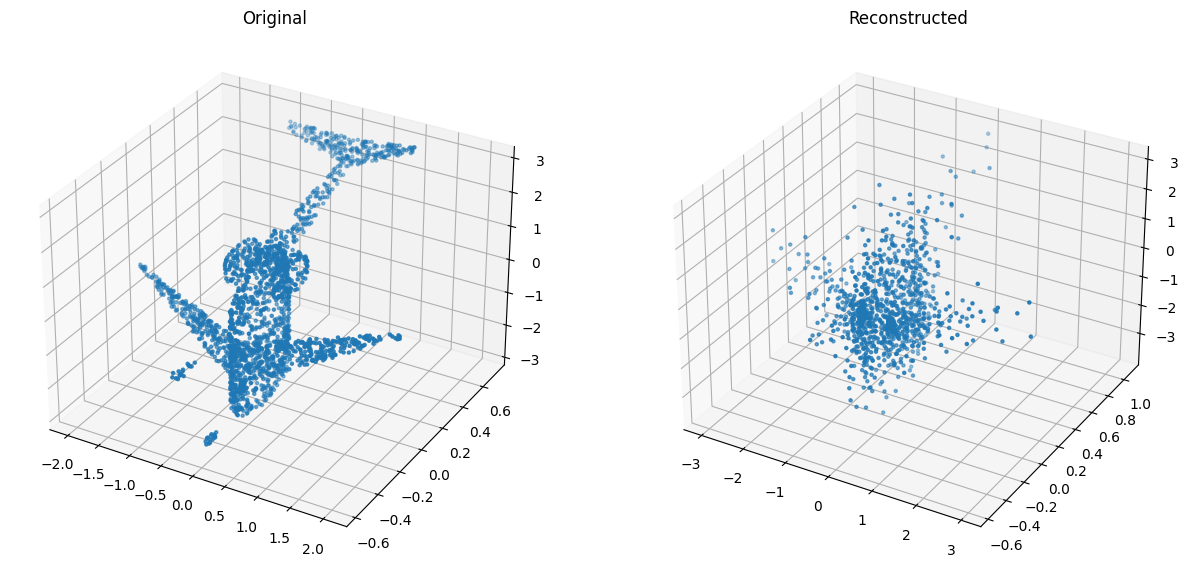

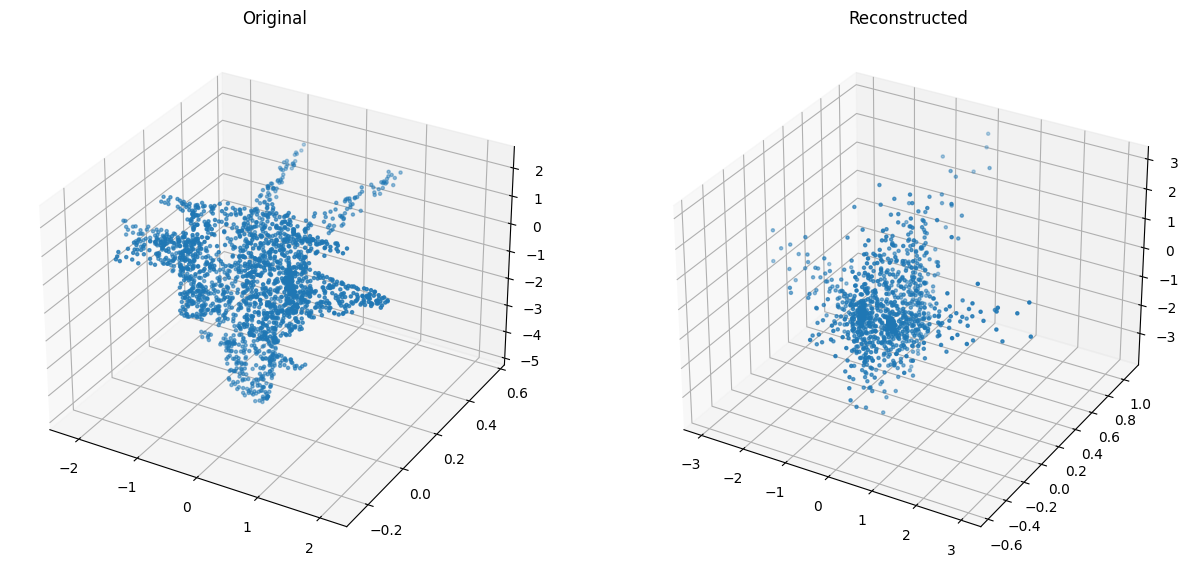

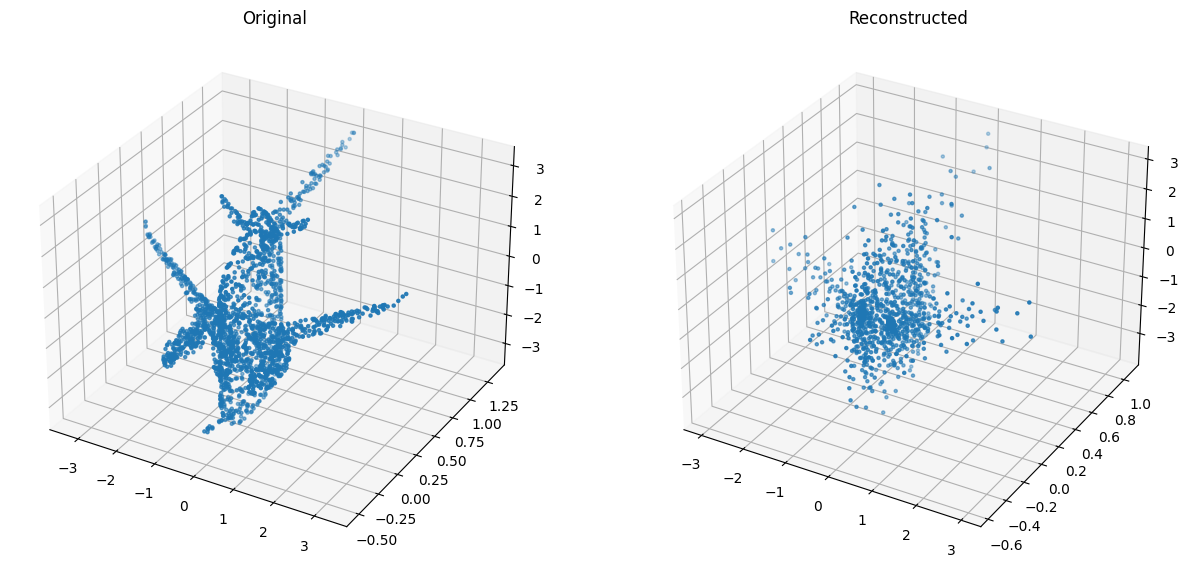

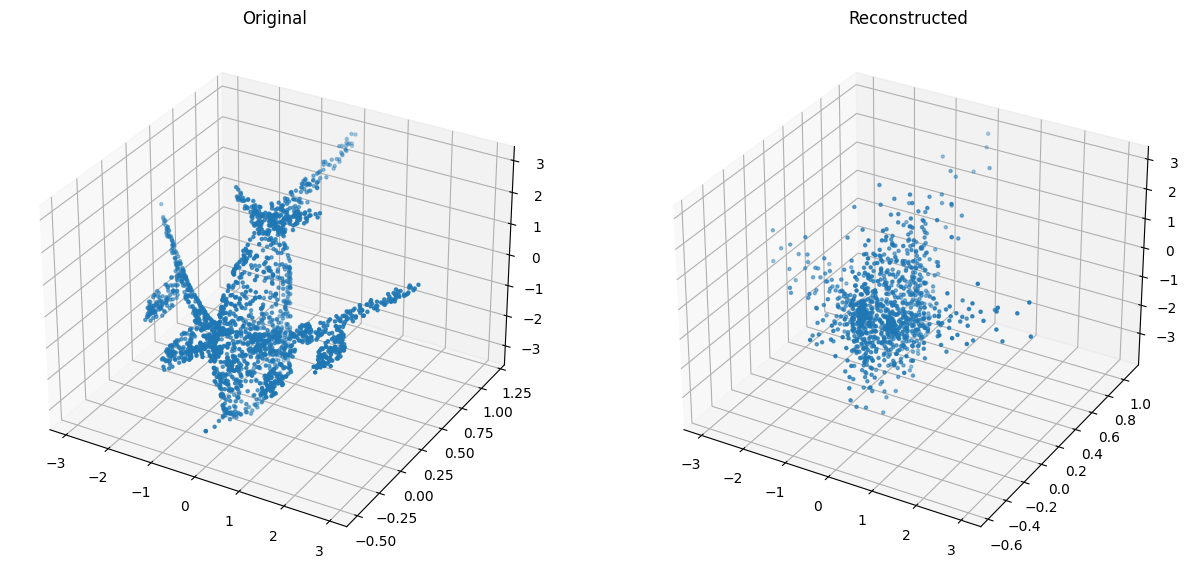

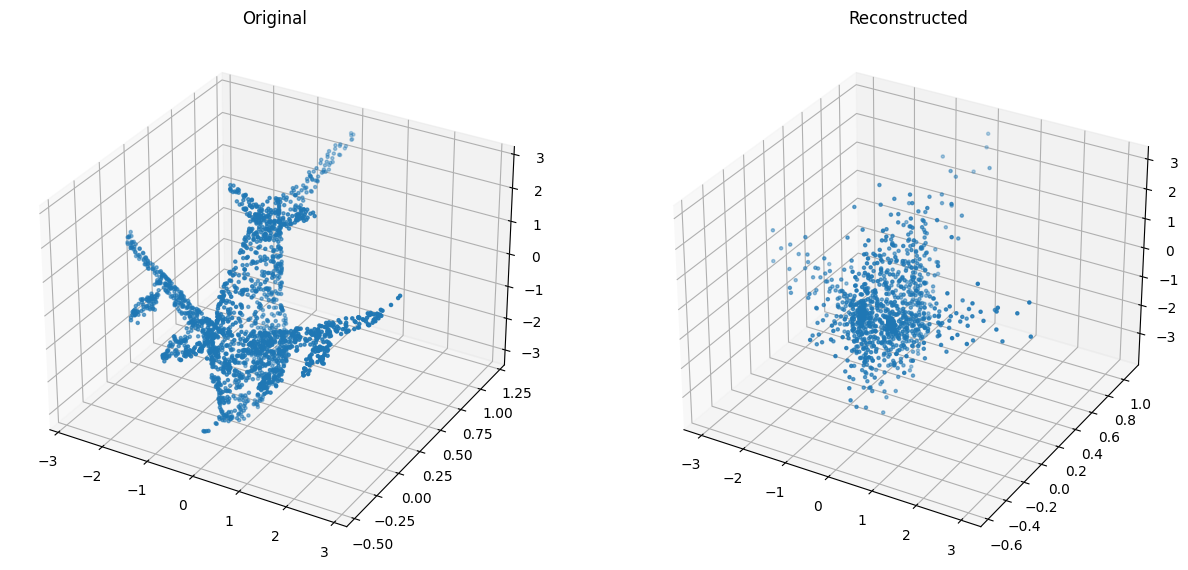

In [17]:
visualize_reconstruction(vae, val_dset)